<a href="https://colab.research.google.com/github/quanndm/kltn/blob/dev/notebooks/main_cot_da.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Init - import library - download data

In [1]:
!rm -rf kltn
!rm -rf sample_data
!git clone -b dev https://github.com/quanndm/kltn.git

Cloning into 'kltn'...
remote: Enumerating objects: 891, done.
remote: Counting objects: 100% (199/199), done.
remote: Compressing objects: 100% (140/140), done.
remote: Total 891 (delta 128), reused 116 (delta 59), pack-reused 692 (from 1)
Receiving objects: 100% (891/891), 6.11 MiB | 11.36 MiB/s, done.
Resolving deltas: 100% (583/583), done.


In [2]:
from kltn.init.install_dependencies import install_packages, load_config
install_packages("./kltn")
config = load_config("./kltn/parameters.yaml")


In [3]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from google.colab import drive

from kltn import *
from kltn.datasets.get_datasets import get_datasets_lits
from kltn.utils.logger import init_logger
from kltn.utils.train_val_epochs import trainer, val_epoch
from kltn.utils.metrics import DiceLossWSigmoid, DiceLossWSoftmax, DiceMetric
from kltn.models.model_factory import ModelFactory
from kltn.utils.visualize_results import visualize_results

In [4]:
drive.flush_and_unmount()
drive.mount("/content/drive")

Drive not mounted, so nothing to flush and unmount.
Mounted at /content/drive


In [5]:
LOGGER = init_logger(config["log_path"])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
from kltn.datasets.prepare_data import prepare_dataset_LiTS
prepare_dataset_LiTS(dir_name=config["source_folder_lits"])

0.20% complete (down: 0.0 kB/s up: 0.0 kB/s peers: 1) downloading LITS17 (https://academictorrents.com/announce.php)[127.0.0.1:6881] v1 skipping tracker announce (unreachable) "" (1)
LITS17 (https://ipv6.academictorrents.com/announce.php)[127.0.0.1:6881] v1 skipping tracker announce (unreachable) "" (1)
LITS17 (https://academictorrents.com/announce.php)[172.28.0.12:6881] v1 unspecified system error "" (1)
LITS17 (https://ipv6.academictorrents.com/announce.php)[172.28.0.12:6881] v1 unspecified system error "" (1)
LITS17 (udp://tracker.opentrackr.org:1337/announce)[127.0.0.1:6881] v1 skipping tracker announce (unreachable) "" (1)
1.49% complete (down: 10170.0 kB/s up: 297.9 kB/s peers: 10) downloading LITS17 (https://academictorrents.com/announce.php)[127.0.0.1:6881] v1 skipping tracker announce (unreachable) "" (2)
LITS17 (https://ipv6.academictorrents.com/announce.php)[127.0.0.1:6881] v1 skipping tracker announce (unreachable) "" (2)
LITS17 (https://academictorrents.com/announce.php)[1

## Load data

In [7]:
full_train_dataset, val_dataset = get_datasets_lits(source_folder=config["source_folder_lits"], seed=123, fold_number=2)
print(len(full_train_dataset), len(val_dataset))

105 26


In [8]:
train_loader = torch.utils.data.DataLoader(full_train_dataset, batch_size=1, shuffle=True,
                                           num_workers=1, pin_memory=True, drop_last=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=1, shuffle=False,
                                         pin_memory=True, num_workers=1)

print("Train dataset number of batch:", len(train_loader))
print("Val dataset number of batch:", len(val_loader))

Train dataset number of batch: 105
Val dataset number of batch: 26


In [9]:
for batch in train_loader:
    # Assuming your input data is a 5D tensor (batch_size, channels, deep, height, width)
    data_shape = batch['image'].shape
    label_shape = batch['label'].shape
    print("Data shape in the first batch:", data_shape)
    print("Label shape in the first batch:", label_shape)
    break  # Print only the first batch

Data shape in the first batch: torch.Size([1, 1, 128, 128, 128])
Label shape in the first batch: torch.Size([1, 1, 128, 128, 128])


## Visual data

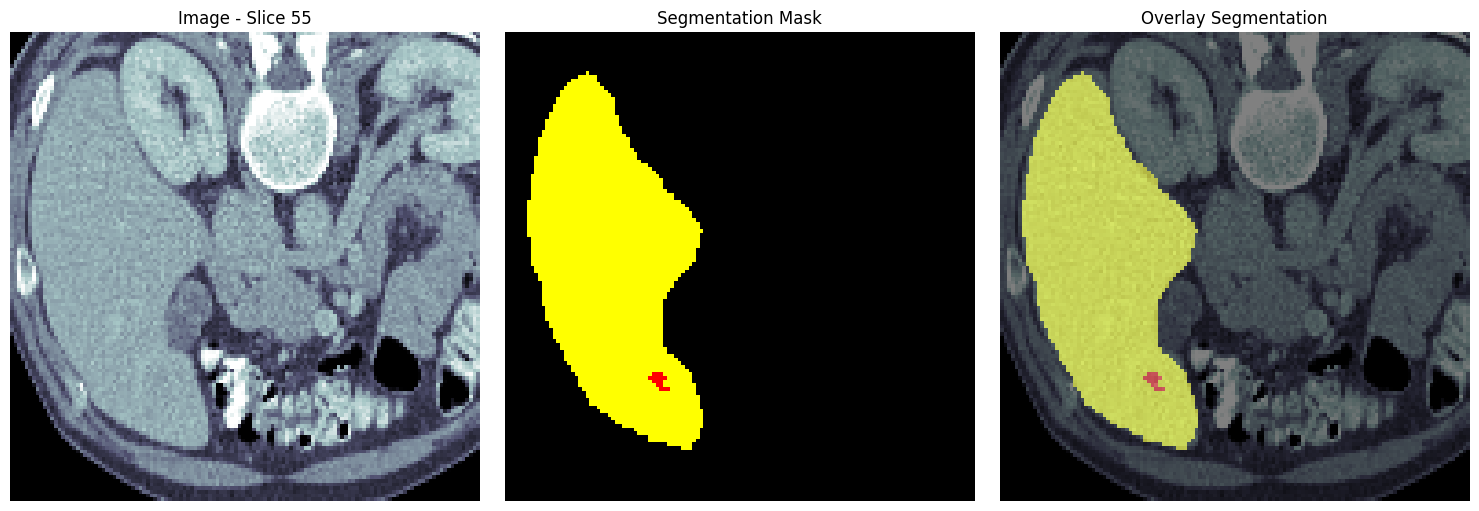

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors

# Define colormap for segmentation classes
cmap = mcolors.ListedColormap(["black", "yellow", "red", "green", "blue", "purple"])
bounds = [0, 1, 2, 3, 4, 5]
norm = mcolors.BoundaryNorm(bounds, cmap.N)

for batch in train_loader:
    image_sample = batch['image']  # Shape: [1, 1, 128, 128, 128]
    label_sample = batch['label']  # Shape: [1, 1, 128, 128, 128]

    label_data = label_sample[0, 0].numpy()  # shape: [128, 128, 128]
    image_data = image_sample[0, 0].numpy()

    # Tìm tất cả slice index có tumor
    tumor_slices = np.any(label_data == 2, axis=(1, 2))


    slice_idx = np.argmax(tumor_slices)

    img_slice = image_data[slice_idx, :, :]
    label_slice = label_data[slice_idx, :, :]

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    axes[0].imshow(img_slice, cmap=plt.cm.bone)
    axes[0].set_title(f"Image - Slice {slice_idx}")
    axes[0].axis("off")

    axes[1].imshow(label_slice, cmap=cmap, norm=norm)
    axes[1].set_title("Segmentation Mask")
    axes[1].axis("off")

    axes[2].imshow(img_slice, cmap=plt.cm.bone)
    axes[2].imshow(label_slice, cmap=cmap, norm=norm, alpha=0.5)
    axes[2].set_title("Overlay Segmentation")
    axes[2].axis("off")

    plt.tight_layout()
    plt.show()
    break

## Model

In [11]:
model = ModelFactory.get_model("unet3d_cot_da",in_channels=1, n_classes=3, n_channels=16).to(device)
print('Number of network parameters:', sum(param.numel() for param in model.parameters()))

Number of network parameters: 1748987


## Training

In [12]:
criterion = DiceLossWSoftmax().to(device)

dice_acc = DiceMetric(include_background=False, reduction='mean_batch', get_not_nans=True)

optimizer = torch.optim.AdamW(model.parameters(), lr=float(config["learning_rate"]), weight_decay=float(config["weight_decay"]))
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=int(config["max_epochs"]), eta_min = float(config["eta_min"]))

In [13]:
LOGGER.info("[TRAINER] Start TRAIN process...")

(
    val_acc_max,
    best_epoch,
    dices_liver,
    dices_tumor,
    dices_avg,
    loss_epochs,
    trains_epoch,
    ious_liver,
    ious_tumor,
    ious_avg,
    precisions_liver,
    precisions_tumor,
    precisions_avg,
    recalls_liver,
    recalls_tumor,
    recalls_avg,
    time_tmp,
) = trainer(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    loss_func=criterion,
    acc_func=dice_acc,
    scheduler=scheduler,
    batch_size=config["batch_size"],
    max_epochs = config["max_epochs"],
    start_epoch = config["start_epoch"],
    val_every=config["val_every"],
    path_save_model=config["path_save_model_state"],
    logger=LOGGER,
    save_model=True,
)

[TRAINER] Start TRAIN process...
INFO:kltn.utils.logger:[TRAINER] Start TRAIN process...

==============================Training epoch 1==============================
INFO:kltn.utils.logger:
==============================Training epoch 1==============================


Epoch 1/100 1/105 loss: 0.9188 time 5.55s
Epoch 1/100 2/105 loss: 0.8973 time 0.93s
Epoch 1/100 3/105 loss: 0.8833 time 6.25s
Epoch 1/100 4/105 loss: 0.8730 time 6.57s
Epoch 1/100 5/105 loss: 0.8630 time 1.36s
Epoch 1/100 6/105 loss: 0.8580 time 1.49s
Epoch 1/100 7/105 loss: 0.8509 time 5.47s
Epoch 1/100 8/105 loss: 0.8441 time 4.68s
Epoch 1/100 9/105 loss: 0.8429 time 2.57s
Epoch 1/100 10/105 loss: 0.8374 time 4.63s
Epoch 1/100 11/105 loss: 0.8326 time 0.93s
Epoch 1/100 12/105 loss: 0.8285 time 3.99s
Epoch 1/100 13/105 loss: 0.8250 time 0.93s
Epoch 1/100 14/105 loss: 0.8206 time 5.71s
Epoch 1/100 15/105 loss: 0.8169 time 2.82s
Epoch 1/100 16/105 loss: 0.8135 time 5.06s
Epoch 1/100 17/105 loss: 0.8117 time 1.12s
Epoch 1/100 18/105 loss: 0.8080 time 5.88s
Epoch 1/100 19/105 loss: 0.8049 time 1.31s
Epoch 1/100 20/105 loss: 0.8023 time 1.25s
Epoch 1/100 21/105 loss: 0.7998 time 5.33s
Epoch 1/100 22/105 loss: 0.7957 time 4.20s
Epoch 1/100 23/105 loss: 0.7929 time 5.16s
Epoch 1/100 24/105 l

Final training epochs: 1/100 ---[loss: 0.6201] ---[time 400.40s]
INFO:kltn.utils.logger:Final training epochs: 1/100 ---[loss: 0.6201] ---[time 400.40s]

********************Epoch 1 Validation********************
INFO:kltn.utils.logger:
********************Epoch 1 Validation********************


Epoch 1/100 105/105 loss: 0.6201 time 1.78s


Val 1/100 1/26, Dice_Liver: 0.552710, Dice_Tumor: 0.000000, Dice_Avg: 0.276355, time 5.02s
INFO:kltn.utils.logger:Val 1/100 1/26, Dice_Liver: 0.552710, Dice_Tumor: 0.000000, Dice_Avg: 0.276355, time 5.02s
Val 1/100 2/26, Dice_Liver: 0.670020, Dice_Tumor: 0.000000, Dice_Avg: 0.335010, time 2.95s
INFO:kltn.utils.logger:Val 1/100 2/26, Dice_Liver: 0.670020, Dice_Tumor: 0.000000, Dice_Avg: 0.335010, time 2.95s
Val 1/100 3/26, Dice_Liver: 0.720891, Dice_Tumor: 0.000000, Dice_Avg: 0.360445, time 4.57s
INFO:kltn.utils.logger:Val 1/100 3/26, Dice_Liver: 0.720891, Dice_Tumor: 0.000000, Dice_Avg: 0.360445, time 4.57s
Val 1/100 4/26, Dice_Liver: 0.735669, Dice_Tumor: 0.000000, Dice_Avg: 0.367834, time 4.89s
INFO:kltn.utils.logger:Val 1/100 4/26, Dice_Liver: 0.735669, Dice_Tumor: 0.000000, Dice_Avg: 0.367834, time 4.89s
Val 1/100 5/26, Dice_Liver: 0.738718, Dice_Tumor: 0.000000, Dice_Avg: 0.369359, time 4.26s
INFO:kltn.utils.logger:Val 1/100 5/26, Dice_Liver: 0.738718, Dice_Tumor: 0.000000, Dice_A

New best (0.000000 --> 0.375773). At epoch 1


Epoch 1/100 ---[loss: 0.6201] ---[val_dice: 0.375773] ---[time 88.62s]
INFO:kltn.utils.logger:Epoch 1/100 ---[loss: 0.6201] ---[val_dice: 0.375773] ---[time 88.62s]

==============================Training epoch 2==============================
INFO:kltn.utils.logger:
==============================Training epoch 2==============================


Epoch 2/100 1/105 loss: 0.4596 time 6.94s
Epoch 2/100 2/105 loss: 0.4609 time 1.09s
Epoch 2/100 3/105 loss: 0.4604 time 5.04s
Epoch 2/100 4/105 loss: 0.4614 time 1.17s
Epoch 2/100 5/105 loss: 0.4628 time 0.93s
Epoch 2/100 6/105 loss: 0.4622 time 1.05s
Epoch 2/100 7/105 loss: 0.4615 time 1.03s
Epoch 2/100 8/105 loss: 0.4589 time 2.58s
Epoch 2/100 9/105 loss: 0.4576 time 5.54s
Epoch 2/100 10/105 loss: 0.4568 time 5.82s
Epoch 2/100 11/105 loss: 0.4588 time 2.08s
Epoch 2/100 12/105 loss: 0.4578 time 5.06s
Epoch 2/100 13/105 loss: 0.4571 time 1.22s
Epoch 2/100 14/105 loss: 0.4620 time 1.97s
Epoch 2/100 15/105 loss: 0.4619 time 6.35s
Epoch 2/100 16/105 loss: 0.4604 time 1.33s
Epoch 2/100 17/105 loss: 0.4594 time 2.14s
Epoch 2/100 18/105 loss: 0.4594 time 4.72s
Epoch 2/100 19/105 loss: 0.4586 time 7.37s
Epoch 2/100 20/105 loss: 0.4582 time 0.95s
Epoch 2/100 21/105 loss: 0.4587 time 2.36s
Epoch 2/100 22/105 loss: 0.4580 time 4.04s
Epoch 2/100 23/105 loss: 0.4577 time 2.50s
Epoch 2/100 24/105 l

Final training epochs: 2/100 ---[loss: 0.4312] ---[time 385.80s]
INFO:kltn.utils.logger:Final training epochs: 2/100 ---[loss: 0.4312] ---[time 385.80s]

********************Epoch 2 Validation********************
INFO:kltn.utils.logger:
********************Epoch 2 Validation********************


Epoch 2/100 105/105 loss: 0.4312 time 0.99s


Val 2/100 1/26, Dice_Liver: 0.760279, Dice_Tumor: 0.000000, Dice_Avg: 0.380139, time 1.55s
INFO:kltn.utils.logger:Val 2/100 1/26, Dice_Liver: 0.760279, Dice_Tumor: 0.000000, Dice_Avg: 0.380139, time 1.55s
Val 2/100 2/26, Dice_Liver: 0.792622, Dice_Tumor: 0.000000, Dice_Avg: 0.396311, time 5.03s
INFO:kltn.utils.logger:Val 2/100 2/26, Dice_Liver: 0.792622, Dice_Tumor: 0.000000, Dice_Avg: 0.396311, time 5.03s
Val 2/100 3/26, Dice_Liver: 0.815818, Dice_Tumor: 0.000000, Dice_Avg: 0.407909, time 4.77s
INFO:kltn.utils.logger:Val 2/100 3/26, Dice_Liver: 0.815818, Dice_Tumor: 0.000000, Dice_Avg: 0.407909, time 4.77s
Val 2/100 4/26, Dice_Liver: 0.809536, Dice_Tumor: 0.000000, Dice_Avg: 0.404768, time 4.90s
INFO:kltn.utils.logger:Val 2/100 4/26, Dice_Liver: 0.809536, Dice_Tumor: 0.000000, Dice_Avg: 0.404768, time 4.90s
Val 2/100 5/26, Dice_Liver: 0.801006, Dice_Tumor: 0.000000, Dice_Avg: 0.400503, time 4.16s
INFO:kltn.utils.logger:Val 2/100 5/26, Dice_Liver: 0.801006, Dice_Tumor: 0.000000, Dice_A

New best (0.375773 --> 0.414276). At epoch 2
Epoch 3/100 1/105 loss: 0.4077 time 7.17s
Epoch 3/100 2/105 loss: 0.4001 time 1.78s
Epoch 3/100 3/105 loss: 0.4063 time 4.22s
Epoch 3/100 4/105 loss: 0.4046 time 4.74s
Epoch 3/100 5/105 loss: 0.4035 time 6.27s
Epoch 3/100 6/105 loss: 0.4022 time 4.26s
Epoch 3/100 7/105 loss: 0.4017 time 1.28s
Epoch 3/100 8/105 loss: 0.4052 time 3.23s
Epoch 3/100 9/105 loss: 0.4073 time 0.94s
Epoch 3/100 10/105 loss: 0.4059 time 3.38s
Epoch 3/100 11/105 loss: 0.4057 time 5.11s
Epoch 3/100 12/105 loss: 0.4055 time 1.75s
Epoch 3/100 13/105 loss: 0.4054 time 1.73s
Epoch 3/100 14/105 loss: 0.4046 time 6.03s
Epoch 3/100 15/105 loss: 0.4041 time 0.95s
Epoch 3/100 16/105 loss: 0.4040 time 5.88s
Epoch 3/100 17/105 loss: 0.4048 time 10.18s
Epoch 3/100 18/105 loss: 0.4031 time 2.19s
Epoch 3/100 19/105 loss: 0.4029 time 2.14s
Epoch 3/100 20/105 loss: 0.4029 time 2.31s
Epoch 3/100 21/105 loss: 0.4019 time 4.84s
Epoch 3/100 22/105 loss: 0.4028 time 7.91s
Epoch 3/100 23/10

Final training epochs: 3/100 ---[loss: 0.3963] ---[time 387.99s]
INFO:kltn.utils.logger:Final training epochs: 3/100 ---[loss: 0.3963] ---[time 387.99s]

********************Epoch 3 Validation********************
INFO:kltn.utils.logger:
********************Epoch 3 Validation********************


Epoch 3/100 105/105 loss: 0.3963 time 4.97s


Val 3/100 1/26, Dice_Liver: 0.851045, Dice_Tumor: 0.000000, Dice_Avg: 0.425523, time 1.57s
INFO:kltn.utils.logger:Val 3/100 1/26, Dice_Liver: 0.851045, Dice_Tumor: 0.000000, Dice_Avg: 0.425523, time 1.57s
Val 3/100 2/26, Dice_Liver: 0.857795, Dice_Tumor: 0.000000, Dice_Avg: 0.428897, time 4.78s
INFO:kltn.utils.logger:Val 3/100 2/26, Dice_Liver: 0.857795, Dice_Tumor: 0.000000, Dice_Avg: 0.428897, time 4.78s
Val 3/100 3/26, Dice_Liver: 0.867233, Dice_Tumor: 0.000000, Dice_Avg: 0.433617, time 5.51s
INFO:kltn.utils.logger:Val 3/100 3/26, Dice_Liver: 0.867233, Dice_Tumor: 0.000000, Dice_Avg: 0.433617, time 5.51s
Val 3/100 4/26, Dice_Liver: 0.866248, Dice_Tumor: 0.047248, Dice_Avg: 0.456748, time 4.04s
INFO:kltn.utils.logger:Val 3/100 4/26, Dice_Liver: 0.866248, Dice_Tumor: 0.047248, Dice_Avg: 0.456748, time 4.04s
Val 3/100 5/26, Dice_Liver: 0.847993, Dice_Tumor: 0.037799, Dice_Avg: 0.442896, time 4.13s
INFO:kltn.utils.logger:Val 3/100 5/26, Dice_Liver: 0.847993, Dice_Tumor: 0.037799, Dice_A

New best (0.414276 --> 0.453579). At epoch 3
Epoch 4/100 1/105 loss: 0.3320 time 3.49s
Epoch 4/100 2/105 loss: 0.3629 time 1.16s
Epoch 4/100 3/105 loss: 0.3717 time 4.89s
Epoch 4/100 4/105 loss: 0.3785 time 4.63s
Epoch 4/100 5/105 loss: 0.3813 time 6.25s
Epoch 4/100 6/105 loss: 0.3848 time 1.02s
Epoch 4/100 7/105 loss: 0.3814 time 2.51s
Epoch 4/100 8/105 loss: 0.3812 time 5.43s
Epoch 4/100 9/105 loss: 0.3784 time 4.81s
Epoch 4/100 10/105 loss: 0.3755 time 6.93s
Epoch 4/100 11/105 loss: 0.3731 time 4.89s
Epoch 4/100 12/105 loss: 0.3750 time 4.80s
Epoch 4/100 13/105 loss: 0.3697 time 5.61s
Epoch 4/100 14/105 loss: 0.3721 time 5.45s
Epoch 4/100 15/105 loss: 0.3730 time 5.40s
Epoch 4/100 16/105 loss: 0.3725 time 4.53s
Epoch 4/100 17/105 loss: 0.3737 time 1.00s
Epoch 4/100 18/105 loss: 0.3736 time 5.15s
Epoch 4/100 19/105 loss: 0.3755 time 7.81s
Epoch 4/100 20/105 loss: 0.3766 time 2.29s
Epoch 4/100 21/105 loss: 0.3761 time 4.32s
Epoch 4/100 22/105 loss: 0.3765 time 1.61s
Epoch 4/100 23/105

Final training epochs: 4/100 ---[loss: 0.3754] ---[time 390.48s]
INFO:kltn.utils.logger:Final training epochs: 4/100 ---[loss: 0.3754] ---[time 390.48s]

********************Epoch 4 Validation********************
INFO:kltn.utils.logger:
********************Epoch 4 Validation********************


Epoch 4/100 105/105 loss: 0.3754 time 4.83s


Val 4/100 1/26, Dice_Liver: 0.763666, Dice_Tumor: 0.000000, Dice_Avg: 0.381833, time 1.44s
INFO:kltn.utils.logger:Val 4/100 1/26, Dice_Liver: 0.763666, Dice_Tumor: 0.000000, Dice_Avg: 0.381833, time 1.44s
Val 4/100 2/26, Dice_Liver: 0.824262, Dice_Tumor: 0.000000, Dice_Avg: 0.412131, time 5.52s
INFO:kltn.utils.logger:Val 4/100 2/26, Dice_Liver: 0.824262, Dice_Tumor: 0.000000, Dice_Avg: 0.412131, time 5.52s
Val 4/100 3/26, Dice_Liver: 0.842367, Dice_Tumor: 0.000000, Dice_Avg: 0.421183, time 4.45s
INFO:kltn.utils.logger:Val 4/100 3/26, Dice_Liver: 0.842367, Dice_Tumor: 0.000000, Dice_Avg: 0.421183, time 4.45s
Val 4/100 4/26, Dice_Liver: 0.849548, Dice_Tumor: 0.062471, Dice_Avg: 0.456010, time 4.21s
INFO:kltn.utils.logger:Val 4/100 4/26, Dice_Liver: 0.849548, Dice_Tumor: 0.062471, Dice_Avg: 0.456010, time 4.21s
Val 4/100 5/26, Dice_Liver: 0.838891, Dice_Tumor: 0.049977, Dice_Avg: 0.444434, time 4.27s
INFO:kltn.utils.logger:Val 4/100 5/26, Dice_Liver: 0.838891, Dice_Tumor: 0.049977, Dice_A

New best (0.453579 --> 0.469162). At epoch 4
Epoch 5/100 1/105 loss: 0.3279 time 6.52s
Epoch 5/100 2/105 loss: 0.3213 time 1.73s
Epoch 5/100 3/105 loss: 0.3469 time 5.94s
Epoch 5/100 4/105 loss: 0.3512 time 4.05s
Epoch 5/100 5/105 loss: 0.3478 time 6.54s
Epoch 5/100 6/105 loss: 0.3410 time 1.11s
Epoch 5/100 7/105 loss: 0.3515 time 4.15s
Epoch 5/100 8/105 loss: 0.3594 time 2.87s
Epoch 5/100 9/105 loss: 0.3568 time 1.18s
Epoch 5/100 10/105 loss: 0.3588 time 5.40s
Epoch 5/100 11/105 loss: 0.3631 time 2.71s
Epoch 5/100 12/105 loss: 0.3628 time 7.63s
Epoch 5/100 13/105 loss: 0.3644 time 6.18s
Epoch 5/100 14/105 loss: 0.3667 time 2.43s
Epoch 5/100 15/105 loss: 0.3639 time 5.58s
Epoch 5/100 16/105 loss: 0.3647 time 0.95s
Epoch 5/100 17/105 loss: 0.3646 time 5.58s
Epoch 5/100 18/105 loss: 0.3660 time 6.18s
Epoch 5/100 19/105 loss: 0.3675 time 1.18s
Epoch 5/100 20/105 loss: 0.3668 time 4.48s
Epoch 5/100 21/105 loss: 0.3679 time 0.98s
Epoch 5/100 22/105 loss: 0.3684 time 6.08s
Epoch 5/100 23/105

Final training epochs: 5/100 ---[loss: 0.3619] ---[time 390.89s]
INFO:kltn.utils.logger:Final training epochs: 5/100 ---[loss: 0.3619] ---[time 390.89s]

********************Epoch 5 Validation********************
INFO:kltn.utils.logger:
********************Epoch 5 Validation********************


Epoch 5/100 105/105 loss: 0.3619 time 1.35s


Val 5/100 1/26, Dice_Liver: 0.821118, Dice_Tumor: 0.000770, Dice_Avg: 0.410944, time 1.53s
INFO:kltn.utils.logger:Val 5/100 1/26, Dice_Liver: 0.821118, Dice_Tumor: 0.000770, Dice_Avg: 0.410944, time 1.53s
Val 5/100 2/26, Dice_Liver: 0.854654, Dice_Tumor: 0.000385, Dice_Avg: 0.427519, time 5.01s
INFO:kltn.utils.logger:Val 5/100 2/26, Dice_Liver: 0.854654, Dice_Tumor: 0.000385, Dice_Avg: 0.427519, time 5.01s
Val 5/100 3/26, Dice_Liver: 0.870527, Dice_Tumor: 0.000357, Dice_Avg: 0.435442, time 4.57s
INFO:kltn.utils.logger:Val 5/100 3/26, Dice_Liver: 0.870527, Dice_Tumor: 0.000357, Dice_Avg: 0.435442, time 4.57s
Val 5/100 4/26, Dice_Liver: 0.874977, Dice_Tumor: 0.012528, Dice_Avg: 0.443753, time 4.40s
INFO:kltn.utils.logger:Val 5/100 4/26, Dice_Liver: 0.874977, Dice_Tumor: 0.012528, Dice_Avg: 0.443753, time 4.40s
Val 5/100 5/26, Dice_Liver: 0.859360, Dice_Tumor: 0.010022, Dice_Avg: 0.434691, time 4.22s
INFO:kltn.utils.logger:Val 5/100 5/26, Dice_Liver: 0.859360, Dice_Tumor: 0.010022, Dice_A

New best (0.469162 --> 0.510320). At epoch 5
Epoch 6/100 1/105 loss: 0.3285 time 11.23s
Epoch 6/100 2/105 loss: 0.3537 time 4.55s
Epoch 6/100 3/105 loss: 0.3674 time 3.19s
Epoch 6/100 4/105 loss: 0.3643 time 1.51s
Epoch 6/100 5/105 loss: 0.3663 time 2.57s
Epoch 6/100 6/105 loss: 0.3602 time 1.07s
Epoch 6/100 7/105 loss: 0.3638 time 8.65s
Epoch 6/100 8/105 loss: 0.3542 time 8.58s
Epoch 6/100 9/105 loss: 0.3573 time 1.37s
Epoch 6/100 10/105 loss: 0.3599 time 5.99s
Epoch 6/100 11/105 loss: 0.3539 time 7.03s
Epoch 6/100 12/105 loss: 0.3606 time 2.98s
Epoch 6/100 13/105 loss: 0.3525 time 1.17s
Epoch 6/100 14/105 loss: 0.3450 time 1.89s
Epoch 6/100 15/105 loss: 0.3487 time 4.81s
Epoch 6/100 16/105 loss: 0.3518 time 6.49s
Epoch 6/100 17/105 loss: 0.3490 time 5.04s
Epoch 6/100 18/105 loss: 0.3515 time 2.78s
Epoch 6/100 19/105 loss: 0.3529 time 5.21s
Epoch 6/100 20/105 loss: 0.3511 time 0.95s
Epoch 6/100 21/105 loss: 0.3458 time 4.53s
Epoch 6/100 22/105 loss: 0.3477 time 6.33s
Epoch 6/100 23/10

Final training epochs: 6/100 ---[loss: 0.3522] ---[time 406.68s]
INFO:kltn.utils.logger:Final training epochs: 6/100 ---[loss: 0.3522] ---[time 406.68s]

********************Epoch 6 Validation********************
INFO:kltn.utils.logger:
********************Epoch 6 Validation********************


Epoch 6/100 105/105 loss: 0.3522 time 2.92s


Val 6/100 1/26, Dice_Liver: 0.822675, Dice_Tumor: 0.000000, Dice_Avg: 0.411337, time 1.66s
INFO:kltn.utils.logger:Val 6/100 1/26, Dice_Liver: 0.822675, Dice_Tumor: 0.000000, Dice_Avg: 0.411337, time 1.66s
Val 6/100 2/26, Dice_Liver: 0.844912, Dice_Tumor: 0.037333, Dice_Avg: 0.441123, time 6.18s
INFO:kltn.utils.logger:Val 6/100 2/26, Dice_Liver: 0.844912, Dice_Tumor: 0.037333, Dice_Avg: 0.441123, time 6.18s
Val 6/100 3/26, Dice_Liver: 0.858845, Dice_Tumor: 0.024889, Dice_Avg: 0.441867, time 5.13s
INFO:kltn.utils.logger:Val 6/100 3/26, Dice_Liver: 0.858845, Dice_Tumor: 0.024889, Dice_Avg: 0.441867, time 5.13s
Val 6/100 4/26, Dice_Liver: 0.856487, Dice_Tumor: 0.018866, Dice_Avg: 0.437677, time 4.80s
INFO:kltn.utils.logger:Val 6/100 4/26, Dice_Liver: 0.856487, Dice_Tumor: 0.018866, Dice_Avg: 0.437677, time 4.80s
Val 6/100 5/26, Dice_Liver: 0.823242, Dice_Tumor: 0.015093, Dice_Avg: 0.419167, time 4.56s
INFO:kltn.utils.logger:Val 6/100 5/26, Dice_Liver: 0.823242, Dice_Tumor: 0.015093, Dice_A

New best (0.510320 --> 0.513570). At epoch 6
Epoch 7/100 1/105 loss: 0.3418 time 6.95s
Epoch 7/100 2/105 loss: 0.3406 time 1.70s
Epoch 7/100 3/105 loss: 0.3517 time 0.98s
Epoch 7/100 4/105 loss: 0.3313 time 6.22s
Epoch 7/100 5/105 loss: 0.3170 time 1.39s
Epoch 7/100 6/105 loss: 0.3167 time 6.27s
Epoch 7/100 7/105 loss: 0.3176 time 2.92s
Epoch 7/100 8/105 loss: 0.3235 time 6.07s
Epoch 7/100 9/105 loss: 0.3271 time 3.97s
Epoch 7/100 10/105 loss: 0.3185 time 4.51s
Epoch 7/100 11/105 loss: 0.3231 time 5.60s
Epoch 7/100 12/105 loss: 0.3211 time 6.39s
Epoch 7/100 13/105 loss: 0.3228 time 3.28s
Epoch 7/100 14/105 loss: 0.3279 time 2.64s
Epoch 7/100 15/105 loss: 0.3307 time 6.34s
Epoch 7/100 16/105 loss: 0.3285 time 1.80s
Epoch 7/100 17/105 loss: 0.3313 time 5.34s
Epoch 7/100 18/105 loss: 0.3346 time 1.30s
Epoch 7/100 19/105 loss: 0.3372 time 1.25s
Epoch 7/100 20/105 loss: 0.3396 time 1.00s
Epoch 7/100 21/105 loss: 0.3381 time 1.01s
Epoch 7/100 22/105 loss: 0.3390 time 6.47s
Epoch 7/100 23/105

Final training epochs: 7/100 ---[loss: 0.3389] ---[time 432.70s]
INFO:kltn.utils.logger:Final training epochs: 7/100 ---[loss: 0.3389] ---[time 432.70s]

********************Epoch 7 Validation********************
INFO:kltn.utils.logger:
********************Epoch 7 Validation********************


Epoch 7/100 105/105 loss: 0.3389 time 1.67s


Val 7/100 1/26, Dice_Liver: 0.892920, Dice_Tumor: 0.000000, Dice_Avg: 0.446460, time 1.55s
INFO:kltn.utils.logger:Val 7/100 1/26, Dice_Liver: 0.892920, Dice_Tumor: 0.000000, Dice_Avg: 0.446460, time 1.55s
Val 7/100 2/26, Dice_Liver: 0.896133, Dice_Tumor: 0.000000, Dice_Avg: 0.448066, time 5.27s
INFO:kltn.utils.logger:Val 7/100 2/26, Dice_Liver: 0.896133, Dice_Tumor: 0.000000, Dice_Avg: 0.448066, time 5.27s
Val 7/100 3/26, Dice_Liver: 0.892193, Dice_Tumor: 0.000000, Dice_Avg: 0.446096, time 5.88s
INFO:kltn.utils.logger:Val 7/100 3/26, Dice_Liver: 0.892193, Dice_Tumor: 0.000000, Dice_Avg: 0.446096, time 5.88s
Val 7/100 4/26, Dice_Liver: 0.887488, Dice_Tumor: 0.035106, Dice_Avg: 0.461297, time 4.61s
INFO:kltn.utils.logger:Val 7/100 4/26, Dice_Liver: 0.887488, Dice_Tumor: 0.035106, Dice_Avg: 0.461297, time 4.61s
Val 7/100 5/26, Dice_Liver: 0.872053, Dice_Tumor: 0.028085, Dice_Avg: 0.450069, time 4.58s
INFO:kltn.utils.logger:Val 7/100 5/26, Dice_Liver: 0.872053, Dice_Tumor: 0.028085, Dice_A

New best (0.513570 --> 0.516602). At epoch 7
Epoch 8/100 1/105 loss: 0.2901 time 3.00s
Epoch 8/100 2/105 loss: 0.3046 time 6.49s
Epoch 8/100 3/105 loss: 0.3226 time 1.47s
Epoch 8/100 4/105 loss: 0.3258 time 0.95s
Epoch 8/100 5/105 loss: 0.3344 time 6.06s
Epoch 8/100 6/105 loss: 0.3458 time 6.35s
Epoch 8/100 7/105 loss: 0.3509 time 1.61s
Epoch 8/100 8/105 loss: 0.3464 time 5.59s
Epoch 8/100 9/105 loss: 0.3342 time 1.99s
Epoch 8/100 10/105 loss: 0.3369 time 1.91s
Epoch 8/100 11/105 loss: 0.3430 time 7.15s
Epoch 8/100 12/105 loss: 0.3407 time 2.72s
Epoch 8/100 13/105 loss: 0.3425 time 6.18s
Epoch 8/100 14/105 loss: 0.3456 time 5.71s
Epoch 8/100 15/105 loss: 0.3485 time 1.57s
Epoch 8/100 16/105 loss: 0.3442 time 6.15s
Epoch 8/100 17/105 loss: 0.3446 time 6.01s
Epoch 8/100 18/105 loss: 0.3438 time 5.18s
Epoch 8/100 19/105 loss: 0.3458 time 1.19s
Epoch 8/100 20/105 loss: 0.3429 time 5.28s
Epoch 8/100 21/105 loss: 0.3384 time 10.63s
Epoch 8/100 22/105 loss: 0.3380 time 2.63s
Epoch 8/100 23/10

Final training epochs: 8/100 ---[loss: 0.3416] ---[time 430.72s]
INFO:kltn.utils.logger:Final training epochs: 8/100 ---[loss: 0.3416] ---[time 430.72s]

********************Epoch 8 Validation********************
INFO:kltn.utils.logger:
********************Epoch 8 Validation********************


Epoch 8/100 105/105 loss: 0.3416 time 6.83s


Val 8/100 1/26, Dice_Liver: 0.887242, Dice_Tumor: 0.000000, Dice_Avg: 0.443621, time 1.68s
INFO:kltn.utils.logger:Val 8/100 1/26, Dice_Liver: 0.887242, Dice_Tumor: 0.000000, Dice_Avg: 0.443621, time 1.68s
Val 8/100 2/26, Dice_Liver: 0.897241, Dice_Tumor: 0.006674, Dice_Avg: 0.451957, time 6.07s
INFO:kltn.utils.logger:Val 8/100 2/26, Dice_Liver: 0.897241, Dice_Tumor: 0.006674, Dice_Avg: 0.451957, time 6.07s
Val 8/100 3/26, Dice_Liver: 0.906188, Dice_Tumor: 0.004449, Dice_Avg: 0.455318, time 5.03s
INFO:kltn.utils.logger:Val 8/100 3/26, Dice_Liver: 0.906188, Dice_Tumor: 0.004449, Dice_Avg: 0.455318, time 5.03s
Val 8/100 4/26, Dice_Liver: 0.905776, Dice_Tumor: 0.054329, Dice_Avg: 0.480053, time 4.60s
INFO:kltn.utils.logger:Val 8/100 4/26, Dice_Liver: 0.905776, Dice_Tumor: 0.054329, Dice_Avg: 0.480053, time 4.60s
Val 8/100 5/26, Dice_Liver: 0.888630, Dice_Tumor: 0.043463, Dice_Avg: 0.466046, time 5.05s
INFO:kltn.utils.logger:Val 8/100 5/26, Dice_Liver: 0.888630, Dice_Tumor: 0.043463, Dice_A

New best (0.516602 --> 0.531239). At epoch 8
Epoch 9/100 1/105 loss: 0.3743 time 3.76s
Epoch 9/100 2/105 loss: 0.2829 time 1.67s
Epoch 9/100 3/105 loss: 0.3179 time 2.44s
Epoch 9/100 4/105 loss: 0.3314 time 6.56s
Epoch 9/100 5/105 loss: 0.3190 time 2.16s
Epoch 9/100 6/105 loss: 0.3105 time 1.11s
Epoch 9/100 7/105 loss: 0.3183 time 1.27s
Epoch 9/100 8/105 loss: 0.3256 time 2.90s
Epoch 9/100 9/105 loss: 0.3236 time 2.96s
Epoch 9/100 10/105 loss: 0.3184 time 5.84s
Epoch 9/100 11/105 loss: 0.3267 time 3.14s
Epoch 9/100 12/105 loss: 0.3168 time 2.15s
Epoch 9/100 13/105 loss: 0.3223 time 3.50s
Epoch 9/100 14/105 loss: 0.3264 time 1.96s
Epoch 9/100 15/105 loss: 0.3218 time 5.60s
Epoch 9/100 16/105 loss: 0.3177 time 1.93s
Epoch 9/100 17/105 loss: 0.3217 time 1.15s
Epoch 9/100 18/105 loss: 0.3248 time 2.52s
Epoch 9/100 19/105 loss: 0.3268 time 5.48s
Epoch 9/100 20/105 loss: 0.3224 time 3.57s
Epoch 9/100 21/105 loss: 0.3259 time 6.84s
Epoch 9/100 22/105 loss: 0.3269 time 5.57s
Epoch 9/100 23/105

Final training epochs: 9/100 ---[loss: 0.3345] ---[time 429.77s]
INFO:kltn.utils.logger:Final training epochs: 9/100 ---[loss: 0.3345] ---[time 429.77s]

********************Epoch 9 Validation********************
INFO:kltn.utils.logger:
********************Epoch 9 Validation********************


Epoch 9/100 105/105 loss: 0.3345 time 5.68s


Val 9/100 1/26, Dice_Liver: 0.830366, Dice_Tumor: 0.000000, Dice_Avg: 0.415183, time 2.05s
INFO:kltn.utils.logger:Val 9/100 1/26, Dice_Liver: 0.830366, Dice_Tumor: 0.000000, Dice_Avg: 0.415183, time 2.05s
Val 9/100 2/26, Dice_Liver: 0.853426, Dice_Tumor: 0.000000, Dice_Avg: 0.426713, time 5.32s
INFO:kltn.utils.logger:Val 9/100 2/26, Dice_Liver: 0.853426, Dice_Tumor: 0.000000, Dice_Avg: 0.426713, time 5.32s
Val 9/100 3/26, Dice_Liver: 0.863766, Dice_Tumor: 0.000000, Dice_Avg: 0.431883, time 4.92s
INFO:kltn.utils.logger:Val 9/100 3/26, Dice_Liver: 0.863766, Dice_Tumor: 0.000000, Dice_Avg: 0.431883, time 4.92s
Val 9/100 4/26, Dice_Liver: 0.861522, Dice_Tumor: 0.034773, Dice_Avg: 0.448147, time 4.90s
INFO:kltn.utils.logger:Val 9/100 4/26, Dice_Liver: 0.861522, Dice_Tumor: 0.034773, Dice_Avg: 0.448147, time 4.90s
Val 9/100 5/26, Dice_Liver: 0.849566, Dice_Tumor: 0.027818, Dice_Avg: 0.438692, time 4.41s
INFO:kltn.utils.logger:Val 9/100 5/26, Dice_Liver: 0.849566, Dice_Tumor: 0.027818, Dice_A

Epoch 10/100 1/105 loss: 0.3274 time 4.61s
Epoch 10/100 2/105 loss: 0.3531 time 1.36s
Epoch 10/100 3/105 loss: 0.3393 time 3.98s
Epoch 10/100 4/105 loss: 0.3467 time 1.19s
Epoch 10/100 5/105 loss: 0.3548 time 3.12s
Epoch 10/100 6/105 loss: 0.3607 time 4.62s
Epoch 10/100 7/105 loss: 0.3483 time 5.55s
Epoch 10/100 8/105 loss: 0.3388 time 5.48s
Epoch 10/100 9/105 loss: 0.3430 time 5.80s
Epoch 10/100 10/105 loss: 0.3479 time 1.02s
Epoch 10/100 11/105 loss: 0.3478 time 1.67s
Epoch 10/100 12/105 loss: 0.3516 time 5.21s
Epoch 10/100 13/105 loss: 0.3541 time 7.71s
Epoch 10/100 14/105 loss: 0.3533 time 7.02s
Epoch 10/100 15/105 loss: 0.3489 time 5.76s
Epoch 10/100 16/105 loss: 0.3433 time 9.65s
Epoch 10/100 17/105 loss: 0.3453 time 5.94s
Epoch 10/100 18/105 loss: 0.3412 time 7.27s
Epoch 10/100 19/105 loss: 0.3430 time 2.53s
Epoch 10/100 20/105 loss: 0.3443 time 5.87s
Epoch 10/100 21/105 loss: 0.3416 time 1.13s
Epoch 10/100 22/105 loss: 0.3414 time 0.94s
Epoch 10/100 23/105 loss: 0.3396 time 1.0

Final training epochs: 10/100 ---[loss: 0.3293] ---[time 427.01s]
INFO:kltn.utils.logger:Final training epochs: 10/100 ---[loss: 0.3293] ---[time 427.01s]

********************Epoch 10 Validation********************
INFO:kltn.utils.logger:
********************Epoch 10 Validation********************


Epoch 10/100 105/105 loss: 0.3293 time 6.89s


Val 10/100 1/26, Dice_Liver: 0.838315, Dice_Tumor: 0.000000, Dice_Avg: 0.419157, time 1.70s
INFO:kltn.utils.logger:Val 10/100 1/26, Dice_Liver: 0.838315, Dice_Tumor: 0.000000, Dice_Avg: 0.419157, time 1.70s
Val 10/100 2/26, Dice_Liver: 0.866961, Dice_Tumor: 0.073418, Dice_Avg: 0.470189, time 5.20s
INFO:kltn.utils.logger:Val 10/100 2/26, Dice_Liver: 0.866961, Dice_Tumor: 0.073418, Dice_Avg: 0.470189, time 5.20s
Val 10/100 3/26, Dice_Liver: 0.876677, Dice_Tumor: 0.048945, Dice_Avg: 0.462811, time 5.97s
INFO:kltn.utils.logger:Val 10/100 3/26, Dice_Liver: 0.876677, Dice_Tumor: 0.048945, Dice_Avg: 0.462811, time 5.97s
Val 10/100 4/26, Dice_Liver: 0.873961, Dice_Tumor: 0.057432, Dice_Avg: 0.465696, time 4.64s
INFO:kltn.utils.logger:Val 10/100 4/26, Dice_Liver: 0.873961, Dice_Tumor: 0.057432, Dice_Avg: 0.465696, time 4.64s
Val 10/100 5/26, Dice_Liver: 0.857964, Dice_Tumor: 0.045945, Dice_Avg: 0.451955, time 4.47s
INFO:kltn.utils.logger:Val 10/100 5/26, Dice_Liver: 0.857964, Dice_Tumor: 0.0459

Epoch 11/100 1/105 loss: 0.2562 time 1.88s
Epoch 11/100 2/105 loss: 0.2726 time 3.37s
Epoch 11/100 3/105 loss: 0.2825 time 1.24s
Epoch 11/100 4/105 loss: 0.2900 time 5.76s
Epoch 11/100 5/105 loss: 0.2859 time 3.55s
Epoch 11/100 6/105 loss: 0.2920 time 6.96s
Epoch 11/100 7/105 loss: 0.3053 time 0.94s
Epoch 11/100 8/105 loss: 0.2910 time 3.04s
Epoch 11/100 9/105 loss: 0.2995 time 7.34s
Epoch 11/100 10/105 loss: 0.3066 time 5.84s
Epoch 11/100 11/105 loss: 0.3130 time 5.74s
Epoch 11/100 12/105 loss: 0.3064 time 9.38s
Epoch 11/100 13/105 loss: 0.3076 time 6.77s
Epoch 11/100 14/105 loss: 0.3130 time 1.36s
Epoch 11/100 15/105 loss: 0.3175 time 1.12s
Epoch 11/100 16/105 loss: 0.3148 time 3.09s
Epoch 11/100 17/105 loss: 0.3170 time 6.31s
Epoch 11/100 18/105 loss: 0.3192 time 4.89s
Epoch 11/100 19/105 loss: 0.3208 time 6.15s
Epoch 11/100 20/105 loss: 0.3231 time 1.45s
Epoch 11/100 21/105 loss: 0.3189 time 1.51s
Epoch 11/100 22/105 loss: 0.3140 time 4.80s
Epoch 11/100 23/105 loss: 0.3171 time 1.4

Final training epochs: 11/100 ---[loss: 0.3254] ---[time 428.96s]
INFO:kltn.utils.logger:Final training epochs: 11/100 ---[loss: 0.3254] ---[time 428.96s]

********************Epoch 11 Validation********************
INFO:kltn.utils.logger:
********************Epoch 11 Validation********************


Epoch 11/100 105/105 loss: 0.3254 time 6.83s


Val 11/100 1/26, Dice_Liver: 0.833591, Dice_Tumor: 0.000000, Dice_Avg: 0.416796, time 1.78s
INFO:kltn.utils.logger:Val 11/100 1/26, Dice_Liver: 0.833591, Dice_Tumor: 0.000000, Dice_Avg: 0.416796, time 1.78s
Val 11/100 2/26, Dice_Liver: 0.871610, Dice_Tumor: 0.000000, Dice_Avg: 0.435805, time 5.35s
INFO:kltn.utils.logger:Val 11/100 2/26, Dice_Liver: 0.871610, Dice_Tumor: 0.000000, Dice_Avg: 0.435805, time 5.35s
Val 11/100 3/26, Dice_Liver: 0.884593, Dice_Tumor: 0.000000, Dice_Avg: 0.442297, time 5.70s
INFO:kltn.utils.logger:Val 11/100 3/26, Dice_Liver: 0.884593, Dice_Tumor: 0.000000, Dice_Avg: 0.442297, time 5.70s
Val 11/100 4/26, Dice_Liver: 0.888882, Dice_Tumor: 0.094189, Dice_Avg: 0.491535, time 4.46s
INFO:kltn.utils.logger:Val 11/100 4/26, Dice_Liver: 0.888882, Dice_Tumor: 0.094189, Dice_Avg: 0.491535, time 4.46s
Val 11/100 5/26, Dice_Liver: 0.858097, Dice_Tumor: 0.078160, Dice_Avg: 0.468129, time 4.43s
INFO:kltn.utils.logger:Val 11/100 5/26, Dice_Liver: 0.858097, Dice_Tumor: 0.0781

New best (0.531239 --> 0.545404). At epoch 11
Epoch 12/100 1/105 loss: 0.4096 time 9.29s
Epoch 12/100 2/105 loss: 0.3435 time 6.02s
Epoch 12/100 3/105 loss: 0.3298 time 5.62s
Epoch 12/100 4/105 loss: 0.3416 time 1.30s
Epoch 12/100 5/105 loss: 0.3439 time 6.53s
Epoch 12/100 6/105 loss: 0.3554 time 1.73s
Epoch 12/100 7/105 loss: 0.3345 time 4.91s
Epoch 12/100 8/105 loss: 0.3190 time 4.88s
Epoch 12/100 9/105 loss: 0.3256 time 6.26s
Epoch 12/100 10/105 loss: 0.3267 time 5.93s
Epoch 12/100 11/105 loss: 0.3302 time 0.94s
Epoch 12/100 12/105 loss: 0.3351 time 5.31s
Epoch 12/100 13/105 loss: 0.3389 time 3.04s
Epoch 12/100 14/105 loss: 0.3395 time 3.44s
Epoch 12/100 15/105 loss: 0.3413 time 5.62s
Epoch 12/100 16/105 loss: 0.3411 time 1.51s
Epoch 12/100 17/105 loss: 0.3376 time 3.10s
Epoch 12/100 18/105 loss: 0.3365 time 9.85s
Epoch 12/100 19/105 loss: 0.3321 time 5.27s
Epoch 12/100 20/105 loss: 0.3291 time 3.63s
Epoch 12/100 21/105 loss: 0.3291 time 1.88s
Epoch 12/100 22/105 loss: 0.3282 time 4

Final training epochs: 12/100 ---[loss: 0.3278] ---[time 425.71s]
INFO:kltn.utils.logger:Final training epochs: 12/100 ---[loss: 0.3278] ---[time 425.71s]

********************Epoch 12 Validation********************
INFO:kltn.utils.logger:
********************Epoch 12 Validation********************


Epoch 12/100 105/105 loss: 0.3278 time 1.27s


Val 12/100 1/26, Dice_Liver: 0.826159, Dice_Tumor: 0.000000, Dice_Avg: 0.413079, time 1.77s
INFO:kltn.utils.logger:Val 12/100 1/26, Dice_Liver: 0.826159, Dice_Tumor: 0.000000, Dice_Avg: 0.413079, time 1.77s
Val 12/100 2/26, Dice_Liver: 0.865244, Dice_Tumor: 0.044025, Dice_Avg: 0.454634, time 6.13s
INFO:kltn.utils.logger:Val 12/100 2/26, Dice_Liver: 0.865244, Dice_Tumor: 0.044025, Dice_Avg: 0.454634, time 6.13s
Val 12/100 3/26, Dice_Liver: 0.878933, Dice_Tumor: 0.029350, Dice_Avg: 0.454142, time 5.36s
INFO:kltn.utils.logger:Val 12/100 3/26, Dice_Liver: 0.878933, Dice_Tumor: 0.029350, Dice_Avg: 0.454142, time 5.36s
Val 12/100 4/26, Dice_Liver: 0.881213, Dice_Tumor: 0.075049, Dice_Avg: 0.478131, time 4.46s
INFO:kltn.utils.logger:Val 12/100 4/26, Dice_Liver: 0.881213, Dice_Tumor: 0.075049, Dice_Avg: 0.478131, time 4.46s
Val 12/100 5/26, Dice_Liver: 0.863094, Dice_Tumor: 0.060039, Dice_Avg: 0.461566, time 4.93s
INFO:kltn.utils.logger:Val 12/100 5/26, Dice_Liver: 0.863094, Dice_Tumor: 0.0600

Epoch 13/100 1/105 loss: 0.3645 time 7.05s
Epoch 13/100 2/105 loss: 0.3035 time 1.40s
Epoch 13/100 3/105 loss: 0.3250 time 0.96s
Epoch 13/100 4/105 loss: 0.3422 time 7.17s
Epoch 13/100 5/105 loss: 0.3550 time 0.94s
Epoch 13/100 6/105 loss: 0.3600 time 1.87s
Epoch 13/100 7/105 loss: 0.3628 time 1.03s
Epoch 13/100 8/105 loss: 0.3624 time 1.56s
Epoch 13/100 9/105 loss: 0.3567 time 1.88s
Epoch 13/100 10/105 loss: 0.3577 time 6.62s
Epoch 13/100 11/105 loss: 0.3597 time 1.26s
Epoch 13/100 12/105 loss: 0.3620 time 3.13s
Epoch 13/100 13/105 loss: 0.3646 time 1.25s
Epoch 13/100 14/105 loss: 0.3542 time 5.48s
Epoch 13/100 15/105 loss: 0.3560 time 1.49s
Epoch 13/100 16/105 loss: 0.3566 time 6.66s
Epoch 13/100 17/105 loss: 0.3554 time 1.65s
Epoch 13/100 18/105 loss: 0.3515 time 4.98s
Epoch 13/100 19/105 loss: 0.3467 time 1.51s
Epoch 13/100 20/105 loss: 0.3447 time 3.09s
Epoch 13/100 21/105 loss: 0.3461 time 1.55s
Epoch 13/100 22/105 loss: 0.3485 time 3.32s
Epoch 13/100 23/105 loss: 0.3459 time 6.4

Final training epochs: 13/100 ---[loss: 0.3220] ---[time 423.46s]
INFO:kltn.utils.logger:Final training epochs: 13/100 ---[loss: 0.3220] ---[time 423.46s]

********************Epoch 13 Validation********************
INFO:kltn.utils.logger:
********************Epoch 13 Validation********************


Epoch 13/100 105/105 loss: 0.3220 time 8.65s


Val 13/100 1/26, Dice_Liver: 0.871304, Dice_Tumor: 0.000000, Dice_Avg: 0.435652, time 1.75s
INFO:kltn.utils.logger:Val 13/100 1/26, Dice_Liver: 0.871304, Dice_Tumor: 0.000000, Dice_Avg: 0.435652, time 1.75s
Val 13/100 2/26, Dice_Liver: 0.880527, Dice_Tumor: 0.000000, Dice_Avg: 0.440263, time 5.13s
INFO:kltn.utils.logger:Val 13/100 2/26, Dice_Liver: 0.880527, Dice_Tumor: 0.000000, Dice_Avg: 0.440263, time 5.13s
Val 13/100 3/26, Dice_Liver: 0.893208, Dice_Tumor: 0.000000, Dice_Avg: 0.446604, time 5.41s
INFO:kltn.utils.logger:Val 13/100 3/26, Dice_Liver: 0.893208, Dice_Tumor: 0.000000, Dice_Avg: 0.446604, time 5.41s
Val 13/100 4/26, Dice_Liver: 0.888654, Dice_Tumor: 0.098879, Dice_Avg: 0.493767, time 4.55s
INFO:kltn.utils.logger:Val 13/100 4/26, Dice_Liver: 0.888654, Dice_Tumor: 0.098879, Dice_Avg: 0.493767, time 4.55s
Val 13/100 5/26, Dice_Liver: 0.876012, Dice_Tumor: 0.079104, Dice_Avg: 0.477558, time 4.76s
INFO:kltn.utils.logger:Val 13/100 5/26, Dice_Liver: 0.876012, Dice_Tumor: 0.0791

Epoch 14/100 1/105 loss: 0.2826 time 4.93s
Epoch 14/100 2/105 loss: 0.3176 time 1.63s
Epoch 14/100 3/105 loss: 0.3368 time 9.80s
Epoch 14/100 4/105 loss: 0.3421 time 1.97s
Epoch 14/100 5/105 loss: 0.3179 time 1.89s
Epoch 14/100 6/105 loss: 0.3308 time 1.27s
Epoch 14/100 7/105 loss: 0.3327 time 4.05s
Epoch 14/100 8/105 loss: 0.3125 time 1.52s
Epoch 14/100 9/105 loss: 0.3181 time 6.94s
Epoch 14/100 10/105 loss: 0.3241 time 1.22s
Epoch 14/100 11/105 loss: 0.3191 time 4.97s
Epoch 14/100 12/105 loss: 0.3162 time 6.34s
Epoch 14/100 13/105 loss: 0.3199 time 1.31s
Epoch 14/100 14/105 loss: 0.3233 time 2.08s
Epoch 14/100 15/105 loss: 0.3177 time 2.05s
Epoch 14/100 16/105 loss: 0.3193 time 1.01s
Epoch 14/100 17/105 loss: 0.3222 time 1.13s
Epoch 14/100 18/105 loss: 0.3255 time 7.07s
Epoch 14/100 19/105 loss: 0.3237 time 5.28s
Epoch 14/100 20/105 loss: 0.3256 time 2.69s
Epoch 14/100 21/105 loss: 0.3215 time 5.25s
Epoch 14/100 22/105 loss: 0.3219 time 5.25s
Epoch 14/100 23/105 loss: 0.3173 time 5.6

Final training epochs: 14/100 ---[loss: 0.3204] ---[time 426.55s]
INFO:kltn.utils.logger:Final training epochs: 14/100 ---[loss: 0.3204] ---[time 426.55s]

********************Epoch 14 Validation********************
INFO:kltn.utils.logger:
********************Epoch 14 Validation********************


Epoch 14/100 105/105 loss: 0.3204 time 11.18s


Val 14/100 1/26, Dice_Liver: 0.857844, Dice_Tumor: 0.000000, Dice_Avg: 0.428922, time 1.79s
INFO:kltn.utils.logger:Val 14/100 1/26, Dice_Liver: 0.857844, Dice_Tumor: 0.000000, Dice_Avg: 0.428922, time 1.79s
Val 14/100 2/26, Dice_Liver: 0.879956, Dice_Tumor: 0.085000, Dice_Avg: 0.482478, time 4.40s
INFO:kltn.utils.logger:Val 14/100 2/26, Dice_Liver: 0.879956, Dice_Tumor: 0.085000, Dice_Avg: 0.482478, time 4.40s
Val 14/100 3/26, Dice_Liver: 0.889113, Dice_Tumor: 0.056667, Dice_Avg: 0.472890, time 5.40s
INFO:kltn.utils.logger:Val 14/100 3/26, Dice_Liver: 0.889113, Dice_Tumor: 0.056667, Dice_Avg: 0.472890, time 5.40s
Val 14/100 4/26, Dice_Liver: 0.889176, Dice_Tumor: 0.166737, Dice_Avg: 0.527956, time 4.48s
INFO:kltn.utils.logger:Val 14/100 4/26, Dice_Liver: 0.889176, Dice_Tumor: 0.166737, Dice_Avg: 0.527956, time 4.48s
Val 14/100 5/26, Dice_Liver: 0.875058, Dice_Tumor: 0.133390, Dice_Avg: 0.504224, time 4.85s
INFO:kltn.utils.logger:Val 14/100 5/26, Dice_Liver: 0.875058, Dice_Tumor: 0.1333

New best (0.545404 --> 0.552525). At epoch 14
Epoch 15/100 1/105 loss: 0.3456 time 2.40s
Epoch 15/100 2/105 loss: 0.3091 time 1.30s
Epoch 15/100 3/105 loss: 0.3035 time 5.91s
Epoch 15/100 4/105 loss: 0.2932 time 1.75s
Epoch 15/100 5/105 loss: 0.2782 time 3.37s
Epoch 15/100 6/105 loss: 0.2868 time 6.40s
Epoch 15/100 7/105 loss: 0.2989 time 0.95s
Epoch 15/100 8/105 loss: 0.3000 time 0.96s
Epoch 15/100 9/105 loss: 0.2984 time 8.20s
Epoch 15/100 10/105 loss: 0.2900 time 4.53s
Epoch 15/100 11/105 loss: 0.2850 time 5.66s
Epoch 15/100 12/105 loss: 0.2779 time 2.18s
Epoch 15/100 13/105 loss: 0.2760 time 5.96s
Epoch 15/100 14/105 loss: 0.2693 time 1.60s
Epoch 15/100 15/105 loss: 0.2674 time 10.24s
Epoch 15/100 16/105 loss: 0.2673 time 4.57s
Epoch 15/100 17/105 loss: 0.2703 time 6.16s
Epoch 15/100 18/105 loss: 0.2752 time 6.55s
Epoch 15/100 19/105 loss: 0.2821 time 6.23s
Epoch 15/100 20/105 loss: 0.2857 time 1.03s
Epoch 15/100 21/105 loss: 0.2852 time 2.90s
Epoch 15/100 22/105 loss: 0.2842 time 

Final training epochs: 15/100 ---[loss: 0.3135] ---[time 417.29s]
INFO:kltn.utils.logger:Final training epochs: 15/100 ---[loss: 0.3135] ---[time 417.29s]

********************Epoch 15 Validation********************
INFO:kltn.utils.logger:
********************Epoch 15 Validation********************


Epoch 15/100 105/105 loss: 0.3135 time 6.52s


Val 15/100 1/26, Dice_Liver: 0.785728, Dice_Tumor: 0.000000, Dice_Avg: 0.392864, time 2.00s
INFO:kltn.utils.logger:Val 15/100 1/26, Dice_Liver: 0.785728, Dice_Tumor: 0.000000, Dice_Avg: 0.392864, time 2.00s
Val 15/100 2/26, Dice_Liver: 0.846331, Dice_Tumor: 0.000000, Dice_Avg: 0.423166, time 5.44s
INFO:kltn.utils.logger:Val 15/100 2/26, Dice_Liver: 0.846331, Dice_Tumor: 0.000000, Dice_Avg: 0.423166, time 5.44s
Val 15/100 3/26, Dice_Liver: 0.867222, Dice_Tumor: 0.000000, Dice_Avg: 0.433611, time 5.23s
INFO:kltn.utils.logger:Val 15/100 3/26, Dice_Liver: 0.867222, Dice_Tumor: 0.000000, Dice_Avg: 0.433611, time 5.23s
Val 15/100 4/26, Dice_Liver: 0.877495, Dice_Tumor: 0.103765, Dice_Avg: 0.490630, time 5.23s
INFO:kltn.utils.logger:Val 15/100 4/26, Dice_Liver: 0.877495, Dice_Tumor: 0.103765, Dice_Avg: 0.490630, time 5.23s
Val 15/100 5/26, Dice_Liver: 0.845344, Dice_Tumor: 0.083012, Dice_Avg: 0.464178, time 4.41s
INFO:kltn.utils.logger:Val 15/100 5/26, Dice_Liver: 0.845344, Dice_Tumor: 0.0830

Epoch 16/100 1/105 loss: 0.3671 time 8.12s
Epoch 16/100 2/105 loss: 0.2906 time 4.76s
Epoch 16/100 3/105 loss: 0.2668 time 1.26s
Epoch 16/100 4/105 loss: 0.2919 time 2.85s
Epoch 16/100 5/105 loss: 0.3098 time 1.09s
Epoch 16/100 6/105 loss: 0.3133 time 1.75s
Epoch 16/100 7/105 loss: 0.3209 time 6.33s
Epoch 16/100 8/105 loss: 0.3134 time 2.01s
Epoch 16/100 9/105 loss: 0.3054 time 1.05s
Epoch 16/100 10/105 loss: 0.3029 time 1.03s
Epoch 16/100 11/105 loss: 0.2961 time 1.66s
Epoch 16/100 12/105 loss: 0.2984 time 2.53s
Epoch 16/100 13/105 loss: 0.2977 time 6.29s
Epoch 16/100 14/105 loss: 0.3038 time 1.56s
Epoch 16/100 15/105 loss: 0.2992 time 1.81s
Epoch 16/100 16/105 loss: 0.3036 time 0.94s
Epoch 16/100 17/105 loss: 0.2997 time 6.49s
Epoch 16/100 18/105 loss: 0.3046 time 6.03s
Epoch 16/100 19/105 loss: 0.3067 time 0.94s
Epoch 16/100 20/105 loss: 0.3102 time 2.67s
Epoch 16/100 21/105 loss: 0.3125 time 2.05s
Epoch 16/100 22/105 loss: 0.3162 time 1.22s
Epoch 16/100 23/105 loss: 0.3179 time 5.6

Final training epochs: 16/100 ---[loss: 0.3119] ---[time 430.19s]
INFO:kltn.utils.logger:Final training epochs: 16/100 ---[loss: 0.3119] ---[time 430.19s]

********************Epoch 16 Validation********************
INFO:kltn.utils.logger:
********************Epoch 16 Validation********************


Epoch 16/100 105/105 loss: 0.3119 time 7.78s


Val 16/100 1/26, Dice_Liver: 0.895336, Dice_Tumor: 0.000000, Dice_Avg: 0.447668, time 1.73s
INFO:kltn.utils.logger:Val 16/100 1/26, Dice_Liver: 0.895336, Dice_Tumor: 0.000000, Dice_Avg: 0.447668, time 1.73s
Val 16/100 2/26, Dice_Liver: 0.907912, Dice_Tumor: 0.000000, Dice_Avg: 0.453956, time 5.07s
INFO:kltn.utils.logger:Val 16/100 2/26, Dice_Liver: 0.907912, Dice_Tumor: 0.000000, Dice_Avg: 0.453956, time 5.07s
Val 16/100 3/26, Dice_Liver: 0.913108, Dice_Tumor: 0.000000, Dice_Avg: 0.456554, time 5.59s
INFO:kltn.utils.logger:Val 16/100 3/26, Dice_Liver: 0.913108, Dice_Tumor: 0.000000, Dice_Avg: 0.456554, time 5.59s
Val 16/100 4/26, Dice_Liver: 0.912851, Dice_Tumor: 0.122135, Dice_Avg: 0.517493, time 4.60s
INFO:kltn.utils.logger:Val 16/100 4/26, Dice_Liver: 0.912851, Dice_Tumor: 0.122135, Dice_Avg: 0.517493, time 4.60s
Val 16/100 5/26, Dice_Liver: 0.900452, Dice_Tumor: 0.097708, Dice_Avg: 0.499080, time 4.46s
INFO:kltn.utils.logger:Val 16/100 5/26, Dice_Liver: 0.900452, Dice_Tumor: 0.0977

Epoch 17/100 1/105 loss: 0.3451 time 1.71s
Epoch 17/100 2/105 loss: 0.3590 time 9.08s
Epoch 17/100 3/105 loss: 0.3451 time 5.93s
Epoch 17/100 4/105 loss: 0.3379 time 1.59s
Epoch 17/100 5/105 loss: 0.3282 time 1.23s
Epoch 17/100 6/105 loss: 0.3125 time 5.79s
Epoch 17/100 7/105 loss: 0.3053 time 4.20s
Epoch 17/100 8/105 loss: 0.2972 time 5.05s
Epoch 17/100 9/105 loss: 0.2856 time 1.65s
Epoch 17/100 10/105 loss: 0.2935 time 6.17s
Epoch 17/100 11/105 loss: 0.2953 time 6.25s
Epoch 17/100 12/105 loss: 0.2935 time 5.20s
Epoch 17/100 13/105 loss: 0.2939 time 1.01s
Epoch 17/100 14/105 loss: 0.2993 time 1.19s
Epoch 17/100 15/105 loss: 0.3058 time 3.82s
Epoch 17/100 16/105 loss: 0.3000 time 1.83s
Epoch 17/100 17/105 loss: 0.2993 time 1.78s
Epoch 17/100 18/105 loss: 0.2961 time 1.09s
Epoch 17/100 19/105 loss: 0.2913 time 2.19s
Epoch 17/100 20/105 loss: 0.2868 time 4.98s
Epoch 17/100 21/105 loss: 0.2870 time 5.99s
Epoch 17/100 22/105 loss: 0.2837 time 11.27s
Epoch 17/100 23/105 loss: 0.2877 time 2.

Final training epochs: 17/100 ---[loss: 0.3133] ---[time 431.01s]
INFO:kltn.utils.logger:Final training epochs: 17/100 ---[loss: 0.3133] ---[time 431.01s]

********************Epoch 17 Validation********************
INFO:kltn.utils.logger:
********************Epoch 17 Validation********************


Epoch 17/100 105/105 loss: 0.3133 time 0.94s


Val 17/100 1/26, Dice_Liver: 0.857956, Dice_Tumor: 0.000000, Dice_Avg: 0.428978, time 1.66s
INFO:kltn.utils.logger:Val 17/100 1/26, Dice_Liver: 0.857956, Dice_Tumor: 0.000000, Dice_Avg: 0.428978, time 1.66s
Val 17/100 2/26, Dice_Liver: 0.880918, Dice_Tumor: 0.000000, Dice_Avg: 0.440459, time 5.27s
INFO:kltn.utils.logger:Val 17/100 2/26, Dice_Liver: 0.880918, Dice_Tumor: 0.000000, Dice_Avg: 0.440459, time 5.27s
Val 17/100 3/26, Dice_Liver: 0.890426, Dice_Tumor: 0.000000, Dice_Avg: 0.445213, time 5.41s
INFO:kltn.utils.logger:Val 17/100 3/26, Dice_Liver: 0.890426, Dice_Tumor: 0.000000, Dice_Avg: 0.445213, time 5.41s
Val 17/100 4/26, Dice_Liver: 0.889646, Dice_Tumor: 0.091167, Dice_Avg: 0.490407, time 4.69s
INFO:kltn.utils.logger:Val 17/100 4/26, Dice_Liver: 0.889646, Dice_Tumor: 0.091167, Dice_Avg: 0.490407, time 4.69s
Val 17/100 5/26, Dice_Liver: 0.877763, Dice_Tumor: 0.072933, Dice_Avg: 0.475348, time 5.10s
INFO:kltn.utils.logger:Val 17/100 5/26, Dice_Liver: 0.877763, Dice_Tumor: 0.0729

Epoch 18/100 1/105 loss: 0.2305 time 5.77s
Epoch 18/100 2/105 loss: 0.2844 time 1.11s
Epoch 18/100 3/105 loss: 0.2801 time 5.39s
Epoch 18/100 4/105 loss: 0.3072 time 1.35s
Epoch 18/100 5/105 loss: 0.2905 time 5.99s
Epoch 18/100 6/105 loss: 0.2855 time 1.42s
Epoch 18/100 7/105 loss: 0.3048 time 2.09s
Epoch 18/100 8/105 loss: 0.2973 time 5.77s
Epoch 18/100 9/105 loss: 0.3051 time 5.93s
Epoch 18/100 10/105 loss: 0.2978 time 6.37s
Epoch 18/100 11/105 loss: 0.3045 time 1.78s
Epoch 18/100 12/105 loss: 0.3001 time 1.10s
Epoch 18/100 13/105 loss: 0.3048 time 5.04s
Epoch 18/100 14/105 loss: 0.3024 time 8.37s
Epoch 18/100 15/105 loss: 0.2945 time 4.56s
Epoch 18/100 16/105 loss: 0.2919 time 5.53s
Epoch 18/100 17/105 loss: 0.2905 time 4.86s
Epoch 18/100 18/105 loss: 0.2953 time 4.28s
Epoch 18/100 19/105 loss: 0.2972 time 0.94s
Epoch 18/100 20/105 loss: 0.2925 time 5.90s
Epoch 18/100 21/105 loss: 0.2927 time 6.05s
Epoch 18/100 22/105 loss: 0.2942 time 0.94s
Epoch 18/100 23/105 loss: 0.2965 time 6.5

Final training epochs: 18/100 ---[loss: 0.3083] ---[time 428.49s]
INFO:kltn.utils.logger:Final training epochs: 18/100 ---[loss: 0.3083] ---[time 428.49s]

********************Epoch 18 Validation********************
INFO:kltn.utils.logger:
********************Epoch 18 Validation********************


Epoch 18/100 105/105 loss: 0.3083 time 5.31s


Val 18/100 1/26, Dice_Liver: 0.818051, Dice_Tumor: 0.000000, Dice_Avg: 0.409026, time 1.71s
INFO:kltn.utils.logger:Val 18/100 1/26, Dice_Liver: 0.818051, Dice_Tumor: 0.000000, Dice_Avg: 0.409026, time 1.71s
Val 18/100 2/26, Dice_Liver: 0.864959, Dice_Tumor: 0.000000, Dice_Avg: 0.432479, time 6.11s
INFO:kltn.utils.logger:Val 18/100 2/26, Dice_Liver: 0.864959, Dice_Tumor: 0.000000, Dice_Avg: 0.432479, time 6.11s
Val 18/100 3/26, Dice_Liver: 0.882036, Dice_Tumor: 0.000000, Dice_Avg: 0.441018, time 4.84s
INFO:kltn.utils.logger:Val 18/100 3/26, Dice_Liver: 0.882036, Dice_Tumor: 0.000000, Dice_Avg: 0.441018, time 4.84s
Val 18/100 4/26, Dice_Liver: 0.886470, Dice_Tumor: 0.089145, Dice_Avg: 0.487807, time 4.54s
INFO:kltn.utils.logger:Val 18/100 4/26, Dice_Liver: 0.886470, Dice_Tumor: 0.089145, Dice_Avg: 0.487807, time 4.54s
Val 18/100 5/26, Dice_Liver: 0.860790, Dice_Tumor: 0.072018, Dice_Avg: 0.466404, time 4.61s
INFO:kltn.utils.logger:Val 18/100 5/26, Dice_Liver: 0.860790, Dice_Tumor: 0.0720

Epoch 19/100 1/105 loss: 0.3947 time 1.82s
Epoch 19/100 2/105 loss: 0.3873 time 2.80s
Epoch 19/100 3/105 loss: 0.3914 time 5.97s
Epoch 19/100 4/105 loss: 0.3867 time 2.19s
Epoch 19/100 5/105 loss: 0.3605 time 3.86s
Epoch 19/100 6/105 loss: 0.3510 time 0.94s
Epoch 19/100 7/105 loss: 0.3401 time 1.13s
Epoch 19/100 8/105 loss: 0.3447 time 1.21s
Epoch 19/100 9/105 loss: 0.3397 time 1.88s
Epoch 19/100 10/105 loss: 0.3269 time 3.91s
Epoch 19/100 11/105 loss: 0.3156 time 5.23s
Epoch 19/100 12/105 loss: 0.3198 time 6.47s
Epoch 19/100 13/105 loss: 0.3233 time 6.81s
Epoch 19/100 14/105 loss: 0.3136 time 5.00s
Epoch 19/100 15/105 loss: 0.3174 time 6.41s
Epoch 19/100 16/105 loss: 0.3121 time 1.09s
Epoch 19/100 17/105 loss: 0.3180 time 1.29s
Epoch 19/100 18/105 loss: 0.3126 time 2.11s
Epoch 19/100 19/105 loss: 0.3160 time 3.36s
Epoch 19/100 20/105 loss: 0.3187 time 6.45s
Epoch 19/100 21/105 loss: 0.3216 time 1.19s
Epoch 19/100 22/105 loss: 0.3188 time 2.11s
Epoch 19/100 23/105 loss: 0.3182 time 6.7

Final training epochs: 19/100 ---[loss: 0.3069] ---[time 430.95s]
INFO:kltn.utils.logger:Final training epochs: 19/100 ---[loss: 0.3069] ---[time 430.95s]

********************Epoch 19 Validation********************
INFO:kltn.utils.logger:
********************Epoch 19 Validation********************


Epoch 19/100 105/105 loss: 0.3069 time 6.04s


Val 19/100 1/26, Dice_Liver: 0.892280, Dice_Tumor: 0.000000, Dice_Avg: 0.446140, time 1.85s
INFO:kltn.utils.logger:Val 19/100 1/26, Dice_Liver: 0.892280, Dice_Tumor: 0.000000, Dice_Avg: 0.446140, time 1.85s
Val 19/100 2/26, Dice_Liver: 0.898013, Dice_Tumor: 0.000000, Dice_Avg: 0.449006, time 5.18s
INFO:kltn.utils.logger:Val 19/100 2/26, Dice_Liver: 0.898013, Dice_Tumor: 0.000000, Dice_Avg: 0.449006, time 5.18s
Val 19/100 3/26, Dice_Liver: 0.907913, Dice_Tumor: 0.000000, Dice_Avg: 0.453957, time 5.62s
INFO:kltn.utils.logger:Val 19/100 3/26, Dice_Liver: 0.907913, Dice_Tumor: 0.000000, Dice_Avg: 0.453957, time 5.62s
Val 19/100 4/26, Dice_Liver: 0.904891, Dice_Tumor: 0.072712, Dice_Avg: 0.488801, time 4.59s
INFO:kltn.utils.logger:Val 19/100 4/26, Dice_Liver: 0.904891, Dice_Tumor: 0.072712, Dice_Avg: 0.488801, time 4.59s
Val 19/100 5/26, Dice_Liver: 0.891462, Dice_Tumor: 0.058169, Dice_Avg: 0.474816, time 4.50s
INFO:kltn.utils.logger:Val 19/100 5/26, Dice_Liver: 0.891462, Dice_Tumor: 0.0581

Epoch 20/100 1/105 loss: 0.2267 time 6.37s
Epoch 20/100 2/105 loss: 0.2836 time 1.88s
Epoch 20/100 3/105 loss: 0.3139 time 1.37s
Epoch 20/100 4/105 loss: 0.3276 time 5.51s
Epoch 20/100 5/105 loss: 0.3047 time 4.56s
Epoch 20/100 6/105 loss: 0.3158 time 4.86s
Epoch 20/100 7/105 loss: 0.3282 time 0.94s
Epoch 20/100 8/105 loss: 0.3272 time 6.01s
Epoch 20/100 9/105 loss: 0.3239 time 7.83s
Epoch 20/100 10/105 loss: 0.3307 time 1.29s
Epoch 20/100 11/105 loss: 0.3341 time 1.54s
Epoch 20/100 12/105 loss: 0.3214 time 6.91s
Epoch 20/100 13/105 loss: 0.3249 time 1.37s
Epoch 20/100 14/105 loss: 0.3224 time 0.99s
Epoch 20/100 15/105 loss: 0.3170 time 4.96s
Epoch 20/100 16/105 loss: 0.3115 time 7.95s
Epoch 20/100 17/105 loss: 0.3088 time 2.64s
Epoch 20/100 18/105 loss: 0.3038 time 1.81s
Epoch 20/100 19/105 loss: 0.3020 time 10.82s
Epoch 20/100 20/105 loss: 0.2967 time 4.23s
Epoch 20/100 21/105 loss: 0.2956 time 3.42s
Epoch 20/100 22/105 loss: 0.2994 time 6.00s
Epoch 20/100 23/105 loss: 0.2975 time 7.

Final training epochs: 20/100 ---[loss: 0.3082] ---[time 434.35s]
INFO:kltn.utils.logger:Final training epochs: 20/100 ---[loss: 0.3082] ---[time 434.35s]

********************Epoch 20 Validation********************
INFO:kltn.utils.logger:
********************Epoch 20 Validation********************


Epoch 20/100 105/105 loss: 0.3082 time 2.97s


Val 20/100 1/26, Dice_Liver: 0.820790, Dice_Tumor: 0.000000, Dice_Avg: 0.410395, time 1.66s
INFO:kltn.utils.logger:Val 20/100 1/26, Dice_Liver: 0.820790, Dice_Tumor: 0.000000, Dice_Avg: 0.410395, time 1.66s
Val 20/100 2/26, Dice_Liver: 0.864415, Dice_Tumor: 0.000000, Dice_Avg: 0.432208, time 6.04s
INFO:kltn.utils.logger:Val 20/100 2/26, Dice_Liver: 0.864415, Dice_Tumor: 0.000000, Dice_Avg: 0.432208, time 6.04s
Val 20/100 3/26, Dice_Liver: 0.883073, Dice_Tumor: 0.000000, Dice_Avg: 0.441536, time 5.05s
INFO:kltn.utils.logger:Val 20/100 3/26, Dice_Liver: 0.883073, Dice_Tumor: 0.000000, Dice_Avg: 0.441536, time 5.05s
Val 20/100 4/26, Dice_Liver: 0.891145, Dice_Tumor: 0.106721, Dice_Avg: 0.498933, time 5.62s
INFO:kltn.utils.logger:Val 20/100 4/26, Dice_Liver: 0.891145, Dice_Tumor: 0.106721, Dice_Avg: 0.498933, time 5.62s
Val 20/100 5/26, Dice_Liver: 0.870846, Dice_Tumor: 0.085377, Dice_Avg: 0.478112, time 4.39s
INFO:kltn.utils.logger:Val 20/100 5/26, Dice_Liver: 0.870846, Dice_Tumor: 0.0853

New best (0.552525 --> 0.559699). At epoch 20



==============================Training epoch 21==============================
INFO:kltn.utils.logger:
==============================Training epoch 21==============================


Epoch 21/100 1/105 loss: 0.3637 time 6.23s
Epoch 21/100 2/105 loss: 0.3036 time 1.47s
Epoch 21/100 3/105 loss: 0.2704 time 1.74s
Epoch 21/100 4/105 loss: 0.2897 time 5.91s
Epoch 21/100 5/105 loss: 0.3087 time 3.17s
Epoch 21/100 6/105 loss: 0.3195 time 2.46s
Epoch 21/100 7/105 loss: 0.3292 time 6.33s
Epoch 21/100 8/105 loss: 0.3276 time 3.95s
Epoch 21/100 9/105 loss: 0.3203 time 2.94s
Epoch 21/100 10/105 loss: 0.3123 time 5.18s
Epoch 21/100 11/105 loss: 0.3026 time 4.54s
Epoch 21/100 12/105 loss: 0.2995 time 6.43s
Epoch 21/100 13/105 loss: 0.2931 time 6.80s
Epoch 21/100 14/105 loss: 0.2972 time 8.09s
Epoch 21/100 15/105 loss: 0.3016 time 5.57s
Epoch 21/100 16/105 loss: 0.2960 time 6.57s
Epoch 21/100 17/105 loss: 0.3003 time 5.97s
Epoch 21/100 18/105 loss: 0.3046 time 2.64s
Epoch 21/100 19/105 loss: 0.2979 time 5.38s
Epoch 21/100 20/105 loss: 0.2919 time 4.57s
Epoch 21/100 21/105 loss: 0.2934 time 1.39s
Epoch 21/100 22/105 loss: 0.2966 time 1.18s
Epoch 21/100 23/105 loss: 0.2952 time 1.2

Final training epochs: 21/100 ---[loss: 0.3086] ---[time 428.15s]
INFO:kltn.utils.logger:Final training epochs: 21/100 ---[loss: 0.3086] ---[time 428.15s]

********************Epoch 21 Validation********************
INFO:kltn.utils.logger:
********************Epoch 21 Validation********************


Epoch 21/100 105/105 loss: 0.3086 time 5.44s


Val 21/100 1/26, Dice_Liver: 0.822549, Dice_Tumor: 0.000000, Dice_Avg: 0.411274, time 1.93s
INFO:kltn.utils.logger:Val 21/100 1/26, Dice_Liver: 0.822549, Dice_Tumor: 0.000000, Dice_Avg: 0.411274, time 1.93s
Val 21/100 2/26, Dice_Liver: 0.870894, Dice_Tumor: 0.047887, Dice_Avg: 0.459391, time 5.29s
INFO:kltn.utils.logger:Val 21/100 2/26, Dice_Liver: 0.870894, Dice_Tumor: 0.047887, Dice_Avg: 0.459391, time 5.29s
Val 21/100 3/26, Dice_Liver: 0.871970, Dice_Tumor: 0.031925, Dice_Avg: 0.451948, time 5.18s
INFO:kltn.utils.logger:Val 21/100 3/26, Dice_Liver: 0.871970, Dice_Tumor: 0.031925, Dice_Avg: 0.451948, time 5.18s
Val 21/100 4/26, Dice_Liver: 0.879803, Dice_Tumor: 0.081640, Dice_Avg: 0.480722, time 4.92s
INFO:kltn.utils.logger:Val 21/100 4/26, Dice_Liver: 0.879803, Dice_Tumor: 0.081640, Dice_Avg: 0.480722, time 4.92s
Val 21/100 5/26, Dice_Liver: 0.866618, Dice_Tumor: 0.065359, Dice_Avg: 0.465989, time 4.42s
INFO:kltn.utils.logger:Val 21/100 5/26, Dice_Liver: 0.866618, Dice_Tumor: 0.0653

Epoch 22/100 1/105 loss: 0.2746 time 6.96s
Epoch 22/100 2/105 loss: 0.2813 time 6.03s
Epoch 22/100 3/105 loss: 0.3121 time 5.55s
Epoch 22/100 4/105 loss: 0.3136 time 2.63s
Epoch 22/100 5/105 loss: 0.3060 time 1.38s
Epoch 22/100 6/105 loss: 0.2966 time 4.86s
Epoch 22/100 7/105 loss: 0.3056 time 1.58s
Epoch 22/100 8/105 loss: 0.3097 time 7.61s
Epoch 22/100 9/105 loss: 0.3020 time 5.61s
Epoch 22/100 10/105 loss: 0.3093 time 1.49s
Epoch 22/100 11/105 loss: 0.3108 time 8.32s
Epoch 22/100 12/105 loss: 0.3158 time 1.31s
Epoch 22/100 13/105 loss: 0.3065 time 4.40s
Epoch 22/100 14/105 loss: 0.3046 time 8.02s
Epoch 22/100 15/105 loss: 0.3008 time 1.60s
Epoch 22/100 16/105 loss: 0.3051 time 5.17s
Epoch 22/100 17/105 loss: 0.3034 time 6.51s
Epoch 22/100 18/105 loss: 0.3050 time 5.91s
Epoch 22/100 19/105 loss: 0.3028 time 3.30s
Epoch 22/100 20/105 loss: 0.2990 time 5.75s
Epoch 22/100 21/105 loss: 0.2947 time 5.88s
Epoch 22/100 22/105 loss: 0.2980 time 2.83s
Epoch 22/100 23/105 loss: 0.2980 time 1.0

Final training epochs: 22/100 ---[loss: 0.3037] ---[time 428.38s]
INFO:kltn.utils.logger:Final training epochs: 22/100 ---[loss: 0.3037] ---[time 428.38s]

********************Epoch 22 Validation********************
INFO:kltn.utils.logger:
********************Epoch 22 Validation********************


Epoch 22/100 105/105 loss: 0.3037 time 1.26s


Val 22/100 1/26, Dice_Liver: 0.849925, Dice_Tumor: 0.000000, Dice_Avg: 0.424962, time 1.53s
INFO:kltn.utils.logger:Val 22/100 1/26, Dice_Liver: 0.849925, Dice_Tumor: 0.000000, Dice_Avg: 0.424962, time 1.53s
Val 22/100 2/26, Dice_Liver: 0.886542, Dice_Tumor: 0.032911, Dice_Avg: 0.459727, time 5.38s
INFO:kltn.utils.logger:Val 22/100 2/26, Dice_Liver: 0.886542, Dice_Tumor: 0.032911, Dice_Avg: 0.459727, time 5.38s
Val 22/100 3/26, Dice_Liver: 0.898419, Dice_Tumor: 0.021941, Dice_Avg: 0.460180, time 5.90s
INFO:kltn.utils.logger:Val 22/100 3/26, Dice_Liver: 0.898419, Dice_Tumor: 0.021941, Dice_Avg: 0.460180, time 5.90s
Val 22/100 4/26, Dice_Liver: 0.904535, Dice_Tumor: 0.124322, Dice_Avg: 0.514429, time 4.75s
INFO:kltn.utils.logger:Val 22/100 4/26, Dice_Liver: 0.904535, Dice_Tumor: 0.124322, Dice_Avg: 0.514429, time 4.75s
Val 22/100 5/26, Dice_Liver: 0.891195, Dice_Tumor: 0.099458, Dice_Avg: 0.495326, time 4.49s
INFO:kltn.utils.logger:Val 22/100 5/26, Dice_Liver: 0.891195, Dice_Tumor: 0.0994

New best (0.559699 --> 0.560135). At epoch 22
Epoch 23/100 1/105 loss: 0.3772 time 2.11s
Epoch 23/100 2/105 loss: 0.2892 time 5.80s
Epoch 23/100 3/105 loss: 0.2515 time 1.52s
Epoch 23/100 4/105 loss: 0.2562 time 1.02s
Epoch 23/100 5/105 loss: 0.2787 time 6.98s
Epoch 23/100 6/105 loss: 0.2683 time 10.65s
Epoch 23/100 7/105 loss: 0.2677 time 2.61s
Epoch 23/100 8/105 loss: 0.2780 time 5.83s
Epoch 23/100 9/105 loss: 0.2900 time 2.59s
Epoch 23/100 10/105 loss: 0.2806 time 6.66s
Epoch 23/100 11/105 loss: 0.2712 time 5.92s
Epoch 23/100 12/105 loss: 0.2685 time 7.90s
Epoch 23/100 13/105 loss: 0.2765 time 1.42s
Epoch 23/100 14/105 loss: 0.2715 time 5.17s
Epoch 23/100 15/105 loss: 0.2725 time 3.08s
Epoch 23/100 16/105 loss: 0.2717 time 5.72s
Epoch 23/100 17/105 loss: 0.2775 time 5.50s
Epoch 23/100 18/105 loss: 0.2772 time 4.59s
Epoch 23/100 19/105 loss: 0.2805 time 5.42s
Epoch 23/100 20/105 loss: 0.2857 time 1.05s
Epoch 23/100 21/105 loss: 0.2832 time 0.98s
Epoch 23/100 22/105 loss: 0.2873 time 

Final training epochs: 23/100 ---[loss: 0.2986] ---[time 427.50s]
INFO:kltn.utils.logger:Final training epochs: 23/100 ---[loss: 0.2986] ---[time 427.50s]

********************Epoch 23 Validation********************
INFO:kltn.utils.logger:
********************Epoch 23 Validation********************


Epoch 23/100 105/105 loss: 0.2986 time 6.01s


Val 23/100 1/26, Dice_Liver: 0.851383, Dice_Tumor: 0.000000, Dice_Avg: 0.425691, time 1.66s
INFO:kltn.utils.logger:Val 23/100 1/26, Dice_Liver: 0.851383, Dice_Tumor: 0.000000, Dice_Avg: 0.425691, time 1.66s
Val 23/100 2/26, Dice_Liver: 0.885885, Dice_Tumor: 0.000000, Dice_Avg: 0.442942, time 5.23s
INFO:kltn.utils.logger:Val 23/100 2/26, Dice_Liver: 0.885885, Dice_Tumor: 0.000000, Dice_Avg: 0.442942, time 5.23s
Val 23/100 3/26, Dice_Liver: 0.895708, Dice_Tumor: 0.000000, Dice_Avg: 0.447854, time 5.30s
INFO:kltn.utils.logger:Val 23/100 3/26, Dice_Liver: 0.895708, Dice_Tumor: 0.000000, Dice_Avg: 0.447854, time 5.30s
Val 23/100 4/26, Dice_Liver: 0.900921, Dice_Tumor: 0.121164, Dice_Avg: 0.511043, time 4.72s
INFO:kltn.utils.logger:Val 23/100 4/26, Dice_Liver: 0.900921, Dice_Tumor: 0.121164, Dice_Avg: 0.511043, time 4.72s
Val 23/100 5/26, Dice_Liver: 0.871479, Dice_Tumor: 0.096931, Dice_Avg: 0.484205, time 4.95s
INFO:kltn.utils.logger:Val 23/100 5/26, Dice_Liver: 0.871479, Dice_Tumor: 0.0969

Epoch 24/100 1/105 loss: 0.2437 time 5.47s
Epoch 24/100 2/105 loss: 0.3110 time 3.40s
Epoch 24/100 3/105 loss: 0.2661 time 1.66s
Epoch 24/100 4/105 loss: 0.2922 time 0.99s
Epoch 24/100 5/105 loss: 0.2841 time 0.98s
Epoch 24/100 6/105 loss: 0.2887 time 3.07s
Epoch 24/100 7/105 loss: 0.3033 time 6.74s
Epoch 24/100 8/105 loss: 0.3184 time 2.97s
Epoch 24/100 9/105 loss: 0.3162 time 2.19s
Epoch 24/100 10/105 loss: 0.3237 time 7.58s
Epoch 24/100 11/105 loss: 0.3291 time 5.24s
Epoch 24/100 12/105 loss: 0.3323 time 6.17s
Epoch 24/100 13/105 loss: 0.3316 time 5.67s
Epoch 24/100 14/105 loss: 0.3340 time 7.17s
Epoch 24/100 15/105 loss: 0.3320 time 1.63s
Epoch 24/100 16/105 loss: 0.3274 time 2.96s
Epoch 24/100 17/105 loss: 0.3256 time 6.53s
Epoch 24/100 18/105 loss: 0.3227 time 6.37s
Epoch 24/100 19/105 loss: 0.3181 time 6.31s
Epoch 24/100 20/105 loss: 0.3184 time 1.07s
Epoch 24/100 21/105 loss: 0.3170 time 1.49s
Epoch 24/100 22/105 loss: 0.3144 time 5.81s
Epoch 24/100 23/105 loss: 0.3119 time 7.8

Final training epochs: 24/100 ---[loss: 0.3056] ---[time 425.33s]
INFO:kltn.utils.logger:Final training epochs: 24/100 ---[loss: 0.3056] ---[time 425.33s]

********************Epoch 24 Validation********************
INFO:kltn.utils.logger:
********************Epoch 24 Validation********************


Epoch 24/100 105/105 loss: 0.3056 time 5.27s


Val 24/100 1/26, Dice_Liver: 0.826591, Dice_Tumor: 0.000000, Dice_Avg: 0.413296, time 1.69s
INFO:kltn.utils.logger:Val 24/100 1/26, Dice_Liver: 0.826591, Dice_Tumor: 0.000000, Dice_Avg: 0.413296, time 1.69s
Val 24/100 2/26, Dice_Liver: 0.864819, Dice_Tumor: 0.000000, Dice_Avg: 0.432409, time 5.95s
INFO:kltn.utils.logger:Val 24/100 2/26, Dice_Liver: 0.864819, Dice_Tumor: 0.000000, Dice_Avg: 0.432409, time 5.95s
Val 24/100 3/26, Dice_Liver: 0.886775, Dice_Tumor: 0.000000, Dice_Avg: 0.443388, time 5.02s
INFO:kltn.utils.logger:Val 24/100 3/26, Dice_Liver: 0.886775, Dice_Tumor: 0.000000, Dice_Avg: 0.443388, time 5.02s
Val 24/100 4/26, Dice_Liver: 0.891425, Dice_Tumor: 0.113551, Dice_Avg: 0.502488, time 4.47s
INFO:kltn.utils.logger:Val 24/100 4/26, Dice_Liver: 0.891425, Dice_Tumor: 0.113551, Dice_Avg: 0.502488, time 4.47s
Val 24/100 5/26, Dice_Liver: 0.866127, Dice_Tumor: 0.091229, Dice_Avg: 0.478678, time 5.12s
INFO:kltn.utils.logger:Val 24/100 5/26, Dice_Liver: 0.866127, Dice_Tumor: 0.0912

Epoch 25/100 1/105 loss: 0.2497 time 7.09s
Epoch 25/100 2/105 loss: 0.3123 time 1.24s
Epoch 25/100 3/105 loss: 0.3298 time 1.40s
Epoch 25/100 4/105 loss: 0.3187 time 0.98s
Epoch 25/100 5/105 loss: 0.3280 time 7.15s
Epoch 25/100 6/105 loss: 0.3373 time 6.65s
Epoch 25/100 7/105 loss: 0.3385 time 1.45s
Epoch 25/100 8/105 loss: 0.3307 time 8.03s
Epoch 25/100 9/105 loss: 0.3248 time 2.52s
Epoch 25/100 10/105 loss: 0.3213 time 3.07s
Epoch 25/100 11/105 loss: 0.3146 time 5.80s
Epoch 25/100 12/105 loss: 0.3196 time 5.24s
Epoch 25/100 13/105 loss: 0.3248 time 1.31s
Epoch 25/100 14/105 loss: 0.3181 time 4.67s
Epoch 25/100 15/105 loss: 0.3166 time 6.16s
Epoch 25/100 16/105 loss: 0.3126 time 9.52s
Epoch 25/100 17/105 loss: 0.3094 time 6.01s
Epoch 25/100 18/105 loss: 0.3135 time 5.31s
Epoch 25/100 19/105 loss: 0.3168 time 7.32s
Epoch 25/100 20/105 loss: 0.3199 time 1.61s
Epoch 25/100 21/105 loss: 0.3142 time 4.75s
Epoch 25/100 22/105 loss: 0.3168 time 5.75s
Epoch 25/100 23/105 loss: 0.3200 time 2.0

Final training epochs: 25/100 ---[loss: 0.2990] ---[time 428.99s]
INFO:kltn.utils.logger:Final training epochs: 25/100 ---[loss: 0.2990] ---[time 428.99s]

********************Epoch 25 Validation********************
INFO:kltn.utils.logger:
********************Epoch 25 Validation********************


Epoch 25/100 105/105 loss: 0.2990 time 2.60s


Val 25/100 1/26, Dice_Liver: 0.865545, Dice_Tumor: 0.000000, Dice_Avg: 0.432773, time 1.65s
INFO:kltn.utils.logger:Val 25/100 1/26, Dice_Liver: 0.865545, Dice_Tumor: 0.000000, Dice_Avg: 0.432773, time 1.65s
Val 25/100 2/26, Dice_Liver: 0.891516, Dice_Tumor: 0.000000, Dice_Avg: 0.445758, time 5.96s
INFO:kltn.utils.logger:Val 25/100 2/26, Dice_Liver: 0.891516, Dice_Tumor: 0.000000, Dice_Avg: 0.445758, time 5.96s
Val 25/100 3/26, Dice_Liver: 0.903389, Dice_Tumor: 0.000000, Dice_Avg: 0.451694, time 4.90s
INFO:kltn.utils.logger:Val 25/100 3/26, Dice_Liver: 0.903389, Dice_Tumor: 0.000000, Dice_Avg: 0.451694, time 4.90s
Val 25/100 4/26, Dice_Liver: 0.906760, Dice_Tumor: 0.121470, Dice_Avg: 0.514115, time 5.19s
INFO:kltn.utils.logger:Val 25/100 4/26, Dice_Liver: 0.906760, Dice_Tumor: 0.121470, Dice_Avg: 0.514115, time 5.19s
Val 25/100 5/26, Dice_Liver: 0.888845, Dice_Tumor: 0.097176, Dice_Avg: 0.493010, time 4.39s
INFO:kltn.utils.logger:Val 25/100 5/26, Dice_Liver: 0.888845, Dice_Tumor: 0.0971

New best (0.560135 --> 0.576585). At epoch 25
Epoch 26/100 1/105 loss: 0.3985 time 4.26s
Epoch 26/100 2/105 loss: 0.3137 time 1.65s
Epoch 26/100 3/105 loss: 0.3331 time 4.74s
Epoch 26/100 4/105 loss: 0.3163 time 5.55s
Epoch 26/100 5/105 loss: 0.2939 time 11.36s
Epoch 26/100 6/105 loss: 0.2822 time 1.13s
Epoch 26/100 7/105 loss: 0.2721 time 4.71s
Epoch 26/100 8/105 loss: 0.2836 time 7.75s
Epoch 26/100 9/105 loss: 0.2934 time 4.19s
Epoch 26/100 10/105 loss: 0.2946 time 6.35s
Epoch 26/100 11/105 loss: 0.2892 time 6.88s
Epoch 26/100 12/105 loss: 0.2950 time 5.38s
Epoch 26/100 13/105 loss: 0.2900 time 4.42s
Epoch 26/100 14/105 loss: 0.2874 time 9.66s
Epoch 26/100 15/105 loss: 0.2923 time 4.48s
Epoch 26/100 16/105 loss: 0.2905 time 2.36s
Epoch 26/100 17/105 loss: 0.2970 time 1.23s
Epoch 26/100 18/105 loss: 0.2920 time 4.84s
Epoch 26/100 19/105 loss: 0.2923 time 5.00s
Epoch 26/100 20/105 loss: 0.2895 time 4.28s
Epoch 26/100 21/105 loss: 0.2888 time 1.00s
Epoch 26/100 22/105 loss: 0.2900 time 

Final training epochs: 26/100 ---[loss: 0.2951] ---[time 422.16s]
INFO:kltn.utils.logger:Final training epochs: 26/100 ---[loss: 0.2951] ---[time 422.16s]

********************Epoch 26 Validation********************
INFO:kltn.utils.logger:
********************Epoch 26 Validation********************


Epoch 26/100 105/105 loss: 0.2951 time 5.93s


Val 26/100 1/26, Dice_Liver: 0.850247, Dice_Tumor: 0.000000, Dice_Avg: 0.425124, time 1.84s
INFO:kltn.utils.logger:Val 26/100 1/26, Dice_Liver: 0.850247, Dice_Tumor: 0.000000, Dice_Avg: 0.425124, time 1.84s
Val 26/100 2/26, Dice_Liver: 0.889367, Dice_Tumor: 0.000000, Dice_Avg: 0.444683, time 5.28s
INFO:kltn.utils.logger:Val 26/100 2/26, Dice_Liver: 0.889367, Dice_Tumor: 0.000000, Dice_Avg: 0.444683, time 5.28s
Val 26/100 3/26, Dice_Liver: 0.904479, Dice_Tumor: 0.000000, Dice_Avg: 0.452239, time 5.21s
INFO:kltn.utils.logger:Val 26/100 3/26, Dice_Liver: 0.904479, Dice_Tumor: 0.000000, Dice_Avg: 0.452239, time 5.21s
Val 26/100 4/26, Dice_Liver: 0.910111, Dice_Tumor: 0.121352, Dice_Avg: 0.515732, time 4.55s
INFO:kltn.utils.logger:Val 26/100 4/26, Dice_Liver: 0.910111, Dice_Tumor: 0.121352, Dice_Avg: 0.515732, time 4.55s
Val 26/100 5/26, Dice_Liver: 0.898389, Dice_Tumor: 0.097082, Dice_Avg: 0.497736, time 4.85s
INFO:kltn.utils.logger:Val 26/100 5/26, Dice_Liver: 0.898389, Dice_Tumor: 0.0970

Epoch 27/100 1/105 loss: 0.3623 time 7.64s
Epoch 27/100 2/105 loss: 0.3162 time 6.46s
Epoch 27/100 3/105 loss: 0.2946 time 5.84s
Epoch 27/100 4/105 loss: 0.2829 time 1.01s
Epoch 27/100 5/105 loss: 0.2748 time 3.77s
Epoch 27/100 6/105 loss: 0.2651 time 4.74s
Epoch 27/100 7/105 loss: 0.2561 time 1.74s
Epoch 27/100 8/105 loss: 0.2699 time 5.87s
Epoch 27/100 9/105 loss: 0.2708 time 2.44s
Epoch 27/100 10/105 loss: 0.2647 time 1.41s
Epoch 27/100 11/105 loss: 0.2748 time 3.96s
Epoch 27/100 12/105 loss: 0.2699 time 5.05s
Epoch 27/100 13/105 loss: 0.2754 time 1.61s
Epoch 27/100 14/105 loss: 0.2823 time 1.01s
Epoch 27/100 15/105 loss: 0.2879 time 1.65s
Epoch 27/100 16/105 loss: 0.2929 time 6.84s
Epoch 27/100 17/105 loss: 0.2978 time 2.03s
Epoch 27/100 18/105 loss: 0.2976 time 6.08s
Epoch 27/100 19/105 loss: 0.3025 time 1.04s
Epoch 27/100 20/105 loss: 0.3078 time 2.92s
Epoch 27/100 21/105 loss: 0.3097 time 0.99s
Epoch 27/100 22/105 loss: 0.3069 time 1.09s
Epoch 27/100 23/105 loss: 0.3099 time 1.3

Final training epochs: 27/100 ---[loss: 0.2983] ---[time 424.15s]
INFO:kltn.utils.logger:Final training epochs: 27/100 ---[loss: 0.2983] ---[time 424.15s]

********************Epoch 27 Validation********************
INFO:kltn.utils.logger:
********************Epoch 27 Validation********************


Epoch 27/100 105/105 loss: 0.2983 time 1.56s


Val 27/100 1/26, Dice_Liver: 0.851770, Dice_Tumor: 0.000000, Dice_Avg: 0.425885, time 1.61s
INFO:kltn.utils.logger:Val 27/100 1/26, Dice_Liver: 0.851770, Dice_Tumor: 0.000000, Dice_Avg: 0.425885, time 1.61s
Val 27/100 2/26, Dice_Liver: 0.888027, Dice_Tumor: 0.117486, Dice_Avg: 0.502757, time 5.48s
INFO:kltn.utils.logger:Val 27/100 2/26, Dice_Liver: 0.888027, Dice_Tumor: 0.117486, Dice_Avg: 0.502757, time 5.48s
Val 27/100 3/26, Dice_Liver: 0.902252, Dice_Tumor: 0.078324, Dice_Avg: 0.490288, time 6.36s
INFO:kltn.utils.logger:Val 27/100 3/26, Dice_Liver: 0.902252, Dice_Tumor: 0.078324, Dice_Avg: 0.490288, time 6.36s
Val 27/100 4/26, Dice_Liver: 0.908513, Dice_Tumor: 0.168145, Dice_Avg: 0.538329, time 4.65s
INFO:kltn.utils.logger:Val 27/100 4/26, Dice_Liver: 0.908513, Dice_Tumor: 0.168145, Dice_Avg: 0.538329, time 4.65s
Val 27/100 5/26, Dice_Liver: 0.893524, Dice_Tumor: 0.134516, Dice_Avg: 0.514020, time 4.42s
INFO:kltn.utils.logger:Val 27/100 5/26, Dice_Liver: 0.893524, Dice_Tumor: 0.1345

Epoch 28/100 1/105 loss: 0.2473 time 3.22s
Epoch 28/100 2/105 loss: 0.2456 time 8.23s
Epoch 28/100 3/105 loss: 0.2676 time 8.25s
Epoch 28/100 4/105 loss: 0.2972 time 2.44s
Epoch 28/100 5/105 loss: 0.3082 time 1.42s
Epoch 28/100 6/105 loss: 0.3220 time 1.26s
Epoch 28/100 7/105 loss: 0.3189 time 5.30s
Epoch 28/100 8/105 loss: 0.3152 time 5.91s
Epoch 28/100 9/105 loss: 0.3101 time 6.64s
Epoch 28/100 10/105 loss: 0.3168 time 3.42s
Epoch 28/100 11/105 loss: 0.3119 time 1.13s
Epoch 28/100 12/105 loss: 0.3023 time 2.19s
Epoch 28/100 13/105 loss: 0.3082 time 5.35s
Epoch 28/100 14/105 loss: 0.3124 time 2.01s
Epoch 28/100 15/105 loss: 0.3063 time 4.93s
Epoch 28/100 16/105 loss: 0.2986 time 1.56s
Epoch 28/100 17/105 loss: 0.3028 time 2.71s
Epoch 28/100 18/105 loss: 0.2970 time 1.53s
Epoch 28/100 19/105 loss: 0.2947 time 6.68s
Epoch 28/100 20/105 loss: 0.2886 time 5.00s
Epoch 28/100 21/105 loss: 0.2923 time 6.96s
Epoch 28/100 22/105 loss: 0.2914 time 2.91s
Epoch 28/100 23/105 loss: 0.2882 time 7.5

Final training epochs: 28/100 ---[loss: 0.2908] ---[time 437.39s]
INFO:kltn.utils.logger:Final training epochs: 28/100 ---[loss: 0.2908] ---[time 437.39s]

********************Epoch 28 Validation********************
INFO:kltn.utils.logger:
********************Epoch 28 Validation********************


Epoch 28/100 105/105 loss: 0.2908 time 4.82s


Val 28/100 1/26, Dice_Liver: 0.839564, Dice_Tumor: 0.000000, Dice_Avg: 0.419782, time 2.09s
INFO:kltn.utils.logger:Val 28/100 1/26, Dice_Liver: 0.839564, Dice_Tumor: 0.000000, Dice_Avg: 0.419782, time 2.09s
Val 28/100 2/26, Dice_Liver: 0.875379, Dice_Tumor: 0.000000, Dice_Avg: 0.437690, time 5.30s
INFO:kltn.utils.logger:Val 28/100 2/26, Dice_Liver: 0.875379, Dice_Tumor: 0.000000, Dice_Avg: 0.437690, time 5.30s
Val 28/100 3/26, Dice_Liver: 0.888789, Dice_Tumor: 0.000000, Dice_Avg: 0.444394, time 5.01s
INFO:kltn.utils.logger:Val 28/100 3/26, Dice_Liver: 0.888789, Dice_Tumor: 0.000000, Dice_Avg: 0.444394, time 5.01s
Val 28/100 4/26, Dice_Liver: 0.892022, Dice_Tumor: 0.110538, Dice_Avg: 0.501280, time 4.94s
INFO:kltn.utils.logger:Val 28/100 4/26, Dice_Liver: 0.892022, Dice_Tumor: 0.110538, Dice_Avg: 0.501280, time 4.94s
Val 28/100 5/26, Dice_Liver: 0.870317, Dice_Tumor: 0.088430, Dice_Avg: 0.479374, time 4.47s
INFO:kltn.utils.logger:Val 28/100 5/26, Dice_Liver: 0.870317, Dice_Tumor: 0.0884

Epoch 29/100 1/105 loss: 0.2547 time 1.83s
Epoch 29/100 2/105 loss: 0.2550 time 5.57s
Epoch 29/100 3/105 loss: 0.2823 time 5.87s
Epoch 29/100 4/105 loss: 0.2729 time 3.04s
Epoch 29/100 5/105 loss: 0.2929 time 0.98s
Epoch 29/100 6/105 loss: 0.2818 time 5.33s
Epoch 29/100 7/105 loss: 0.2724 time 10.18s
Epoch 29/100 8/105 loss: 0.2734 time 9.29s
Epoch 29/100 9/105 loss: 0.2674 time 2.24s
Epoch 29/100 10/105 loss: 0.2663 time 1.93s
Epoch 29/100 11/105 loss: 0.2679 time 1.86s
Epoch 29/100 12/105 loss: 0.2770 time 1.47s
Epoch 29/100 13/105 loss: 0.2837 time 7.29s
Epoch 29/100 14/105 loss: 0.2859 time 6.19s
Epoch 29/100 15/105 loss: 0.2888 time 1.49s
Epoch 29/100 16/105 loss: 0.2930 time 1.45s
Epoch 29/100 17/105 loss: 0.2921 time 5.94s
Epoch 29/100 18/105 loss: 0.2970 time 5.30s
Epoch 29/100 19/105 loss: 0.2963 time 5.59s
Epoch 29/100 20/105 loss: 0.2990 time 7.23s
Epoch 29/100 21/105 loss: 0.2964 time 1.89s
Epoch 29/100 22/105 loss: 0.2953 time 5.19s
Epoch 29/100 23/105 loss: 0.2941 time 6.

Final training epochs: 29/100 ---[loss: 0.2930] ---[time 433.11s]
INFO:kltn.utils.logger:Final training epochs: 29/100 ---[loss: 0.2930] ---[time 433.11s]

********************Epoch 29 Validation********************
INFO:kltn.utils.logger:
********************Epoch 29 Validation********************


Epoch 29/100 105/105 loss: 0.2930 time 6.27s


Val 29/100 1/26, Dice_Liver: 0.819409, Dice_Tumor: 0.000000, Dice_Avg: 0.409705, time 1.85s
INFO:kltn.utils.logger:Val 29/100 1/26, Dice_Liver: 0.819409, Dice_Tumor: 0.000000, Dice_Avg: 0.409705, time 1.85s
Val 29/100 2/26, Dice_Liver: 0.873866, Dice_Tumor: 0.003096, Dice_Avg: 0.438481, time 6.05s
INFO:kltn.utils.logger:Val 29/100 2/26, Dice_Liver: 0.873866, Dice_Tumor: 0.003096, Dice_Avg: 0.438481, time 6.05s
Val 29/100 3/26, Dice_Liver: 0.891376, Dice_Tumor: 0.002064, Dice_Avg: 0.446720, time 5.21s
INFO:kltn.utils.logger:Val 29/100 3/26, Dice_Liver: 0.891376, Dice_Tumor: 0.002064, Dice_Avg: 0.446720, time 5.21s
Val 29/100 4/26, Dice_Liver: 0.900607, Dice_Tumor: 0.106531, Dice_Avg: 0.503569, time 4.56s
INFO:kltn.utils.logger:Val 29/100 4/26, Dice_Liver: 0.900607, Dice_Tumor: 0.106531, Dice_Avg: 0.503569, time 4.56s
Val 29/100 5/26, Dice_Liver: 0.872036, Dice_Tumor: 0.085261, Dice_Avg: 0.478648, time 5.04s
INFO:kltn.utils.logger:Val 29/100 5/26, Dice_Liver: 0.872036, Dice_Tumor: 0.0852

Epoch 30/100 1/105 loss: 0.4113 time 4.42s
Epoch 30/100 2/105 loss: 0.3764 time 6.30s
Epoch 30/100 3/105 loss: 0.3258 time 5.78s
Epoch 30/100 4/105 loss: 0.3069 time 3.85s
Epoch 30/100 5/105 loss: 0.3014 time 0.96s
Epoch 30/100 6/105 loss: 0.2903 time 3.50s
Epoch 30/100 7/105 loss: 0.2757 time 6.39s
Epoch 30/100 8/105 loss: 0.2727 time 7.04s
Epoch 30/100 9/105 loss: 0.2828 time 5.87s
Epoch 30/100 10/105 loss: 0.2915 time 2.67s
Epoch 30/100 11/105 loss: 0.3003 time 1.24s
Epoch 30/100 12/105 loss: 0.3079 time 3.12s
Epoch 30/100 13/105 loss: 0.3001 time 5.48s
Epoch 30/100 14/105 loss: 0.2921 time 4.58s
Epoch 30/100 15/105 loss: 0.2857 time 6.41s
Epoch 30/100 16/105 loss: 0.2843 time 0.96s
Epoch 30/100 17/105 loss: 0.2901 time 4.85s
Epoch 30/100 18/105 loss: 0.2889 time 0.97s
Epoch 30/100 19/105 loss: 0.2878 time 0.96s
Epoch 30/100 20/105 loss: 0.2860 time 0.97s
Epoch 30/100 21/105 loss: 0.2838 time 1.03s
Epoch 30/100 22/105 loss: 0.2835 time 6.37s
Epoch 30/100 23/105 loss: 0.2876 time 1.5

Final training epochs: 30/100 ---[loss: 0.2944] ---[time 429.02s]
INFO:kltn.utils.logger:Final training epochs: 30/100 ---[loss: 0.2944] ---[time 429.02s]

********************Epoch 30 Validation********************
INFO:kltn.utils.logger:
********************Epoch 30 Validation********************


Epoch 30/100 105/105 loss: 0.2944 time 1.81s


Val 30/100 1/26, Dice_Liver: 0.778906, Dice_Tumor: 0.000000, Dice_Avg: 0.389453, time 1.54s
INFO:kltn.utils.logger:Val 30/100 1/26, Dice_Liver: 0.778906, Dice_Tumor: 0.000000, Dice_Avg: 0.389453, time 1.54s
Val 30/100 2/26, Dice_Liver: 0.838282, Dice_Tumor: 0.085470, Dice_Avg: 0.461876, time 6.03s
INFO:kltn.utils.logger:Val 30/100 2/26, Dice_Liver: 0.838282, Dice_Tumor: 0.085470, Dice_Avg: 0.461876, time 6.03s
Val 30/100 3/26, Dice_Liver: 0.861630, Dice_Tumor: 0.056980, Dice_Avg: 0.459305, time 5.33s
INFO:kltn.utils.logger:Val 30/100 3/26, Dice_Liver: 0.861630, Dice_Tumor: 0.056980, Dice_Avg: 0.459305, time 5.33s
Val 30/100 4/26, Dice_Liver: 0.871912, Dice_Tumor: 0.143902, Dice_Avg: 0.507907, time 5.37s
INFO:kltn.utils.logger:Val 30/100 4/26, Dice_Liver: 0.871912, Dice_Tumor: 0.143902, Dice_Avg: 0.507907, time 5.37s
Val 30/100 5/26, Dice_Liver: 0.834696, Dice_Tumor: 0.115869, Dice_Avg: 0.475283, time 4.45s
INFO:kltn.utils.logger:Val 30/100 5/26, Dice_Liver: 0.834696, Dice_Tumor: 0.1158

Epoch 31/100 1/105 loss: 0.2483 time 5.64s
Epoch 31/100 2/105 loss: 0.3104 time 6.90s
Epoch 31/100 3/105 loss: 0.3328 time 1.68s
Epoch 31/100 4/105 loss: 0.2986 time 1.51s
Epoch 31/100 5/105 loss: 0.3138 time 1.60s
Epoch 31/100 6/105 loss: 0.2910 time 4.76s
Epoch 31/100 7/105 loss: 0.2812 time 4.57s
Epoch 31/100 8/105 loss: 0.2730 time 1.99s
Epoch 31/100 9/105 loss: 0.2815 time 2.62s
Epoch 31/100 10/105 loss: 0.2930 time 5.58s
Epoch 31/100 11/105 loss: 0.2967 time 1.69s
Epoch 31/100 12/105 loss: 0.2943 time 3.15s
Epoch 31/100 13/105 loss: 0.3015 time 6.14s
Epoch 31/100 14/105 loss: 0.3013 time 0.97s
Epoch 31/100 15/105 loss: 0.3053 time 5.54s
Epoch 31/100 16/105 loss: 0.3015 time 2.85s
Epoch 31/100 17/105 loss: 0.2959 time 1.30s
Epoch 31/100 18/105 loss: 0.2995 time 6.87s
Epoch 31/100 19/105 loss: 0.3024 time 6.25s
Epoch 31/100 20/105 loss: 0.3030 time 0.96s
Epoch 31/100 21/105 loss: 0.3058 time 6.82s
Epoch 31/100 22/105 loss: 0.3037 time 5.32s
Epoch 31/100 23/105 loss: 0.3038 time 6.4

Final training epochs: 31/100 ---[loss: 0.2859] ---[time 434.39s]
INFO:kltn.utils.logger:Final training epochs: 31/100 ---[loss: 0.2859] ---[time 434.39s]

********************Epoch 31 Validation********************
INFO:kltn.utils.logger:
********************Epoch 31 Validation********************


Epoch 31/100 105/105 loss: 0.2859 time 1.21s


Val 31/100 1/26, Dice_Liver: 0.815189, Dice_Tumor: 0.000000, Dice_Avg: 0.407595, time 1.72s
INFO:kltn.utils.logger:Val 31/100 1/26, Dice_Liver: 0.815189, Dice_Tumor: 0.000000, Dice_Avg: 0.407595, time 1.72s
Val 31/100 2/26, Dice_Liver: 0.867609, Dice_Tumor: 0.200000, Dice_Avg: 0.533804, time 5.54s
INFO:kltn.utils.logger:Val 31/100 2/26, Dice_Liver: 0.867609, Dice_Tumor: 0.200000, Dice_Avg: 0.533804, time 5.54s
Val 31/100 3/26, Dice_Liver: 0.888045, Dice_Tumor: 0.133333, Dice_Avg: 0.510689, time 5.26s
INFO:kltn.utils.logger:Val 31/100 3/26, Dice_Liver: 0.888045, Dice_Tumor: 0.133333, Dice_Avg: 0.510689, time 5.26s
Val 31/100 4/26, Dice_Liver: 0.896620, Dice_Tumor: 0.211730, Dice_Avg: 0.554175, time 4.53s
INFO:kltn.utils.logger:Val 31/100 4/26, Dice_Liver: 0.896620, Dice_Tumor: 0.211730, Dice_Avg: 0.554175, time 4.53s
Val 31/100 5/26, Dice_Liver: 0.874217, Dice_Tumor: 0.169868, Dice_Avg: 0.522042, time 4.87s
INFO:kltn.utils.logger:Val 31/100 5/26, Dice_Liver: 0.874217, Dice_Tumor: 0.1698

Epoch 32/100 1/105 loss: 0.2860 time 7.18s
Epoch 32/100 2/105 loss: 0.3320 time 1.35s
Epoch 32/100 3/105 loss: 0.3046 time 1.09s
Epoch 32/100 4/105 loss: 0.2850 time 5.70s
Epoch 32/100 5/105 loss: 0.2933 time 1.49s
Epoch 32/100 6/105 loss: 0.2836 time 7.18s
Epoch 32/100 7/105 loss: 0.2732 time 4.12s
Epoch 32/100 8/105 loss: 0.2739 time 5.51s
Epoch 32/100 9/105 loss: 0.2761 time 4.74s
Epoch 32/100 10/105 loss: 0.2766 time 0.99s
Epoch 32/100 11/105 loss: 0.2884 time 0.99s
Epoch 32/100 12/105 loss: 0.2839 time 4.84s
Epoch 32/100 13/105 loss: 0.2921 time 3.40s
Epoch 32/100 14/105 loss: 0.2918 time 5.85s
Epoch 32/100 15/105 loss: 0.2995 time 5.80s
Epoch 32/100 16/105 loss: 0.2947 time 1.11s
Epoch 32/100 17/105 loss: 0.2995 time 6.43s
Epoch 32/100 18/105 loss: 0.2927 time 6.04s
Epoch 32/100 19/105 loss: 0.2878 time 2.42s
Epoch 32/100 20/105 loss: 0.2840 time 5.50s
Epoch 32/100 21/105 loss: 0.2843 time 6.48s
Epoch 32/100 22/105 loss: 0.2824 time 1.12s
Epoch 32/100 23/105 loss: 0.2856 time 1.1

Final training epochs: 32/100 ---[loss: 0.2859] ---[time 429.09s]
INFO:kltn.utils.logger:Final training epochs: 32/100 ---[loss: 0.2859] ---[time 429.09s]

********************Epoch 32 Validation********************
INFO:kltn.utils.logger:
********************Epoch 32 Validation********************


Epoch 32/100 105/105 loss: 0.2859 time 1.23s


Val 32/100 1/26, Dice_Liver: 0.841939, Dice_Tumor: 0.000000, Dice_Avg: 0.420969, time 1.62s
INFO:kltn.utils.logger:Val 32/100 1/26, Dice_Liver: 0.841939, Dice_Tumor: 0.000000, Dice_Avg: 0.420969, time 1.62s
Val 32/100 2/26, Dice_Liver: 0.885701, Dice_Tumor: 0.000000, Dice_Avg: 0.442850, time 5.98s
INFO:kltn.utils.logger:Val 32/100 2/26, Dice_Liver: 0.885701, Dice_Tumor: 0.000000, Dice_Avg: 0.442850, time 5.98s
Val 32/100 3/26, Dice_Liver: 0.901457, Dice_Tumor: 0.000000, Dice_Avg: 0.450729, time 5.00s
INFO:kltn.utils.logger:Val 32/100 3/26, Dice_Liver: 0.901457, Dice_Tumor: 0.000000, Dice_Avg: 0.450729, time 5.00s
Val 32/100 4/26, Dice_Liver: 0.907858, Dice_Tumor: 0.117589, Dice_Avg: 0.512724, time 4.54s
INFO:kltn.utils.logger:Val 32/100 4/26, Dice_Liver: 0.907858, Dice_Tumor: 0.117589, Dice_Avg: 0.512724, time 4.54s
Val 32/100 5/26, Dice_Liver: 0.891250, Dice_Tumor: 0.094071, Dice_Avg: 0.492661, time 4.91s
INFO:kltn.utils.logger:Val 32/100 5/26, Dice_Liver: 0.891250, Dice_Tumor: 0.0940

Epoch 33/100 1/105 loss: 0.3696 time 2.01s
Epoch 33/100 2/105 loss: 0.2962 time 6.88s
Epoch 33/100 3/105 loss: 0.3198 time 6.87s
Epoch 33/100 4/105 loss: 0.3117 time 1.81s
Epoch 33/100 5/105 loss: 0.3073 time 0.96s
Epoch 33/100 6/105 loss: 0.2892 time 2.01s
Epoch 33/100 7/105 loss: 0.2976 time 1.37s
Epoch 33/100 8/105 loss: 0.3030 time 3.08s
Epoch 33/100 9/105 loss: 0.2953 time 6.31s
Epoch 33/100 10/105 loss: 0.2873 time 1.07s
Epoch 33/100 11/105 loss: 0.2792 time 1.44s
Epoch 33/100 12/105 loss: 0.2871 time 1.17s
Epoch 33/100 13/105 loss: 0.2887 time 5.93s
Epoch 33/100 14/105 loss: 0.2950 time 7.41s
Epoch 33/100 15/105 loss: 0.3017 time 6.91s
Epoch 33/100 16/105 loss: 0.3023 time 5.92s
Epoch 33/100 17/105 loss: 0.3064 time 1.47s
Epoch 33/100 18/105 loss: 0.3104 time 6.12s
Epoch 33/100 19/105 loss: 0.3049 time 2.05s
Epoch 33/100 20/105 loss: 0.3062 time 5.80s
Epoch 33/100 21/105 loss: 0.3098 time 7.09s
Epoch 33/100 22/105 loss: 0.3105 time 1.05s
Epoch 33/100 23/105 loss: 0.3075 time 1.0

Final training epochs: 33/100 ---[loss: 0.2928] ---[time 433.34s]
INFO:kltn.utils.logger:Final training epochs: 33/100 ---[loss: 0.2928] ---[time 433.34s]

********************Epoch 33 Validation********************
INFO:kltn.utils.logger:
********************Epoch 33 Validation********************


Epoch 33/100 105/105 loss: 0.2928 time 4.82s


Val 33/100 1/26, Dice_Liver: 0.826471, Dice_Tumor: 0.000000, Dice_Avg: 0.413236, time 1.96s
INFO:kltn.utils.logger:Val 33/100 1/26, Dice_Liver: 0.826471, Dice_Tumor: 0.000000, Dice_Avg: 0.413236, time 1.96s
Val 33/100 2/26, Dice_Liver: 0.869085, Dice_Tumor: 0.085714, Dice_Avg: 0.477400, time 5.17s
INFO:kltn.utils.logger:Val 33/100 2/26, Dice_Liver: 0.869085, Dice_Tumor: 0.085714, Dice_Avg: 0.477400, time 5.17s
Val 33/100 3/26, Dice_Liver: 0.888489, Dice_Tumor: 0.057143, Dice_Avg: 0.472816, time 5.12s
INFO:kltn.utils.logger:Val 33/100 3/26, Dice_Liver: 0.888489, Dice_Tumor: 0.057143, Dice_Avg: 0.472816, time 5.12s
Val 33/100 4/26, Dice_Liver: 0.894776, Dice_Tumor: 0.150000, Dice_Avg: 0.522388, time 4.91s
INFO:kltn.utils.logger:Val 33/100 4/26, Dice_Liver: 0.894776, Dice_Tumor: 0.150000, Dice_Avg: 0.522388, time 4.91s
Val 33/100 5/26, Dice_Liver: 0.867825, Dice_Tumor: 0.120000, Dice_Avg: 0.493912, time 4.53s
INFO:kltn.utils.logger:Val 33/100 5/26, Dice_Liver: 0.867825, Dice_Tumor: 0.1200

Epoch 34/100 1/105 loss: 0.3488 time 2.58s
Epoch 34/100 2/105 loss: 0.3044 time 5.68s
Epoch 34/100 3/105 loss: 0.2828 time 2.60s
Epoch 34/100 4/105 loss: 0.2902 time 5.69s
Epoch 34/100 5/105 loss: 0.2733 time 3.42s
Epoch 34/100 6/105 loss: 0.2877 time 1.37s
Epoch 34/100 7/105 loss: 0.2858 time 1.34s
Epoch 34/100 8/105 loss: 0.2808 time 4.08s
Epoch 34/100 9/105 loss: 0.2712 time 1.57s
Epoch 34/100 10/105 loss: 0.2661 time 2.11s
Epoch 34/100 11/105 loss: 0.2763 time 1.07s
Epoch 34/100 12/105 loss: 0.2702 time 10.75s
Epoch 34/100 13/105 loss: 0.2627 time 3.95s
Epoch 34/100 14/105 loss: 0.2625 time 5.26s
Epoch 34/100 15/105 loss: 0.2652 time 5.39s
Epoch 34/100 16/105 loss: 0.2642 time 1.07s
Epoch 34/100 17/105 loss: 0.2607 time 7.95s
Epoch 34/100 18/105 loss: 0.2586 time 1.65s
Epoch 34/100 19/105 loss: 0.2556 time 3.26s
Epoch 34/100 20/105 loss: 0.2561 time 3.45s
Epoch 34/100 21/105 loss: 0.2528 time 4.59s
Epoch 34/100 22/105 loss: 0.2522 time 10.53s
Epoch 34/100 23/105 loss: 0.2566 time 1

Final training epochs: 34/100 ---[loss: 0.2895] ---[time 431.87s]
INFO:kltn.utils.logger:Final training epochs: 34/100 ---[loss: 0.2895] ---[time 431.87s]

********************Epoch 34 Validation********************
INFO:kltn.utils.logger:
********************Epoch 34 Validation********************


Epoch 34/100 105/105 loss: 0.2895 time 5.19s


Val 34/100 1/26, Dice_Liver: 0.846343, Dice_Tumor: 0.000000, Dice_Avg: 0.423172, time 1.77s
INFO:kltn.utils.logger:Val 34/100 1/26, Dice_Liver: 0.846343, Dice_Tumor: 0.000000, Dice_Avg: 0.423172, time 1.77s
Val 34/100 2/26, Dice_Liver: 0.871285, Dice_Tumor: 0.135770, Dice_Avg: 0.503528, time 5.87s
INFO:kltn.utils.logger:Val 34/100 2/26, Dice_Liver: 0.871285, Dice_Tumor: 0.135770, Dice_Avg: 0.503528, time 5.87s
Val 34/100 3/26, Dice_Liver: 0.886710, Dice_Tumor: 0.090513, Dice_Avg: 0.488612, time 5.26s
INFO:kltn.utils.logger:Val 34/100 3/26, Dice_Liver: 0.886710, Dice_Tumor: 0.090513, Dice_Avg: 0.488612, time 5.26s
Val 34/100 4/26, Dice_Liver: 0.887372, Dice_Tumor: 0.179680, Dice_Avg: 0.533526, time 4.69s
INFO:kltn.utils.logger:Val 34/100 4/26, Dice_Liver: 0.887372, Dice_Tumor: 0.179680, Dice_Avg: 0.533526, time 4.69s
Val 34/100 5/26, Dice_Liver: 0.861906, Dice_Tumor: 0.143744, Dice_Avg: 0.502825, time 4.78s
INFO:kltn.utils.logger:Val 34/100 5/26, Dice_Liver: 0.861906, Dice_Tumor: 0.1437

Epoch 35/100 1/105 loss: 0.2822 time 5.82s
Epoch 35/100 2/105 loss: 0.2186 time 1.61s
Epoch 35/100 3/105 loss: 0.2146 time 11.16s
Epoch 35/100 4/105 loss: 0.2214 time 1.16s
Epoch 35/100 5/105 loss: 0.2216 time 1.87s
Epoch 35/100 6/105 loss: 0.2173 time 1.48s
Epoch 35/100 7/105 loss: 0.2199 time 6.34s
Epoch 35/100 8/105 loss: 0.2386 time 1.28s
Epoch 35/100 9/105 loss: 0.2380 time 1.57s
Epoch 35/100 10/105 loss: 0.2318 time 1.75s
Epoch 35/100 11/105 loss: 0.2426 time 5.68s
Epoch 35/100 12/105 loss: 0.2416 time 3.16s
Epoch 35/100 13/105 loss: 0.2502 time 5.07s
Epoch 35/100 14/105 loss: 0.2540 time 1.45s
Epoch 35/100 15/105 loss: 0.2534 time 6.45s
Epoch 35/100 16/105 loss: 0.2532 time 5.40s
Epoch 35/100 17/105 loss: 0.2502 time 1.94s
Epoch 35/100 18/105 loss: 0.2492 time 6.09s
Epoch 35/100 19/105 loss: 0.2503 time 5.31s
Epoch 35/100 20/105 loss: 0.2524 time 0.99s
Epoch 35/100 21/105 loss: 0.2580 time 3.53s
Epoch 35/100 22/105 loss: 0.2555 time 5.47s
Epoch 35/100 23/105 loss: 0.2611 time 1.

Final training epochs: 35/100 ---[loss: 0.2797] ---[time 434.99s]
INFO:kltn.utils.logger:Final training epochs: 35/100 ---[loss: 0.2797] ---[time 434.99s]

********************Epoch 35 Validation********************
INFO:kltn.utils.logger:
********************Epoch 35 Validation********************


Epoch 35/100 105/105 loss: 0.2797 time 8.42s


Val 35/100 1/26, Dice_Liver: 0.880521, Dice_Tumor: 0.000000, Dice_Avg: 0.440261, time 1.69s
INFO:kltn.utils.logger:Val 35/100 1/26, Dice_Liver: 0.880521, Dice_Tumor: 0.000000, Dice_Avg: 0.440261, time 1.69s
Val 35/100 2/26, Dice_Liver: 0.901224, Dice_Tumor: 0.000000, Dice_Avg: 0.450612, time 5.16s
INFO:kltn.utils.logger:Val 35/100 2/26, Dice_Liver: 0.901224, Dice_Tumor: 0.000000, Dice_Avg: 0.450612, time 5.16s
Val 35/100 3/26, Dice_Liver: 0.911429, Dice_Tumor: 0.000000, Dice_Avg: 0.455714, time 5.81s
INFO:kltn.utils.logger:Val 35/100 3/26, Dice_Liver: 0.911429, Dice_Tumor: 0.000000, Dice_Avg: 0.455714, time 5.81s
Val 35/100 4/26, Dice_Liver: 0.913038, Dice_Tumor: 0.153438, Dice_Avg: 0.533238, time 4.77s
INFO:kltn.utils.logger:Val 35/100 4/26, Dice_Liver: 0.913038, Dice_Tumor: 0.153438, Dice_Avg: 0.533238, time 4.77s
Val 35/100 5/26, Dice_Liver: 0.888372, Dice_Tumor: 0.122751, Dice_Avg: 0.505561, time 4.34s
INFO:kltn.utils.logger:Val 35/100 5/26, Dice_Liver: 0.888372, Dice_Tumor: 0.1227

Epoch 36/100 1/105 loss: 0.2533 time 4.23s
Epoch 36/100 2/105 loss: 0.2438 time 9.91s
Epoch 36/100 3/105 loss: 0.2236 time 1.74s
Epoch 36/100 4/105 loss: 0.2620 time 1.17s
Epoch 36/100 5/105 loss: 0.2687 time 5.32s
Epoch 36/100 6/105 loss: 0.2803 time 8.49s
Epoch 36/100 7/105 loss: 0.2992 time 3.14s
Epoch 36/100 8/105 loss: 0.2943 time 1.29s
Epoch 36/100 9/105 loss: 0.2973 time 5.35s
Epoch 36/100 10/105 loss: 0.2867 time 5.67s
Epoch 36/100 11/105 loss: 0.2861 time 5.76s
Epoch 36/100 12/105 loss: 0.2936 time 7.12s
Epoch 36/100 13/105 loss: 0.2851 time 5.87s
Epoch 36/100 14/105 loss: 0.2912 time 4.69s
Epoch 36/100 15/105 loss: 0.2964 time 1.31s
Epoch 36/100 16/105 loss: 0.2893 time 4.88s
Epoch 36/100 17/105 loss: 0.2862 time 1.35s
Epoch 36/100 18/105 loss: 0.2917 time 7.42s
Epoch 36/100 19/105 loss: 0.2868 time 2.05s
Epoch 36/100 20/105 loss: 0.2843 time 5.54s
Epoch 36/100 21/105 loss: 0.2850 time 6.10s
Epoch 36/100 22/105 loss: 0.2888 time 5.66s
Epoch 36/100 23/105 loss: 0.2876 time 5.8

Final training epochs: 36/100 ---[loss: 0.2878] ---[time 426.22s]
INFO:kltn.utils.logger:Final training epochs: 36/100 ---[loss: 0.2878] ---[time 426.22s]

********************Epoch 36 Validation********************
INFO:kltn.utils.logger:
********************Epoch 36 Validation********************


Epoch 36/100 105/105 loss: 0.2878 time 4.10s


Val 36/100 1/26, Dice_Liver: 0.858282, Dice_Tumor: 0.000000, Dice_Avg: 0.429141, time 1.72s
INFO:kltn.utils.logger:Val 36/100 1/26, Dice_Liver: 0.858282, Dice_Tumor: 0.000000, Dice_Avg: 0.429141, time 1.72s
Val 36/100 2/26, Dice_Liver: 0.879847, Dice_Tumor: 0.046931, Dice_Avg: 0.463389, time 5.49s
INFO:kltn.utils.logger:Val 36/100 2/26, Dice_Liver: 0.879847, Dice_Tumor: 0.046931, Dice_Avg: 0.463389, time 5.49s
Val 36/100 3/26, Dice_Liver: 0.893224, Dice_Tumor: 0.031288, Dice_Avg: 0.462256, time 5.88s
INFO:kltn.utils.logger:Val 36/100 3/26, Dice_Liver: 0.893224, Dice_Tumor: 0.031288, Dice_Avg: 0.462256, time 5.88s
Val 36/100 4/26, Dice_Liver: 0.897476, Dice_Tumor: 0.130740, Dice_Avg: 0.514108, time 4.50s
INFO:kltn.utils.logger:Val 36/100 4/26, Dice_Liver: 0.897476, Dice_Tumor: 0.130740, Dice_Avg: 0.514108, time 4.50s
Val 36/100 5/26, Dice_Liver: 0.876559, Dice_Tumor: 0.104901, Dice_Avg: 0.490730, time 4.51s
INFO:kltn.utils.logger:Val 36/100 5/26, Dice_Liver: 0.876559, Dice_Tumor: 0.1049

Epoch 37/100 1/105 loss: 0.2235 time 5.21s
Epoch 37/100 2/105 loss: 0.2491 time 3.07s
Epoch 37/100 3/105 loss: 0.2396 time 5.24s
Epoch 37/100 4/105 loss: 0.2635 time 7.35s
Epoch 37/100 5/105 loss: 0.2855 time 1.93s
Epoch 37/100 6/105 loss: 0.2698 time 5.14s
Epoch 37/100 7/105 loss: 0.2834 time 6.70s
Epoch 37/100 8/105 loss: 0.2787 time 3.95s
Epoch 37/100 9/105 loss: 0.2753 time 7.21s
Epoch 37/100 10/105 loss: 0.2654 time 1.61s
Epoch 37/100 11/105 loss: 0.2730 time 1.44s
Epoch 37/100 12/105 loss: 0.2742 time 6.60s
Epoch 37/100 13/105 loss: 0.2813 time 3.37s
Epoch 37/100 14/105 loss: 0.2883 time 3.11s
Epoch 37/100 15/105 loss: 0.2870 time 5.79s
Epoch 37/100 16/105 loss: 0.2924 time 6.01s
Epoch 37/100 17/105 loss: 0.2876 time 7.37s
Epoch 37/100 18/105 loss: 0.2917 time 5.35s
Epoch 37/100 19/105 loss: 0.2963 time 1.18s
Epoch 37/100 20/105 loss: 0.3013 time 5.40s
Epoch 37/100 21/105 loss: 0.2965 time 5.22s
Epoch 37/100 22/105 loss: 0.3015 time 5.05s
Epoch 37/100 23/105 loss: 0.2988 time 1.6

Final training epochs: 37/100 ---[loss: 0.2795] ---[time 430.09s]
INFO:kltn.utils.logger:Final training epochs: 37/100 ---[loss: 0.2795] ---[time 430.09s]

********************Epoch 37 Validation********************
INFO:kltn.utils.logger:
********************Epoch 37 Validation********************


Epoch 37/100 105/105 loss: 0.2795 time 7.01s


Val 37/100 1/26, Dice_Liver: 0.858262, Dice_Tumor: 0.000000, Dice_Avg: 0.429131, time 1.68s
INFO:kltn.utils.logger:Val 37/100 1/26, Dice_Liver: 0.858262, Dice_Tumor: 0.000000, Dice_Avg: 0.429131, time 1.68s
Val 37/100 2/26, Dice_Liver: 0.894287, Dice_Tumor: 0.050157, Dice_Avg: 0.472222, time 5.88s
INFO:kltn.utils.logger:Val 37/100 2/26, Dice_Liver: 0.894287, Dice_Tumor: 0.050157, Dice_Avg: 0.472222, time 5.88s
Val 37/100 3/26, Dice_Liver: 0.908160, Dice_Tumor: 0.033438, Dice_Avg: 0.470799, time 4.99s
INFO:kltn.utils.logger:Val 37/100 3/26, Dice_Liver: 0.908160, Dice_Tumor: 0.033438, Dice_Avg: 0.470799, time 4.99s
Val 37/100 4/26, Dice_Liver: 0.913446, Dice_Tumor: 0.140873, Dice_Avg: 0.527160, time 4.89s
INFO:kltn.utils.logger:Val 37/100 4/26, Dice_Liver: 0.913446, Dice_Tumor: 0.140873, Dice_Avg: 0.527160, time 4.89s
Val 37/100 5/26, Dice_Liver: 0.890211, Dice_Tumor: 0.115697, Dice_Avg: 0.502954, time 4.67s
INFO:kltn.utils.logger:Val 37/100 5/26, Dice_Liver: 0.890211, Dice_Tumor: 0.1156

New best (0.576585 --> 0.594297). At epoch 37
Epoch 38/100 1/105 loss: 0.1712 time 7.09s
Epoch 38/100 2/105 loss: 0.2697 time 6.69s
Epoch 38/100 3/105 loss: 0.2420 time 4.60s
Epoch 38/100 4/105 loss: 0.2404 time 5.39s
Epoch 38/100 5/105 loss: 0.2417 time 0.99s
Epoch 38/100 6/105 loss: 0.2382 time 5.89s
Epoch 38/100 7/105 loss: 0.2584 time 1.29s
Epoch 38/100 8/105 loss: 0.2709 time 5.55s
Epoch 38/100 9/105 loss: 0.2630 time 1.86s
Epoch 38/100 10/105 loss: 0.2727 time 6.60s
Epoch 38/100 11/105 loss: 0.2816 time 2.54s
Epoch 38/100 12/105 loss: 0.2724 time 1.67s
Epoch 38/100 13/105 loss: 0.2817 time 1.00s
Epoch 38/100 14/105 loss: 0.2798 time 6.44s
Epoch 38/100 15/105 loss: 0.2858 time 1.63s
Epoch 38/100 16/105 loss: 0.2799 time 4.42s
Epoch 38/100 17/105 loss: 0.2864 time 5.33s
Epoch 38/100 18/105 loss: 0.2838 time 2.59s
Epoch 38/100 19/105 loss: 0.2881 time 7.74s
Epoch 38/100 20/105 loss: 0.2848 time 5.61s
Epoch 38/100 21/105 loss: 0.2889 time 1.19s
Epoch 38/100 22/105 loss: 0.2870 time 2

Final training epochs: 38/100 ---[loss: 0.2738] ---[time 427.03s]
INFO:kltn.utils.logger:Final training epochs: 38/100 ---[loss: 0.2738] ---[time 427.03s]

********************Epoch 38 Validation********************
INFO:kltn.utils.logger:
********************Epoch 38 Validation********************


Epoch 38/100 105/105 loss: 0.2738 time 2.04s


Val 38/100 1/26, Dice_Liver: 0.850843, Dice_Tumor: 0.000000, Dice_Avg: 0.425421, time 1.57s
INFO:kltn.utils.logger:Val 38/100 1/26, Dice_Liver: 0.850843, Dice_Tumor: 0.000000, Dice_Avg: 0.425421, time 1.57s
Val 38/100 2/26, Dice_Liver: 0.889323, Dice_Tumor: 0.000000, Dice_Avg: 0.444662, time 6.26s
INFO:kltn.utils.logger:Val 38/100 2/26, Dice_Liver: 0.889323, Dice_Tumor: 0.000000, Dice_Avg: 0.444662, time 6.26s
Val 38/100 3/26, Dice_Liver: 0.904654, Dice_Tumor: 0.000000, Dice_Avg: 0.452327, time 4.93s
INFO:kltn.utils.logger:Val 38/100 3/26, Dice_Liver: 0.904654, Dice_Tumor: 0.000000, Dice_Avg: 0.452327, time 4.93s
Val 38/100 4/26, Dice_Liver: 0.906910, Dice_Tumor: 0.120383, Dice_Avg: 0.513646, time 4.61s
INFO:kltn.utils.logger:Val 38/100 4/26, Dice_Liver: 0.906910, Dice_Tumor: 0.120383, Dice_Avg: 0.513646, time 4.61s
Val 38/100 5/26, Dice_Liver: 0.894714, Dice_Tumor: 0.096307, Dice_Avg: 0.495510, time 4.46s
INFO:kltn.utils.logger:Val 38/100 5/26, Dice_Liver: 0.894714, Dice_Tumor: 0.0963

Epoch 39/100 1/105 loss: 0.2336 time 2.17s
Epoch 39/100 2/105 loss: 0.3049 time 1.29s
Epoch 39/100 3/105 loss: 0.3271 time 1.66s
Epoch 39/100 4/105 loss: 0.3315 time 1.81s
Epoch 39/100 5/105 loss: 0.2969 time 5.79s
Epoch 39/100 6/105 loss: 0.3088 time 3.12s
Epoch 39/100 7/105 loss: 0.3037 time 5.35s
Epoch 39/100 8/105 loss: 0.3129 time 6.56s
Epoch 39/100 9/105 loss: 0.2995 time 4.45s
Epoch 39/100 10/105 loss: 0.3063 time 2.25s
Epoch 39/100 11/105 loss: 0.3117 time 8.39s
Epoch 39/100 12/105 loss: 0.3027 time 4.66s
Epoch 39/100 13/105 loss: 0.2962 time 1.62s
Epoch 39/100 14/105 loss: 0.2933 time 6.19s
Epoch 39/100 15/105 loss: 0.2877 time 0.99s
Epoch 39/100 16/105 loss: 0.2861 time 1.91s
Epoch 39/100 17/105 loss: 0.2850 time 0.99s
Epoch 39/100 18/105 loss: 0.2840 time 1.86s
Epoch 39/100 19/105 loss: 0.2799 time 1.45s
Epoch 39/100 20/105 loss: 0.2838 time 3.24s
Epoch 39/100 21/105 loss: 0.2883 time 2.54s
Epoch 39/100 22/105 loss: 0.2839 time 5.27s
Epoch 39/100 23/105 loss: 0.2830 time 5.6

Final training epochs: 39/100 ---[loss: 0.2815] ---[time 435.67s]
INFO:kltn.utils.logger:Final training epochs: 39/100 ---[loss: 0.2815] ---[time 435.67s]

********************Epoch 39 Validation********************
INFO:kltn.utils.logger:
********************Epoch 39 Validation********************


Epoch 39/100 105/105 loss: 0.2815 time 1.48s


Val 39/100 1/26, Dice_Liver: 0.876555, Dice_Tumor: 0.000000, Dice_Avg: 0.438277, time 1.61s
INFO:kltn.utils.logger:Val 39/100 1/26, Dice_Liver: 0.876555, Dice_Tumor: 0.000000, Dice_Avg: 0.438277, time 1.61s
Val 39/100 2/26, Dice_Liver: 0.901144, Dice_Tumor: 0.000000, Dice_Avg: 0.450572, time 5.10s
INFO:kltn.utils.logger:Val 39/100 2/26, Dice_Liver: 0.901144, Dice_Tumor: 0.000000, Dice_Avg: 0.450572, time 5.10s
Val 39/100 3/26, Dice_Liver: 0.909101, Dice_Tumor: 0.000000, Dice_Avg: 0.454550, time 5.77s
INFO:kltn.utils.logger:Val 39/100 3/26, Dice_Liver: 0.909101, Dice_Tumor: 0.000000, Dice_Avg: 0.454550, time 5.77s
Val 39/100 4/26, Dice_Liver: 0.911853, Dice_Tumor: 0.106314, Dice_Avg: 0.509084, time 4.62s
INFO:kltn.utils.logger:Val 39/100 4/26, Dice_Liver: 0.911853, Dice_Tumor: 0.106314, Dice_Avg: 0.509084, time 4.62s
Val 39/100 5/26, Dice_Liver: 0.896839, Dice_Tumor: 0.085051, Dice_Avg: 0.490945, time 4.44s
INFO:kltn.utils.logger:Val 39/100 5/26, Dice_Liver: 0.896839, Dice_Tumor: 0.0850

New best (0.594297 --> 0.598885). At epoch 39
Epoch 40/100 1/105 loss: 0.3581 time 7.48s
Epoch 40/100 2/105 loss: 0.2936 time 6.50s
Epoch 40/100 3/105 loss: 0.2723 time 7.77s
Epoch 40/100 4/105 loss: 0.2719 time 6.10s
Epoch 40/100 5/105 loss: 0.2997 time 0.98s
Epoch 40/100 6/105 loss: 0.3129 time 1.22s
Epoch 40/100 7/105 loss: 0.2922 time 5.93s
Epoch 40/100 8/105 loss: 0.2797 time 4.93s
Epoch 40/100 9/105 loss: 0.2708 time 5.46s
Epoch 40/100 10/105 loss: 0.2661 time 1.09s
Epoch 40/100 11/105 loss: 0.2606 time 1.23s
Epoch 40/100 12/105 loss: 0.2701 time 3.10s
Epoch 40/100 13/105 loss: 0.2761 time 1.62s
Epoch 40/100 14/105 loss: 0.2845 time 7.61s
Epoch 40/100 15/105 loss: 0.2898 time 6.87s
Epoch 40/100 16/105 loss: 0.2858 time 1.07s
Epoch 40/100 17/105 loss: 0.2820 time 5.36s
Epoch 40/100 18/105 loss: 0.2804 time 6.23s
Epoch 40/100 19/105 loss: 0.2857 time 3.38s
Epoch 40/100 20/105 loss: 0.2848 time 5.61s
Epoch 40/100 21/105 loss: 0.2862 time 6.64s
Epoch 40/100 22/105 loss: 0.2852 time 1

Final training epochs: 40/100 ---[loss: 0.2859] ---[time 431.70s]
INFO:kltn.utils.logger:Final training epochs: 40/100 ---[loss: 0.2859] ---[time 431.70s]

********************Epoch 40 Validation********************
INFO:kltn.utils.logger:
********************Epoch 40 Validation********************


Epoch 40/100 105/105 loss: 0.2859 time 6.21s


Val 40/100 1/26, Dice_Liver: 0.811557, Dice_Tumor: 0.000000, Dice_Avg: 0.405779, time 1.78s
INFO:kltn.utils.logger:Val 40/100 1/26, Dice_Liver: 0.811557, Dice_Tumor: 0.000000, Dice_Avg: 0.405779, time 1.78s
Val 40/100 2/26, Dice_Liver: 0.856138, Dice_Tumor: 0.029289, Dice_Avg: 0.442713, time 5.83s
INFO:kltn.utils.logger:Val 40/100 2/26, Dice_Liver: 0.856138, Dice_Tumor: 0.029289, Dice_Avg: 0.442713, time 5.83s
Val 40/100 3/26, Dice_Liver: 0.878932, Dice_Tumor: 0.019526, Dice_Avg: 0.449229, time 4.98s
INFO:kltn.utils.logger:Val 40/100 3/26, Dice_Liver: 0.878932, Dice_Tumor: 0.019526, Dice_Avg: 0.449229, time 4.98s
Val 40/100 4/26, Dice_Liver: 0.878714, Dice_Tumor: 0.127841, Dice_Avg: 0.503277, time 4.64s
INFO:kltn.utils.logger:Val 40/100 4/26, Dice_Liver: 0.878714, Dice_Tumor: 0.127841, Dice_Avg: 0.503277, time 4.64s
Val 40/100 5/26, Dice_Liver: 0.870266, Dice_Tumor: 0.102273, Dice_Avg: 0.486269, time 4.47s
INFO:kltn.utils.logger:Val 40/100 5/26, Dice_Liver: 0.870266, Dice_Tumor: 0.1022

Epoch 41/100 1/105 loss: 0.3583 time 3.92s
Epoch 41/100 2/105 loss: 0.2640 time 1.73s
Epoch 41/100 3/105 loss: 0.2885 time 6.78s
Epoch 41/100 4/105 loss: 0.3116 time 1.59s
Epoch 41/100 5/105 loss: 0.3075 time 6.49s
Epoch 41/100 6/105 loss: 0.2895 time 7.69s
Epoch 41/100 7/105 loss: 0.3096 time 0.99s
Epoch 41/100 8/105 loss: 0.3114 time 5.14s
Epoch 41/100 9/105 loss: 0.3175 time 1.99s
Epoch 41/100 10/105 loss: 0.3150 time 0.99s
Epoch 41/100 11/105 loss: 0.3090 time 2.54s
Epoch 41/100 12/105 loss: 0.3144 time 1.69s
Epoch 41/100 13/105 loss: 0.3135 time 1.72s
Epoch 41/100 14/105 loss: 0.3092 time 7.43s
Epoch 41/100 15/105 loss: 0.3008 time 4.53s
Epoch 41/100 16/105 loss: 0.3012 time 5.38s
Epoch 41/100 17/105 loss: 0.2990 time 7.66s
Epoch 41/100 18/105 loss: 0.2953 time 5.50s
Epoch 41/100 19/105 loss: 0.2890 time 5.81s
Epoch 41/100 20/105 loss: 0.2845 time 10.38s
Epoch 41/100 21/105 loss: 0.2885 time 2.92s
Epoch 41/100 22/105 loss: 0.2867 time 4.95s
Epoch 41/100 23/105 loss: 0.2823 time 3.

Final training epochs: 41/100 ---[loss: 0.2796] ---[time 430.11s]
INFO:kltn.utils.logger:Final training epochs: 41/100 ---[loss: 0.2796] ---[time 430.11s]

********************Epoch 41 Validation********************
INFO:kltn.utils.logger:
********************Epoch 41 Validation********************


Epoch 41/100 105/105 loss: 0.2796 time 4.60s


Val 41/100 1/26, Dice_Liver: 0.827059, Dice_Tumor: 0.000000, Dice_Avg: 0.413529, time 2.02s
INFO:kltn.utils.logger:Val 41/100 1/26, Dice_Liver: 0.827059, Dice_Tumor: 0.000000, Dice_Avg: 0.413529, time 2.02s
Val 41/100 2/26, Dice_Liver: 0.877476, Dice_Tumor: 0.093407, Dice_Avg: 0.485441, time 5.35s
INFO:kltn.utils.logger:Val 41/100 2/26, Dice_Liver: 0.877476, Dice_Tumor: 0.093407, Dice_Avg: 0.485441, time 5.35s
Val 41/100 3/26, Dice_Liver: 0.896384, Dice_Tumor: 0.062271, Dice_Avg: 0.479327, time 5.24s
INFO:kltn.utils.logger:Val 41/100 3/26, Dice_Liver: 0.896384, Dice_Tumor: 0.062271, Dice_Avg: 0.479327, time 5.24s
Val 41/100 4/26, Dice_Liver: 0.902628, Dice_Tumor: 0.156617, Dice_Avg: 0.529623, time 4.93s
INFO:kltn.utils.logger:Val 41/100 4/26, Dice_Liver: 0.902628, Dice_Tumor: 0.156617, Dice_Avg: 0.529623, time 4.93s
Val 41/100 5/26, Dice_Liver: 0.890871, Dice_Tumor: 0.125643, Dice_Avg: 0.508257, time 4.42s
INFO:kltn.utils.logger:Val 41/100 5/26, Dice_Liver: 0.890871, Dice_Tumor: 0.1256

Epoch 42/100 1/105 loss: 0.2346 time 4.54s
Epoch 42/100 2/105 loss: 0.2484 time 6.55s
Epoch 42/100 3/105 loss: 0.2430 time 5.60s
Epoch 42/100 4/105 loss: 0.2421 time 1.48s
Epoch 42/100 5/105 loss: 0.2678 time 1.40s
Epoch 42/100 6/105 loss: 0.2635 time 1.14s
Epoch 42/100 7/105 loss: 0.2797 time 1.50s
Epoch 42/100 8/105 loss: 0.2882 time 2.57s
Epoch 42/100 9/105 loss: 0.2967 time 7.22s
Epoch 42/100 10/105 loss: 0.2860 time 1.58s
Epoch 42/100 11/105 loss: 0.2885 time 3.45s
Epoch 42/100 12/105 loss: 0.2936 time 1.25s
Epoch 42/100 13/105 loss: 0.2887 time 6.59s
Epoch 42/100 14/105 loss: 0.2944 time 2.30s
Epoch 42/100 15/105 loss: 0.2882 time 1.72s
Epoch 42/100 16/105 loss: 0.2837 time 2.36s
Epoch 42/100 17/105 loss: 0.2789 time 1.44s
Epoch 42/100 18/105 loss: 0.2780 time 10.20s
Epoch 42/100 19/105 loss: 0.2777 time 3.18s
Epoch 42/100 20/105 loss: 0.2773 time 6.49s
Epoch 42/100 21/105 loss: 0.2816 time 2.39s
Epoch 42/100 22/105 loss: 0.2840 time 5.63s
Epoch 42/100 23/105 loss: 0.2844 time 5.

Final training epochs: 42/100 ---[loss: 0.2762] ---[time 431.27s]
INFO:kltn.utils.logger:Final training epochs: 42/100 ---[loss: 0.2762] ---[time 431.27s]

********************Epoch 42 Validation********************
INFO:kltn.utils.logger:
********************Epoch 42 Validation********************


Epoch 42/100 105/105 loss: 0.2762 time 1.69s


Val 42/100 1/26, Dice_Liver: 0.876360, Dice_Tumor: 0.000000, Dice_Avg: 0.438180, time 1.80s
INFO:kltn.utils.logger:Val 42/100 1/26, Dice_Liver: 0.876360, Dice_Tumor: 0.000000, Dice_Avg: 0.438180, time 1.80s
Val 42/100 2/26, Dice_Liver: 0.902911, Dice_Tumor: 0.000000, Dice_Avg: 0.451455, time 5.81s
INFO:kltn.utils.logger:Val 42/100 2/26, Dice_Liver: 0.902911, Dice_Tumor: 0.000000, Dice_Avg: 0.451455, time 5.81s
Val 42/100 3/26, Dice_Liver: 0.914305, Dice_Tumor: 0.000000, Dice_Avg: 0.457152, time 5.45s
INFO:kltn.utils.logger:Val 42/100 3/26, Dice_Liver: 0.914305, Dice_Tumor: 0.000000, Dice_Avg: 0.457152, time 5.45s
Val 42/100 4/26, Dice_Liver: 0.915403, Dice_Tumor: 0.132110, Dice_Avg: 0.523757, time 4.66s
INFO:kltn.utils.logger:Val 42/100 4/26, Dice_Liver: 0.915403, Dice_Tumor: 0.132110, Dice_Avg: 0.523757, time 4.66s
Val 42/100 5/26, Dice_Liver: 0.894408, Dice_Tumor: 0.105688, Dice_Avg: 0.500048, time 5.14s
INFO:kltn.utils.logger:Val 42/100 5/26, Dice_Liver: 0.894408, Dice_Tumor: 0.1056

Epoch 43/100 1/105 loss: 0.3134 time 2.88s
Epoch 43/100 2/105 loss: 0.3487 time 3.19s
Epoch 43/100 3/105 loss: 0.2966 time 2.13s
Epoch 43/100 4/105 loss: 0.3194 time 3.38s
Epoch 43/100 5/105 loss: 0.2883 time 6.80s
Epoch 43/100 6/105 loss: 0.2827 time 5.76s
Epoch 43/100 7/105 loss: 0.2769 time 7.42s
Epoch 43/100 8/105 loss: 0.2709 time 7.29s
Epoch 43/100 9/105 loss: 0.2755 time 5.77s
Epoch 43/100 10/105 loss: 0.2788 time 1.41s
Epoch 43/100 11/105 loss: 0.2877 time 6.26s
Epoch 43/100 12/105 loss: 0.2843 time 5.64s
Epoch 43/100 13/105 loss: 0.2897 time 1.20s
Epoch 43/100 14/105 loss: 0.2864 time 4.60s
Epoch 43/100 15/105 loss: 0.2806 time 8.32s
Epoch 43/100 16/105 loss: 0.2814 time 4.93s
Epoch 43/100 17/105 loss: 0.2783 time 7.96s
Epoch 43/100 18/105 loss: 0.2723 time 6.06s
Epoch 43/100 19/105 loss: 0.2702 time 5.70s
Epoch 43/100 20/105 loss: 0.2761 time 1.37s
Epoch 43/100 21/105 loss: 0.2805 time 2.43s
Epoch 43/100 22/105 loss: 0.2786 time 6.62s
Epoch 43/100 23/105 loss: 0.2805 time 6.4

Final training epochs: 43/100 ---[loss: 0.2743] ---[time 426.50s]
INFO:kltn.utils.logger:Final training epochs: 43/100 ---[loss: 0.2743] ---[time 426.50s]

********************Epoch 43 Validation********************
INFO:kltn.utils.logger:
********************Epoch 43 Validation********************


Epoch 43/100 105/105 loss: 0.2743 time 2.23s


Val 43/100 1/26, Dice_Liver: 0.873776, Dice_Tumor: 0.000000, Dice_Avg: 0.436888, time 1.73s
INFO:kltn.utils.logger:Val 43/100 1/26, Dice_Liver: 0.873776, Dice_Tumor: 0.000000, Dice_Avg: 0.436888, time 1.73s
Val 43/100 2/26, Dice_Liver: 0.901636, Dice_Tumor: 0.000000, Dice_Avg: 0.450818, time 5.81s
INFO:kltn.utils.logger:Val 43/100 2/26, Dice_Liver: 0.901636, Dice_Tumor: 0.000000, Dice_Avg: 0.450818, time 5.81s
Val 43/100 3/26, Dice_Liver: 0.912616, Dice_Tumor: 0.000000, Dice_Avg: 0.456308, time 5.12s
INFO:kltn.utils.logger:Val 43/100 3/26, Dice_Liver: 0.912616, Dice_Tumor: 0.000000, Dice_Avg: 0.456308, time 5.12s
Val 43/100 4/26, Dice_Liver: 0.915378, Dice_Tumor: 0.122683, Dice_Avg: 0.519030, time 4.61s
INFO:kltn.utils.logger:Val 43/100 4/26, Dice_Liver: 0.915378, Dice_Tumor: 0.122683, Dice_Avg: 0.519030, time 4.61s
Val 43/100 5/26, Dice_Liver: 0.897796, Dice_Tumor: 0.099600, Dice_Avg: 0.498698, time 5.31s
INFO:kltn.utils.logger:Val 43/100 5/26, Dice_Liver: 0.897796, Dice_Tumor: 0.0996

Epoch 44/100 1/105 loss: 0.2394 time 7.04s
Epoch 44/100 2/105 loss: 0.2218 time 11.62s
Epoch 44/100 3/105 loss: 0.2190 time 1.96s
Epoch 44/100 4/105 loss: 0.2253 time 2.57s
Epoch 44/100 5/105 loss: 0.2201 time 1.44s
Epoch 44/100 6/105 loss: 0.2230 time 1.52s
Epoch 44/100 7/105 loss: 0.2220 time 0.95s
Epoch 44/100 8/105 loss: 0.2261 time 6.15s
Epoch 44/100 9/105 loss: 0.2192 time 4.79s
Epoch 44/100 10/105 loss: 0.2181 time 1.99s
Epoch 44/100 11/105 loss: 0.2308 time 6.04s
Epoch 44/100 12/105 loss: 0.2322 time 2.96s
Epoch 44/100 13/105 loss: 0.2405 time 6.09s
Epoch 44/100 14/105 loss: 0.2378 time 5.36s
Epoch 44/100 15/105 loss: 0.2392 time 3.07s
Epoch 44/100 16/105 loss: 0.2479 time 1.22s
Epoch 44/100 17/105 loss: 0.2502 time 5.77s
Epoch 44/100 18/105 loss: 0.2497 time 5.27s
Epoch 44/100 19/105 loss: 0.2504 time 7.49s
Epoch 44/100 20/105 loss: 0.2491 time 1.10s
Epoch 44/100 21/105 loss: 0.2464 time 3.40s
Epoch 44/100 22/105 loss: 0.2514 time 0.96s
Epoch 44/100 23/105 loss: 0.2519 time 8.

Final training epochs: 44/100 ---[loss: 0.2720] ---[time 429.15s]
INFO:kltn.utils.logger:Final training epochs: 44/100 ---[loss: 0.2720] ---[time 429.15s]

********************Epoch 44 Validation********************
INFO:kltn.utils.logger:
********************Epoch 44 Validation********************


Epoch 44/100 105/105 loss: 0.2720 time 5.22s


Val 44/100 1/26, Dice_Liver: 0.883297, Dice_Tumor: 0.000000, Dice_Avg: 0.441649, time 1.64s
INFO:kltn.utils.logger:Val 44/100 1/26, Dice_Liver: 0.883297, Dice_Tumor: 0.000000, Dice_Avg: 0.441649, time 1.64s
Val 44/100 2/26, Dice_Liver: 0.907015, Dice_Tumor: 0.155932, Dice_Avg: 0.531474, time 6.12s
INFO:kltn.utils.logger:Val 44/100 2/26, Dice_Liver: 0.907015, Dice_Tumor: 0.155932, Dice_Avg: 0.531474, time 6.12s
Val 44/100 3/26, Dice_Liver: 0.915687, Dice_Tumor: 0.103955, Dice_Avg: 0.509821, time 5.22s
INFO:kltn.utils.logger:Val 44/100 3/26, Dice_Liver: 0.915687, Dice_Tumor: 0.103955, Dice_Avg: 0.509821, time 5.22s
Val 44/100 4/26, Dice_Liver: 0.916760, Dice_Tumor: 0.217293, Dice_Avg: 0.567026, time 5.31s
INFO:kltn.utils.logger:Val 44/100 4/26, Dice_Liver: 0.916760, Dice_Tumor: 0.217293, Dice_Avg: 0.567026, time 5.31s
Val 44/100 5/26, Dice_Liver: 0.898224, Dice_Tumor: 0.174928, Dice_Avg: 0.536576, time 4.48s
INFO:kltn.utils.logger:Val 44/100 5/26, Dice_Liver: 0.898224, Dice_Tumor: 0.1749

Epoch 45/100 1/105 loss: 0.1694 time 2.69s
Epoch 45/100 2/105 loss: 0.2391 time 6.54s
Epoch 45/100 3/105 loss: 0.2228 time 4.97s
Epoch 45/100 4/105 loss: 0.2163 time 11.11s
Epoch 45/100 5/105 loss: 0.2062 time 3.94s
Epoch 45/100 6/105 loss: 0.2089 time 0.97s
Epoch 45/100 7/105 loss: 0.2156 time 2.65s
Epoch 45/100 8/105 loss: 0.2188 time 7.87s
Epoch 45/100 9/105 loss: 0.2199 time 1.11s
Epoch 45/100 10/105 loss: 0.2199 time 4.98s
Epoch 45/100 11/105 loss: 0.2191 time 1.96s
Epoch 45/100 12/105 loss: 0.2325 time 4.04s
Epoch 45/100 13/105 loss: 0.2309 time 8.09s
Epoch 45/100 14/105 loss: 0.2390 time 1.53s
Epoch 45/100 15/105 loss: 0.2391 time 5.49s
Epoch 45/100 16/105 loss: 0.2366 time 1.42s
Epoch 45/100 17/105 loss: 0.2389 time 5.84s
Epoch 45/100 18/105 loss: 0.2461 time 3.04s
Epoch 45/100 19/105 loss: 0.2526 time 1.09s
Epoch 45/100 20/105 loss: 0.2582 time 7.22s
Epoch 45/100 21/105 loss: 0.2629 time 6.48s
Epoch 45/100 22/105 loss: 0.2647 time 0.95s
Epoch 45/100 23/105 loss: 0.2644 time 9.

Final training epochs: 45/100 ---[loss: 0.2793] ---[time 431.76s]
INFO:kltn.utils.logger:Final training epochs: 45/100 ---[loss: 0.2793] ---[time 431.76s]

********************Epoch 45 Validation********************
INFO:kltn.utils.logger:
********************Epoch 45 Validation********************


Epoch 45/100 105/105 loss: 0.2793 time 4.55s


Val 45/100 1/26, Dice_Liver: 0.873821, Dice_Tumor: 0.000000, Dice_Avg: 0.436911, time 1.77s
INFO:kltn.utils.logger:Val 45/100 1/26, Dice_Liver: 0.873821, Dice_Tumor: 0.000000, Dice_Avg: 0.436911, time 1.77s
Val 45/100 2/26, Dice_Liver: 0.899316, Dice_Tumor: 0.000000, Dice_Avg: 0.449658, time 5.48s
INFO:kltn.utils.logger:Val 45/100 2/26, Dice_Liver: 0.899316, Dice_Tumor: 0.000000, Dice_Avg: 0.449658, time 5.48s
Val 45/100 3/26, Dice_Liver: 0.910170, Dice_Tumor: 0.000000, Dice_Avg: 0.455085, time 6.38s
INFO:kltn.utils.logger:Val 45/100 3/26, Dice_Liver: 0.910170, Dice_Tumor: 0.000000, Dice_Avg: 0.455085, time 6.38s
Val 45/100 4/26, Dice_Liver: 0.910479, Dice_Tumor: 0.118905, Dice_Avg: 0.514692, time 4.59s
INFO:kltn.utils.logger:Val 45/100 4/26, Dice_Liver: 0.910479, Dice_Tumor: 0.118905, Dice_Avg: 0.514692, time 4.59s
Val 45/100 5/26, Dice_Liver: 0.897194, Dice_Tumor: 0.095124, Dice_Avg: 0.496159, time 4.40s
INFO:kltn.utils.logger:Val 45/100 5/26, Dice_Liver: 0.897194, Dice_Tumor: 0.0951

Epoch 46/100 1/105 loss: 0.3202 time 2.43s
Epoch 46/100 2/105 loss: 0.3359 time 7.62s
Epoch 46/100 3/105 loss: 0.3166 time 2.02s
Epoch 46/100 4/105 loss: 0.3264 time 1.17s
Epoch 46/100 5/105 loss: 0.3133 time 1.21s
Epoch 46/100 6/105 loss: 0.2950 time 8.79s
Epoch 46/100 7/105 loss: 0.2788 time 1.76s
Epoch 46/100 8/105 loss: 0.2730 time 1.96s
Epoch 46/100 9/105 loss: 0.2709 time 6.17s
Epoch 46/100 10/105 loss: 0.2609 time 4.64s
Epoch 46/100 11/105 loss: 0.2551 time 1.41s
Epoch 46/100 12/105 loss: 0.2672 time 0.95s
Epoch 46/100 13/105 loss: 0.2632 time 6.23s
Epoch 46/100 14/105 loss: 0.2642 time 5.73s
Epoch 46/100 15/105 loss: 0.2612 time 2.12s
Epoch 46/100 16/105 loss: 0.2672 time 6.81s
Epoch 46/100 17/105 loss: 0.2654 time 7.28s
Epoch 46/100 18/105 loss: 0.2717 time 6.46s
Epoch 46/100 19/105 loss: 0.2766 time 2.00s
Epoch 46/100 20/105 loss: 0.2746 time 1.27s
Epoch 46/100 21/105 loss: 0.2702 time 5.11s
Epoch 46/100 22/105 loss: 0.2718 time 5.75s
Epoch 46/100 23/105 loss: 0.2760 time 1.0

Final training epochs: 46/100 ---[loss: 0.2783] ---[time 428.78s]
INFO:kltn.utils.logger:Final training epochs: 46/100 ---[loss: 0.2783] ---[time 428.78s]

********************Epoch 46 Validation********************
INFO:kltn.utils.logger:
********************Epoch 46 Validation********************


Epoch 46/100 105/105 loss: 0.2783 time 5.57s


Val 46/100 1/26, Dice_Liver: 0.853721, Dice_Tumor: 0.000000, Dice_Avg: 0.426861, time 1.62s
INFO:kltn.utils.logger:Val 46/100 1/26, Dice_Liver: 0.853721, Dice_Tumor: 0.000000, Dice_Avg: 0.426861, time 1.62s
Val 46/100 2/26, Dice_Liver: 0.890579, Dice_Tumor: 0.000000, Dice_Avg: 0.445290, time 5.40s
INFO:kltn.utils.logger:Val 46/100 2/26, Dice_Liver: 0.890579, Dice_Tumor: 0.000000, Dice_Avg: 0.445290, time 5.40s
Val 46/100 3/26, Dice_Liver: 0.899638, Dice_Tumor: 0.000000, Dice_Avg: 0.449819, time 6.08s
INFO:kltn.utils.logger:Val 46/100 3/26, Dice_Liver: 0.899638, Dice_Tumor: 0.000000, Dice_Avg: 0.449819, time 6.08s
Val 46/100 4/26, Dice_Liver: 0.905407, Dice_Tumor: 0.111111, Dice_Avg: 0.508259, time 4.72s
INFO:kltn.utils.logger:Val 46/100 4/26, Dice_Liver: 0.905407, Dice_Tumor: 0.111111, Dice_Avg: 0.508259, time 4.72s
Val 46/100 5/26, Dice_Liver: 0.894423, Dice_Tumor: 0.088889, Dice_Avg: 0.491656, time 4.39s
INFO:kltn.utils.logger:Val 46/100 5/26, Dice_Liver: 0.894423, Dice_Tumor: 0.0888

Epoch 47/100 1/105 loss: 0.2760 time 4.29s
Epoch 47/100 2/105 loss: 0.2665 time 5.83s
Epoch 47/100 3/105 loss: 0.2407 time 4.84s
Epoch 47/100 4/105 loss: 0.2298 time 5.00s
Epoch 47/100 5/105 loss: 0.2626 time 3.17s
Epoch 47/100 6/105 loss: 0.2714 time 0.96s
Epoch 47/100 7/105 loss: 0.2878 time 1.43s
Epoch 47/100 8/105 loss: 0.2804 time 1.15s
Epoch 47/100 9/105 loss: 0.2685 time 6.40s
Epoch 47/100 10/105 loss: 0.2811 time 1.50s
Epoch 47/100 11/105 loss: 0.2825 time 1.34s
Epoch 47/100 12/105 loss: 0.2763 time 6.07s
Epoch 47/100 13/105 loss: 0.2751 time 6.60s
Epoch 47/100 14/105 loss: 0.2700 time 5.07s
Epoch 47/100 15/105 loss: 0.2760 time 5.54s
Epoch 47/100 16/105 loss: 0.2754 time 4.00s
Epoch 47/100 17/105 loss: 0.2824 time 1.23s
Epoch 47/100 18/105 loss: 0.2827 time 0.96s
Epoch 47/100 19/105 loss: 0.2833 time 1.28s
Epoch 47/100 20/105 loss: 0.2874 time 4.87s
Epoch 47/100 21/105 loss: 0.2817 time 1.98s
Epoch 47/100 22/105 loss: 0.2835 time 5.41s
Epoch 47/100 23/105 loss: 0.2819 time 7.0

Final training epochs: 47/100 ---[loss: 0.2806] ---[time 426.21s]
INFO:kltn.utils.logger:Final training epochs: 47/100 ---[loss: 0.2806] ---[time 426.21s]

********************Epoch 47 Validation********************
INFO:kltn.utils.logger:
********************Epoch 47 Validation********************


Epoch 47/100 105/105 loss: 0.2806 time 7.07s


Val 47/100 1/26, Dice_Liver: 0.874677, Dice_Tumor: 0.000000, Dice_Avg: 0.437339, time 1.76s
INFO:kltn.utils.logger:Val 47/100 1/26, Dice_Liver: 0.874677, Dice_Tumor: 0.000000, Dice_Avg: 0.437339, time 1.76s
Val 47/100 2/26, Dice_Liver: 0.901766, Dice_Tumor: 0.000000, Dice_Avg: 0.450883, time 5.19s
INFO:kltn.utils.logger:Val 47/100 2/26, Dice_Liver: 0.901766, Dice_Tumor: 0.000000, Dice_Avg: 0.450883, time 5.19s
Val 47/100 3/26, Dice_Liver: 0.912417, Dice_Tumor: 0.000000, Dice_Avg: 0.456208, time 5.71s
INFO:kltn.utils.logger:Val 47/100 3/26, Dice_Liver: 0.912417, Dice_Tumor: 0.000000, Dice_Avg: 0.456208, time 5.71s
Val 47/100 4/26, Dice_Liver: 0.915116, Dice_Tumor: 0.113148, Dice_Avg: 0.514132, time 4.55s
INFO:kltn.utils.logger:Val 47/100 4/26, Dice_Liver: 0.915116, Dice_Tumor: 0.113148, Dice_Avg: 0.514132, time 4.55s
Val 47/100 5/26, Dice_Liver: 0.899403, Dice_Tumor: 0.090519, Dice_Avg: 0.494961, time 4.67s
INFO:kltn.utils.logger:Val 47/100 5/26, Dice_Liver: 0.899403, Dice_Tumor: 0.0905

Epoch 48/100 1/105 loss: 0.1985 time 7.67s
Epoch 48/100 2/105 loss: 0.2188 time 5.24s
Epoch 48/100 3/105 loss: 0.2756 time 1.32s
Epoch 48/100 4/105 loss: 0.2864 time 7.04s
Epoch 48/100 5/105 loss: 0.2827 time 0.99s
Epoch 48/100 6/105 loss: 0.2680 time 1.28s
Epoch 48/100 7/105 loss: 0.2690 time 2.90s
Epoch 48/100 8/105 loss: 0.2824 time 1.09s
Epoch 48/100 9/105 loss: 0.2741 time 2.00s
Epoch 48/100 10/105 loss: 0.2690 time 1.01s
Epoch 48/100 11/105 loss: 0.2586 time 6.23s
Epoch 48/100 12/105 loss: 0.2576 time 5.25s
Epoch 48/100 13/105 loss: 0.2650 time 1.90s
Epoch 48/100 14/105 loss: 0.2633 time 5.37s
Epoch 48/100 15/105 loss: 0.2603 time 5.89s
Epoch 48/100 16/105 loss: 0.2680 time 1.39s
Epoch 48/100 17/105 loss: 0.2656 time 4.64s
Epoch 48/100 18/105 loss: 0.2624 time 3.32s
Epoch 48/100 19/105 loss: 0.2640 time 6.55s
Epoch 48/100 20/105 loss: 0.2624 time 1.10s
Epoch 48/100 21/105 loss: 0.2602 time 7.00s
Epoch 48/100 22/105 loss: 0.2652 time 4.77s
Epoch 48/100 23/105 loss: 0.2690 time 5.4

Final training epochs: 48/100 ---[loss: 0.2712] ---[time 434.75s]
INFO:kltn.utils.logger:Final training epochs: 48/100 ---[loss: 0.2712] ---[time 434.75s]

********************Epoch 48 Validation********************
INFO:kltn.utils.logger:
********************Epoch 48 Validation********************


Epoch 48/100 105/105 loss: 0.2712 time 6.04s


Val 48/100 1/26, Dice_Liver: 0.874935, Dice_Tumor: 0.000000, Dice_Avg: 0.437467, time 1.98s
INFO:kltn.utils.logger:Val 48/100 1/26, Dice_Liver: 0.874935, Dice_Tumor: 0.000000, Dice_Avg: 0.437467, time 1.98s
Val 48/100 2/26, Dice_Liver: 0.902438, Dice_Tumor: 0.000000, Dice_Avg: 0.451219, time 5.14s
INFO:kltn.utils.logger:Val 48/100 2/26, Dice_Liver: 0.902438, Dice_Tumor: 0.000000, Dice_Avg: 0.451219, time 5.14s
Val 48/100 3/26, Dice_Liver: 0.911947, Dice_Tumor: 0.000000, Dice_Avg: 0.455973, time 5.63s
INFO:kltn.utils.logger:Val 48/100 3/26, Dice_Liver: 0.911947, Dice_Tumor: 0.000000, Dice_Avg: 0.455973, time 5.63s
Val 48/100 4/26, Dice_Liver: 0.914741, Dice_Tumor: 0.113417, Dice_Avg: 0.514079, time 4.62s
INFO:kltn.utils.logger:Val 48/100 4/26, Dice_Liver: 0.914741, Dice_Tumor: 0.113417, Dice_Avg: 0.514079, time 4.62s
Val 48/100 5/26, Dice_Liver: 0.900748, Dice_Tumor: 0.090734, Dice_Avg: 0.495741, time 4.41s
INFO:kltn.utils.logger:Val 48/100 5/26, Dice_Liver: 0.900748, Dice_Tumor: 0.0907

Epoch 49/100 1/105 loss: 0.2302 time 4.01s
Epoch 49/100 2/105 loss: 0.2366 time 1.46s
Epoch 49/100 3/105 loss: 0.2784 time 6.87s
Epoch 49/100 4/105 loss: 0.2741 time 5.22s
Epoch 49/100 5/105 loss: 0.2561 time 5.17s
Epoch 49/100 6/105 loss: 0.2752 time 5.80s
Epoch 49/100 7/105 loss: 0.2681 time 10.01s
Epoch 49/100 8/105 loss: 0.2655 time 4.28s
Epoch 49/100 9/105 loss: 0.2733 time 6.20s
Epoch 49/100 10/105 loss: 0.2668 time 3.30s
Epoch 49/100 11/105 loss: 0.2591 time 6.65s
Epoch 49/100 12/105 loss: 0.2703 time 3.13s
Epoch 49/100 13/105 loss: 0.2721 time 5.59s
Epoch 49/100 14/105 loss: 0.2799 time 1.22s
Epoch 49/100 15/105 loss: 0.2861 time 1.21s
Epoch 49/100 16/105 loss: 0.2912 time 3.28s
Epoch 49/100 17/105 loss: 0.2861 time 3.25s
Epoch 49/100 18/105 loss: 0.2812 time 1.38s
Epoch 49/100 19/105 loss: 0.2773 time 11.36s
Epoch 49/100 20/105 loss: 0.2729 time 4.83s
Epoch 49/100 21/105 loss: 0.2775 time 0.99s
Epoch 49/100 22/105 loss: 0.2746 time 1.02s
Epoch 49/100 23/105 loss: 0.2710 time 2

Final training epochs: 49/100 ---[loss: 0.2723] ---[time 431.40s]
INFO:kltn.utils.logger:Final training epochs: 49/100 ---[loss: 0.2723] ---[time 431.40s]

********************Epoch 49 Validation********************
INFO:kltn.utils.logger:
********************Epoch 49 Validation********************


Epoch 49/100 105/105 loss: 0.2723 time 7.56s


Val 49/100 1/26, Dice_Liver: 0.870538, Dice_Tumor: 0.000000, Dice_Avg: 0.435269, time 1.72s
INFO:kltn.utils.logger:Val 49/100 1/26, Dice_Liver: 0.870538, Dice_Tumor: 0.000000, Dice_Avg: 0.435269, time 1.72s
Val 49/100 2/26, Dice_Liver: 0.900255, Dice_Tumor: 0.000000, Dice_Avg: 0.450127, time 5.90s
INFO:kltn.utils.logger:Val 49/100 2/26, Dice_Liver: 0.900255, Dice_Tumor: 0.000000, Dice_Avg: 0.450127, time 5.90s
Val 49/100 3/26, Dice_Liver: 0.909167, Dice_Tumor: 0.000000, Dice_Avg: 0.454583, time 4.99s
INFO:kltn.utils.logger:Val 49/100 3/26, Dice_Liver: 0.909167, Dice_Tumor: 0.000000, Dice_Avg: 0.454583, time 4.99s
Val 49/100 4/26, Dice_Liver: 0.910642, Dice_Tumor: 0.114816, Dice_Avg: 0.512729, time 4.49s
INFO:kltn.utils.logger:Val 49/100 4/26, Dice_Liver: 0.910642, Dice_Tumor: 0.114816, Dice_Avg: 0.512729, time 4.49s
Val 49/100 5/26, Dice_Liver: 0.895361, Dice_Tumor: 0.091853, Dice_Avg: 0.493607, time 4.92s
INFO:kltn.utils.logger:Val 49/100 5/26, Dice_Liver: 0.895361, Dice_Tumor: 0.0918

Epoch 50/100 1/105 loss: 0.3201 time 6.65s
Epoch 50/100 2/105 loss: 0.3408 time 5.22s
Epoch 50/100 3/105 loss: 0.2956 time 6.15s
Epoch 50/100 4/105 loss: 0.2872 time 1.43s
Epoch 50/100 5/105 loss: 0.3084 time 1.34s
Epoch 50/100 6/105 loss: 0.2865 time 1.78s
Epoch 50/100 7/105 loss: 0.2913 time 2.30s
Epoch 50/100 8/105 loss: 0.3002 time 6.88s
Epoch 50/100 9/105 loss: 0.3065 time 5.50s
Epoch 50/100 10/105 loss: 0.3008 time 3.35s
Epoch 50/100 11/105 loss: 0.2901 time 6.05s
Epoch 50/100 12/105 loss: 0.2978 time 1.14s
Epoch 50/100 13/105 loss: 0.3034 time 1.13s
Epoch 50/100 14/105 loss: 0.2977 time 6.99s
Epoch 50/100 15/105 loss: 0.2931 time 6.94s
Epoch 50/100 16/105 loss: 0.2949 time 1.22s
Epoch 50/100 17/105 loss: 0.2900 time 7.04s
Epoch 50/100 18/105 loss: 0.2834 time 4.27s
Epoch 50/100 19/105 loss: 0.2846 time 6.43s
Epoch 50/100 20/105 loss: 0.2883 time 1.31s
Epoch 50/100 21/105 loss: 0.2899 time 6.53s
Epoch 50/100 22/105 loss: 0.2890 time 1.47s
Epoch 50/100 23/105 loss: 0.2891 time 1.7

Final training epochs: 50/100 ---[loss: 0.2690] ---[time 424.14s]
INFO:kltn.utils.logger:Final training epochs: 50/100 ---[loss: 0.2690] ---[time 424.14s]

********************Epoch 50 Validation********************
INFO:kltn.utils.logger:
********************Epoch 50 Validation********************


Epoch 50/100 105/105 loss: 0.2690 time 6.38s


Val 50/100 1/26, Dice_Liver: 0.880270, Dice_Tumor: 0.000000, Dice_Avg: 0.440135, time 1.80s
INFO:kltn.utils.logger:Val 50/100 1/26, Dice_Liver: 0.880270, Dice_Tumor: 0.000000, Dice_Avg: 0.440135, time 1.80s
Val 50/100 2/26, Dice_Liver: 0.907945, Dice_Tumor: 0.000000, Dice_Avg: 0.453972, time 6.32s
INFO:kltn.utils.logger:Val 50/100 2/26, Dice_Liver: 0.907945, Dice_Tumor: 0.000000, Dice_Avg: 0.453972, time 6.32s
Val 50/100 3/26, Dice_Liver: 0.916405, Dice_Tumor: 0.000000, Dice_Avg: 0.458202, time 5.00s
INFO:kltn.utils.logger:Val 50/100 3/26, Dice_Liver: 0.916405, Dice_Tumor: 0.000000, Dice_Avg: 0.458202, time 5.00s
Val 50/100 4/26, Dice_Liver: 0.919192, Dice_Tumor: 0.126976, Dice_Avg: 0.523084, time 4.50s
INFO:kltn.utils.logger:Val 50/100 4/26, Dice_Liver: 0.919192, Dice_Tumor: 0.126976, Dice_Avg: 0.523084, time 4.50s
Val 50/100 5/26, Dice_Liver: 0.899341, Dice_Tumor: 0.102276, Dice_Avg: 0.500808, time 4.67s
INFO:kltn.utils.logger:Val 50/100 5/26, Dice_Liver: 0.899341, Dice_Tumor: 0.1022

Epoch 51/100 1/105 loss: 0.1906 time 5.73s
Epoch 51/100 2/105 loss: 0.1897 time 1.85s
Epoch 51/100 3/105 loss: 0.1999 time 5.37s
Epoch 51/100 4/105 loss: 0.2415 time 6.23s
Epoch 51/100 5/105 loss: 0.2548 time 2.23s
Epoch 51/100 6/105 loss: 0.2438 time 3.46s
Epoch 51/100 7/105 loss: 0.2346 time 1.81s
Epoch 51/100 8/105 loss: 0.2294 time 2.10s
Epoch 51/100 9/105 loss: 0.2309 time 2.43s
Epoch 51/100 10/105 loss: 0.2447 time 4.64s
Epoch 51/100 11/105 loss: 0.2574 time 1.27s
Epoch 51/100 12/105 loss: 0.2571 time 3.72s
Epoch 51/100 13/105 loss: 0.2616 time 4.28s
Epoch 51/100 14/105 loss: 0.2610 time 5.39s
Epoch 51/100 15/105 loss: 0.2679 time 1.91s
Epoch 51/100 16/105 loss: 0.2745 time 1.24s
Epoch 51/100 17/105 loss: 0.2792 time 1.28s
Epoch 51/100 18/105 loss: 0.2775 time 3.15s
Epoch 51/100 19/105 loss: 0.2834 time 3.38s
Epoch 51/100 20/105 loss: 0.2856 time 7.71s
Epoch 51/100 21/105 loss: 0.2807 time 7.35s
Epoch 51/100 22/105 loss: 0.2784 time 5.63s
Epoch 51/100 23/105 loss: 0.2822 time 2.9

Final training epochs: 51/100 ---[loss: 0.2670] ---[time 430.25s]
INFO:kltn.utils.logger:Final training epochs: 51/100 ---[loss: 0.2670] ---[time 430.25s]

********************Epoch 51 Validation********************
INFO:kltn.utils.logger:
********************Epoch 51 Validation********************


Epoch 51/100 105/105 loss: 0.2670 time 5.73s


Val 51/100 1/26, Dice_Liver: 0.882934, Dice_Tumor: 0.000000, Dice_Avg: 0.441467, time 1.86s
INFO:kltn.utils.logger:Val 51/100 1/26, Dice_Liver: 0.882934, Dice_Tumor: 0.000000, Dice_Avg: 0.441467, time 1.86s
Val 51/100 2/26, Dice_Liver: 0.909703, Dice_Tumor: 0.000000, Dice_Avg: 0.454851, time 5.20s
INFO:kltn.utils.logger:Val 51/100 2/26, Dice_Liver: 0.909703, Dice_Tumor: 0.000000, Dice_Avg: 0.454851, time 5.20s
Val 51/100 3/26, Dice_Liver: 0.917397, Dice_Tumor: 0.000000, Dice_Avg: 0.458699, time 5.02s
INFO:kltn.utils.logger:Val 51/100 3/26, Dice_Liver: 0.917397, Dice_Tumor: 0.000000, Dice_Avg: 0.458699, time 5.02s
Val 51/100 4/26, Dice_Liver: 0.918660, Dice_Tumor: 0.131472, Dice_Avg: 0.525066, time 5.19s
INFO:kltn.utils.logger:Val 51/100 4/26, Dice_Liver: 0.918660, Dice_Tumor: 0.131472, Dice_Avg: 0.525066, time 5.19s
Val 51/100 5/26, Dice_Liver: 0.902646, Dice_Tumor: 0.105178, Dice_Avg: 0.503912, time 4.45s
INFO:kltn.utils.logger:Val 51/100 5/26, Dice_Liver: 0.902646, Dice_Tumor: 0.1051

Epoch 52/100 1/105 loss: 0.3716 time 2.19s
Epoch 52/100 2/105 loss: 0.3029 time 5.77s
Epoch 52/100 3/105 loss: 0.2636 time 2.81s
Epoch 52/100 4/105 loss: 0.2715 time 1.97s
Epoch 52/100 5/105 loss: 0.2573 time 4.30s
Epoch 52/100 6/105 loss: 0.2498 time 6.83s
Epoch 52/100 7/105 loss: 0.2597 time 1.92s
Epoch 52/100 8/105 loss: 0.2753 time 3.10s
Epoch 52/100 9/105 loss: 0.2850 time 1.23s
Epoch 52/100 10/105 loss: 0.2788 time 2.93s
Epoch 52/100 11/105 loss: 0.2716 time 3.90s
Epoch 52/100 12/105 loss: 0.2787 time 5.69s
Epoch 52/100 13/105 loss: 0.2783 time 5.31s
Epoch 52/100 14/105 loss: 0.2868 time 0.99s
Epoch 52/100 15/105 loss: 0.2919 time 7.07s
Epoch 52/100 16/105 loss: 0.2847 time 1.75s
Epoch 52/100 17/105 loss: 0.2796 time 1.35s
Epoch 52/100 18/105 loss: 0.2767 time 2.78s
Epoch 52/100 19/105 loss: 0.2813 time 1.31s
Epoch 52/100 20/105 loss: 0.2871 time 3.20s
Epoch 52/100 21/105 loss: 0.2858 time 1.09s
Epoch 52/100 22/105 loss: 0.2836 time 5.37s
Epoch 52/100 23/105 loss: 0.2825 time 10.

Final training epochs: 52/100 ---[loss: 0.2699] ---[time 424.66s]
INFO:kltn.utils.logger:Final training epochs: 52/100 ---[loss: 0.2699] ---[time 424.66s]

********************Epoch 52 Validation********************
INFO:kltn.utils.logger:
********************Epoch 52 Validation********************


Epoch 52/100 105/105 loss: 0.2699 time 1.96s


Val 52/100 1/26, Dice_Liver: 0.840239, Dice_Tumor: 0.000000, Dice_Avg: 0.420119, time 1.87s
INFO:kltn.utils.logger:Val 52/100 1/26, Dice_Liver: 0.840239, Dice_Tumor: 0.000000, Dice_Avg: 0.420119, time 1.87s
Val 52/100 2/26, Dice_Liver: 0.884224, Dice_Tumor: 0.105033, Dice_Avg: 0.494629, time 5.05s
INFO:kltn.utils.logger:Val 52/100 2/26, Dice_Liver: 0.884224, Dice_Tumor: 0.105033, Dice_Avg: 0.494629, time 5.05s
Val 52/100 3/26, Dice_Liver: 0.899344, Dice_Tumor: 0.070022, Dice_Avg: 0.484683, time 4.91s
INFO:kltn.utils.logger:Val 52/100 3/26, Dice_Liver: 0.899344, Dice_Tumor: 0.070022, Dice_Avg: 0.484683, time 4.91s
Val 52/100 4/26, Dice_Liver: 0.903967, Dice_Tumor: 0.166169, Dice_Avg: 0.535068, time 4.82s
INFO:kltn.utils.logger:Val 52/100 4/26, Dice_Liver: 0.903967, Dice_Tumor: 0.166169, Dice_Avg: 0.535068, time 4.82s
Val 52/100 5/26, Dice_Liver: 0.887698, Dice_Tumor: 0.132991, Dice_Avg: 0.510345, time 4.32s
INFO:kltn.utils.logger:Val 52/100 5/26, Dice_Liver: 0.887698, Dice_Tumor: 0.1329

Epoch 53/100 1/105 loss: 0.3181 time 2.56s
Epoch 53/100 2/105 loss: 0.2878 time 1.26s
Epoch 53/100 3/105 loss: 0.2523 time 4.52s
Epoch 53/100 4/105 loss: 0.2822 time 1.39s
Epoch 53/100 5/105 loss: 0.2715 time 9.50s
Epoch 53/100 6/105 loss: 0.2711 time 5.78s
Epoch 53/100 7/105 loss: 0.2609 time 5.05s
Epoch 53/100 8/105 loss: 0.2561 time 6.41s
Epoch 53/100 9/105 loss: 0.2526 time 6.45s
Epoch 53/100 10/105 loss: 0.2477 time 1.33s
Epoch 53/100 11/105 loss: 0.2448 time 4.52s
Epoch 53/100 12/105 loss: 0.2472 time 5.64s
Epoch 53/100 13/105 loss: 0.2556 time 5.43s
Epoch 53/100 14/105 loss: 0.2523 time 8.03s
Epoch 53/100 15/105 loss: 0.2497 time 2.56s
Epoch 53/100 16/105 loss: 0.2510 time 6.91s
Epoch 53/100 17/105 loss: 0.2580 time 1.00s
Epoch 53/100 18/105 loss: 0.2614 time 6.48s
Epoch 53/100 19/105 loss: 0.2600 time 4.75s
Epoch 53/100 20/105 loss: 0.2580 time 3.64s
Epoch 53/100 21/105 loss: 0.2558 time 5.14s
Epoch 53/100 22/105 loss: 0.2533 time 1.00s
Epoch 53/100 23/105 loss: 0.2519 time 1.0

Final training epochs: 53/100 ---[loss: 0.2646] ---[time 423.38s]
INFO:kltn.utils.logger:Final training epochs: 53/100 ---[loss: 0.2646] ---[time 423.38s]

********************Epoch 53 Validation********************
INFO:kltn.utils.logger:
********************Epoch 53 Validation********************


Epoch 53/100 105/105 loss: 0.2646 time 2.94s


Val 53/100 1/26, Dice_Liver: 0.877619, Dice_Tumor: 0.000000, Dice_Avg: 0.438809, time 1.99s
INFO:kltn.utils.logger:Val 53/100 1/26, Dice_Liver: 0.877619, Dice_Tumor: 0.000000, Dice_Avg: 0.438809, time 1.99s
Val 53/100 2/26, Dice_Liver: 0.907630, Dice_Tumor: 0.158076, Dice_Avg: 0.532853, time 5.30s
INFO:kltn.utils.logger:Val 53/100 2/26, Dice_Liver: 0.907630, Dice_Tumor: 0.158076, Dice_Avg: 0.532853, time 5.30s
Val 53/100 3/26, Dice_Liver: 0.918631, Dice_Tumor: 0.105384, Dice_Avg: 0.512008, time 5.42s
INFO:kltn.utils.logger:Val 53/100 3/26, Dice_Liver: 0.918631, Dice_Tumor: 0.105384, Dice_Avg: 0.512008, time 5.42s
Val 53/100 4/26, Dice_Liver: 0.923775, Dice_Tumor: 0.197795, Dice_Avg: 0.560785, time 4.77s
INFO:kltn.utils.logger:Val 53/100 4/26, Dice_Liver: 0.923775, Dice_Tumor: 0.197795, Dice_Avg: 0.560785, time 4.77s
Val 53/100 5/26, Dice_Liver: 0.906389, Dice_Tumor: 0.159829, Dice_Avg: 0.533109, time 4.40s
INFO:kltn.utils.logger:Val 53/100 5/26, Dice_Liver: 0.906389, Dice_Tumor: 0.1598

New best (0.598885 --> 0.600138). At epoch 53
Epoch 54/100 1/105 loss: 0.2335 time 6.50s
Epoch 54/100 2/105 loss: 0.2266 time 4.65s
Epoch 54/100 3/105 loss: 0.2050 time 4.54s
Epoch 54/100 4/105 loss: 0.2107 time 9.52s
Epoch 54/100 5/105 loss: 0.2018 time 6.02s
Epoch 54/100 6/105 loss: 0.2029 time 1.43s
Epoch 54/100 7/105 loss: 0.2007 time 5.60s
Epoch 54/100 8/105 loss: 0.1971 time 5.59s
Epoch 54/100 9/105 loss: 0.1962 time 2.24s
Epoch 54/100 10/105 loss: 0.1995 time 1.25s
Epoch 54/100 11/105 loss: 0.2164 time 1.00s
Epoch 54/100 12/105 loss: 0.2155 time 4.34s
Epoch 54/100 13/105 loss: 0.2208 time 1.38s
Epoch 54/100 14/105 loss: 0.2205 time 6.45s
Epoch 54/100 15/105 loss: 0.2309 time 1.10s
Epoch 54/100 16/105 loss: 0.2360 time 5.24s
Epoch 54/100 17/105 loss: 0.2389 time 0.99s
Epoch 54/100 18/105 loss: 0.2407 time 6.53s
Epoch 54/100 19/105 loss: 0.2383 time 2.33s
Epoch 54/100 20/105 loss: 0.2365 time 3.63s
Epoch 54/100 21/105 loss: 0.2338 time 4.46s
Epoch 54/100 22/105 loss: 0.2333 time 3

Final training epochs: 54/100 ---[loss: 0.2618] ---[time 423.06s]
INFO:kltn.utils.logger:Final training epochs: 54/100 ---[loss: 0.2618] ---[time 423.06s]

********************Epoch 54 Validation********************
INFO:kltn.utils.logger:
********************Epoch 54 Validation********************


Epoch 54/100 105/105 loss: 0.2618 time 6.13s


Val 54/100 1/26, Dice_Liver: 0.869394, Dice_Tumor: 0.000000, Dice_Avg: 0.434697, time 1.93s
INFO:kltn.utils.logger:Val 54/100 1/26, Dice_Liver: 0.869394, Dice_Tumor: 0.000000, Dice_Avg: 0.434697, time 1.93s
Val 54/100 2/26, Dice_Liver: 0.901769, Dice_Tumor: 0.172794, Dice_Avg: 0.537282, time 5.21s
INFO:kltn.utils.logger:Val 54/100 2/26, Dice_Liver: 0.901769, Dice_Tumor: 0.172794, Dice_Avg: 0.537282, time 5.21s
Val 54/100 3/26, Dice_Liver: 0.912653, Dice_Tumor: 0.115196, Dice_Avg: 0.513925, time 5.32s
INFO:kltn.utils.logger:Val 54/100 3/26, Dice_Liver: 0.912653, Dice_Tumor: 0.115196, Dice_Avg: 0.513925, time 5.32s
Val 54/100 4/26, Dice_Liver: 0.917444, Dice_Tumor: 0.210468, Dice_Avg: 0.563956, time 4.61s
INFO:kltn.utils.logger:Val 54/100 4/26, Dice_Liver: 0.917444, Dice_Tumor: 0.210468, Dice_Avg: 0.563956, time 4.61s
Val 54/100 5/26, Dice_Liver: 0.900713, Dice_Tumor: 0.168374, Dice_Avg: 0.534544, time 5.13s
INFO:kltn.utils.logger:Val 54/100 5/26, Dice_Liver: 0.900713, Dice_Tumor: 0.1683

Epoch 55/100 1/105 loss: 0.3584 time 6.51s
Epoch 55/100 2/105 loss: 0.3259 time 5.50s
Epoch 55/100 3/105 loss: 0.2781 time 2.16s
Epoch 55/100 4/105 loss: 0.2610 time 2.06s
Epoch 55/100 5/105 loss: 0.2469 time 2.11s
Epoch 55/100 6/105 loss: 0.2459 time 5.42s
Epoch 55/100 7/105 loss: 0.2514 time 1.96s
Epoch 55/100 8/105 loss: 0.2509 time 6.44s
Epoch 55/100 9/105 loss: 0.2468 time 7.53s
Epoch 55/100 10/105 loss: 0.2465 time 2.88s
Epoch 55/100 11/105 loss: 0.2594 time 0.97s
Epoch 55/100 12/105 loss: 0.2563 time 1.00s
Epoch 55/100 13/105 loss: 0.2500 time 4.88s
Epoch 55/100 14/105 loss: 0.2503 time 6.03s
Epoch 55/100 15/105 loss: 0.2481 time 5.38s
Epoch 55/100 16/105 loss: 0.2445 time 1.36s
Epoch 55/100 17/105 loss: 0.2450 time 0.98s
Epoch 55/100 18/105 loss: 0.2525 time 3.11s
Epoch 55/100 19/105 loss: 0.2523 time 1.34s
Epoch 55/100 20/105 loss: 0.2529 time 5.89s
Epoch 55/100 21/105 loss: 0.2490 time 4.75s
Epoch 55/100 22/105 loss: 0.2538 time 1.33s
Epoch 55/100 23/105 loss: 0.2608 time 4.9

Final training epochs: 55/100 ---[loss: 0.2635] ---[time 427.16s]
INFO:kltn.utils.logger:Final training epochs: 55/100 ---[loss: 0.2635] ---[time 427.16s]

********************Epoch 55 Validation********************
INFO:kltn.utils.logger:
********************Epoch 55 Validation********************


Epoch 55/100 105/105 loss: 0.2635 time 6.77s


Val 55/100 1/26, Dice_Liver: 0.874008, Dice_Tumor: 0.000000, Dice_Avg: 0.437004, time 1.77s
INFO:kltn.utils.logger:Val 55/100 1/26, Dice_Liver: 0.874008, Dice_Tumor: 0.000000, Dice_Avg: 0.437004, time 1.77s
Val 55/100 2/26, Dice_Liver: 0.904208, Dice_Tumor: 0.128205, Dice_Avg: 0.516207, time 5.26s
INFO:kltn.utils.logger:Val 55/100 2/26, Dice_Liver: 0.904208, Dice_Tumor: 0.128205, Dice_Avg: 0.516207, time 5.26s
Val 55/100 3/26, Dice_Liver: 0.913168, Dice_Tumor: 0.085470, Dice_Avg: 0.499319, time 6.02s
INFO:kltn.utils.logger:Val 55/100 3/26, Dice_Liver: 0.913168, Dice_Tumor: 0.085470, Dice_Avg: 0.499319, time 6.02s
Val 55/100 4/26, Dice_Liver: 0.916466, Dice_Tumor: 0.182040, Dice_Avg: 0.549253, time 4.66s
INFO:kltn.utils.logger:Val 55/100 4/26, Dice_Liver: 0.916466, Dice_Tumor: 0.182040, Dice_Avg: 0.549253, time 4.66s
Val 55/100 5/26, Dice_Liver: 0.902199, Dice_Tumor: 0.145632, Dice_Avg: 0.523915, time 4.39s
INFO:kltn.utils.logger:Val 55/100 5/26, Dice_Liver: 0.902199, Dice_Tumor: 0.1456

Epoch 56/100 1/105 loss: 0.2362 time 4.06s
Epoch 56/100 2/105 loss: 0.2101 time 3.10s
Epoch 56/100 3/105 loss: 0.2591 time 2.30s
Epoch 56/100 4/105 loss: 0.2544 time 2.86s
Epoch 56/100 5/105 loss: 0.2517 time 2.26s
Epoch 56/100 6/105 loss: 0.2592 time 7.03s
Epoch 56/100 7/105 loss: 0.2502 time 10.94s
Epoch 56/100 8/105 loss: 0.2559 time 4.73s
Epoch 56/100 9/105 loss: 0.2704 time 2.88s
Epoch 56/100 10/105 loss: 0.2802 time 2.40s
Epoch 56/100 11/105 loss: 0.2720 time 1.53s
Epoch 56/100 12/105 loss: 0.2635 time 6.05s
Epoch 56/100 13/105 loss: 0.2710 time 1.26s
Epoch 56/100 14/105 loss: 0.2781 time 1.14s
Epoch 56/100 15/105 loss: 0.2766 time 6.75s
Epoch 56/100 16/105 loss: 0.2754 time 5.68s
Epoch 56/100 17/105 loss: 0.2761 time 1.48s
Epoch 56/100 18/105 loss: 0.2706 time 0.99s
Epoch 56/100 19/105 loss: 0.2666 time 8.43s
Epoch 56/100 20/105 loss: 0.2643 time 7.44s
Epoch 56/100 21/105 loss: 0.2656 time 4.70s
Epoch 56/100 22/105 loss: 0.2707 time 1.19s
Epoch 56/100 23/105 loss: 0.2710 time 5.

Final training epochs: 56/100 ---[loss: 0.2631] ---[time 427.29s]
INFO:kltn.utils.logger:Final training epochs: 56/100 ---[loss: 0.2631] ---[time 427.29s]

********************Epoch 56 Validation********************
INFO:kltn.utils.logger:
********************Epoch 56 Validation********************


Epoch 56/100 105/105 loss: 0.2631 time 5.84s


Val 56/100 1/26, Dice_Liver: 0.884808, Dice_Tumor: 0.000000, Dice_Avg: 0.442404, time 2.00s
INFO:kltn.utils.logger:Val 56/100 1/26, Dice_Liver: 0.884808, Dice_Tumor: 0.000000, Dice_Avg: 0.442404, time 2.00s
Val 56/100 2/26, Dice_Liver: 0.907599, Dice_Tumor: 0.201613, Dice_Avg: 0.554606, time 5.10s
INFO:kltn.utils.logger:Val 56/100 2/26, Dice_Liver: 0.907599, Dice_Tumor: 0.201613, Dice_Avg: 0.554606, time 5.10s
Val 56/100 3/26, Dice_Liver: 0.915230, Dice_Tumor: 0.134409, Dice_Avg: 0.524819, time 5.04s
INFO:kltn.utils.logger:Val 56/100 3/26, Dice_Liver: 0.915230, Dice_Tumor: 0.134409, Dice_Avg: 0.524819, time 5.04s
Val 56/100 4/26, Dice_Liver: 0.916862, Dice_Tumor: 0.220500, Dice_Avg: 0.568681, time 4.95s
INFO:kltn.utils.logger:Val 56/100 4/26, Dice_Liver: 0.916862, Dice_Tumor: 0.220500, Dice_Avg: 0.568681, time 4.95s
Val 56/100 5/26, Dice_Liver: 0.904669, Dice_Tumor: 0.176400, Dice_Avg: 0.540534, time 4.32s
INFO:kltn.utils.logger:Val 56/100 5/26, Dice_Liver: 0.904669, Dice_Tumor: 0.1764

Epoch 57/100 1/105 loss: 0.1787 time 7.24s
Epoch 57/100 2/105 loss: 0.2617 time 5.34s
Epoch 57/100 3/105 loss: 0.2942 time 4.60s
Epoch 57/100 4/105 loss: 0.3123 time 2.69s
Epoch 57/100 5/105 loss: 0.3252 time 1.35s
Epoch 57/100 6/105 loss: 0.3040 time 2.00s
Epoch 57/100 7/105 loss: 0.2928 time 3.07s
Epoch 57/100 8/105 loss: 0.2824 time 4.53s
Epoch 57/100 9/105 loss: 0.2746 time 1.10s
Epoch 57/100 10/105 loss: 0.2718 time 6.14s
Epoch 57/100 11/105 loss: 0.2791 time 1.27s
Epoch 57/100 12/105 loss: 0.2872 time 3.05s
Epoch 57/100 13/105 loss: 0.2862 time 6.73s
Epoch 57/100 14/105 loss: 0.2803 time 5.27s
Epoch 57/100 15/105 loss: 0.2768 time 9.76s
Epoch 57/100 16/105 loss: 0.2778 time 2.76s
Epoch 57/100 17/105 loss: 0.2750 time 7.58s
Epoch 57/100 18/105 loss: 0.2743 time 1.23s
Epoch 57/100 19/105 loss: 0.2745 time 0.99s
Epoch 57/100 20/105 loss: 0.2788 time 1.91s
Epoch 57/100 21/105 loss: 0.2836 time 3.06s
Epoch 57/100 22/105 loss: 0.2791 time 5.31s
Epoch 57/100 23/105 loss: 0.2819 time 6.4

Final training epochs: 57/100 ---[loss: 0.2620] ---[time 426.24s]
INFO:kltn.utils.logger:Final training epochs: 57/100 ---[loss: 0.2620] ---[time 426.24s]

********************Epoch 57 Validation********************
INFO:kltn.utils.logger:
********************Epoch 57 Validation********************


Epoch 57/100 105/105 loss: 0.2620 time 7.39s


Val 57/100 1/26, Dice_Liver: 0.879051, Dice_Tumor: 0.000000, Dice_Avg: 0.439525, time 1.63s
INFO:kltn.utils.logger:Val 57/100 1/26, Dice_Liver: 0.879051, Dice_Tumor: 0.000000, Dice_Avg: 0.439525, time 1.63s
Val 57/100 2/26, Dice_Liver: 0.906293, Dice_Tumor: 0.170909, Dice_Avg: 0.538601, time 5.40s
INFO:kltn.utils.logger:Val 57/100 2/26, Dice_Liver: 0.906293, Dice_Tumor: 0.170909, Dice_Avg: 0.538601, time 5.40s
Val 57/100 3/26, Dice_Liver: 0.916329, Dice_Tumor: 0.113939, Dice_Avg: 0.515134, time 5.17s
INFO:kltn.utils.logger:Val 57/100 3/26, Dice_Liver: 0.916329, Dice_Tumor: 0.113939, Dice_Avg: 0.515134, time 5.17s
Val 57/100 4/26, Dice_Liver: 0.918900, Dice_Tumor: 0.216848, Dice_Avg: 0.567874, time 4.56s
INFO:kltn.utils.logger:Val 57/100 4/26, Dice_Liver: 0.918900, Dice_Tumor: 0.216848, Dice_Avg: 0.567874, time 4.56s
Val 57/100 5/26, Dice_Liver: 0.909630, Dice_Tumor: 0.173479, Dice_Avg: 0.541554, time 4.49s
INFO:kltn.utils.logger:Val 57/100 5/26, Dice_Liver: 0.909630, Dice_Tumor: 0.1734

Epoch 58/100 1/105 loss: 0.2303 time 6.39s
Epoch 58/100 2/105 loss: 0.1932 time 6.21s
Epoch 58/100 3/105 loss: 0.1997 time 5.64s
Epoch 58/100 4/105 loss: 0.1951 time 4.57s
Epoch 58/100 5/105 loss: 0.1917 time 5.07s
Epoch 58/100 6/105 loss: 0.1933 time 7.23s
Epoch 58/100 7/105 loss: 0.2194 time 3.51s
Epoch 58/100 8/105 loss: 0.2158 time 3.24s
Epoch 58/100 9/105 loss: 0.2139 time 1.81s
Epoch 58/100 10/105 loss: 0.2205 time 1.00s
Epoch 58/100 11/105 loss: 0.2338 time 4.43s
Epoch 58/100 12/105 loss: 0.2451 time 2.92s
Epoch 58/100 13/105 loss: 0.2539 time 5.20s
Epoch 58/100 14/105 loss: 0.2512 time 1.59s
Epoch 58/100 15/105 loss: 0.2479 time 1.00s
Epoch 58/100 16/105 loss: 0.2473 time 3.03s
Epoch 58/100 17/105 loss: 0.2473 time 5.94s
Epoch 58/100 18/105 loss: 0.2453 time 2.50s
Epoch 58/100 19/105 loss: 0.2441 time 4.22s
Epoch 58/100 20/105 loss: 0.2490 time 1.52s
Epoch 58/100 21/105 loss: 0.2510 time 2.95s
Epoch 58/100 22/105 loss: 0.2492 time 1.01s
Epoch 58/100 23/105 loss: 0.2458 time 6.1

Final training epochs: 58/100 ---[loss: 0.2608] ---[time 416.61s]
INFO:kltn.utils.logger:Final training epochs: 58/100 ---[loss: 0.2608] ---[time 416.61s]

********************Epoch 58 Validation********************
INFO:kltn.utils.logger:
********************Epoch 58 Validation********************


Epoch 58/100 105/105 loss: 0.2608 time 5.45s


Val 58/100 1/26, Dice_Liver: 0.887625, Dice_Tumor: 0.000000, Dice_Avg: 0.443813, time 1.69s
INFO:kltn.utils.logger:Val 58/100 1/26, Dice_Liver: 0.887625, Dice_Tumor: 0.000000, Dice_Avg: 0.443813, time 1.69s
Val 58/100 2/26, Dice_Liver: 0.910499, Dice_Tumor: 0.245989, Dice_Avg: 0.578244, time 6.46s
INFO:kltn.utils.logger:Val 58/100 2/26, Dice_Liver: 0.910499, Dice_Tumor: 0.245989, Dice_Avg: 0.578244, time 6.46s
Val 58/100 3/26, Dice_Liver: 0.920012, Dice_Tumor: 0.163993, Dice_Avg: 0.542003, time 5.16s
INFO:kltn.utils.logger:Val 58/100 3/26, Dice_Liver: 0.920012, Dice_Tumor: 0.163993, Dice_Avg: 0.542003, time 5.16s
Val 58/100 4/26, Dice_Liver: 0.923339, Dice_Tumor: 0.243670, Dice_Avg: 0.583505, time 4.67s
INFO:kltn.utils.logger:Val 58/100 4/26, Dice_Liver: 0.923339, Dice_Tumor: 0.243670, Dice_Avg: 0.583505, time 4.67s
Val 58/100 5/26, Dice_Liver: 0.908318, Dice_Tumor: 0.196981, Dice_Avg: 0.552650, time 4.64s
INFO:kltn.utils.logger:Val 58/100 5/26, Dice_Liver: 0.908318, Dice_Tumor: 0.1969

New best (0.600138 --> 0.606606). At epoch 58
Epoch 59/100 1/105 loss: 0.2214 time 1.82s
Epoch 59/100 2/105 loss: 0.2095 time 4.33s
Epoch 59/100 3/105 loss: 0.2286 time 5.85s
Epoch 59/100 4/105 loss: 0.2209 time 2.08s
Epoch 59/100 5/105 loss: 0.2169 time 1.92s
Epoch 59/100 6/105 loss: 0.2089 time 5.91s
Epoch 59/100 7/105 loss: 0.2057 time 6.51s
Epoch 59/100 8/105 loss: 0.2080 time 5.45s
Epoch 59/100 9/105 loss: 0.2277 time 2.88s
Epoch 59/100 10/105 loss: 0.2262 time 3.18s
Epoch 59/100 11/105 loss: 0.2234 time 3.32s
Epoch 59/100 12/105 loss: 0.2357 time 1.35s
Epoch 59/100 13/105 loss: 0.2325 time 5.19s
Epoch 59/100 14/105 loss: 0.2389 time 5.76s
Epoch 59/100 15/105 loss: 0.2471 time 5.11s
Epoch 59/100 16/105 loss: 0.2463 time 3.65s
Epoch 59/100 17/105 loss: 0.2431 time 3.54s
Epoch 59/100 18/105 loss: 0.2415 time 7.61s
Epoch 59/100 19/105 loss: 0.2392 time 4.46s
Epoch 59/100 20/105 loss: 0.2455 time 6.03s
Epoch 59/100 21/105 loss: 0.2431 time 1.52s
Epoch 59/100 22/105 loss: 0.2483 time 6

Final training epochs: 59/100 ---[loss: 0.2629] ---[time 422.85s]
INFO:kltn.utils.logger:Final training epochs: 59/100 ---[loss: 0.2629] ---[time 422.85s]

********************Epoch 59 Validation********************
INFO:kltn.utils.logger:
********************Epoch 59 Validation********************


Epoch 59/100 105/105 loss: 0.2629 time 7.75s


Val 59/100 1/26, Dice_Liver: 0.880380, Dice_Tumor: 0.000000, Dice_Avg: 0.440190, time 1.67s
INFO:kltn.utils.logger:Val 59/100 1/26, Dice_Liver: 0.880380, Dice_Tumor: 0.000000, Dice_Avg: 0.440190, time 1.67s
Val 59/100 2/26, Dice_Liver: 0.908089, Dice_Tumor: 0.241026, Dice_Avg: 0.574557, time 5.15s
INFO:kltn.utils.logger:Val 59/100 2/26, Dice_Liver: 0.908089, Dice_Tumor: 0.241026, Dice_Avg: 0.574557, time 5.15s
Val 59/100 3/26, Dice_Liver: 0.917658, Dice_Tumor: 0.160684, Dice_Avg: 0.539171, time 5.87s
INFO:kltn.utils.logger:Val 59/100 3/26, Dice_Liver: 0.917658, Dice_Tumor: 0.160684, Dice_Avg: 0.539171, time 5.87s
Val 59/100 4/26, Dice_Liver: 0.921313, Dice_Tumor: 0.241789, Dice_Avg: 0.581551, time 4.54s
INFO:kltn.utils.logger:Val 59/100 4/26, Dice_Liver: 0.921313, Dice_Tumor: 0.241789, Dice_Avg: 0.581551, time 4.54s
Val 59/100 5/26, Dice_Liver: 0.907757, Dice_Tumor: 0.195275, Dice_Avg: 0.551516, time 4.47s
INFO:kltn.utils.logger:Val 59/100 5/26, Dice_Liver: 0.907757, Dice_Tumor: 0.1952

Epoch 60/100 1/105 loss: 0.3666 time 8.04s
Epoch 60/100 2/105 loss: 0.2894 time 1.19s
Epoch 60/100 3/105 loss: 0.3178 time 7.24s
Epoch 60/100 4/105 loss: 0.2957 time 4.86s
Epoch 60/100 5/105 loss: 0.2782 time 6.73s
Epoch 60/100 6/105 loss: 0.2724 time 1.20s
Epoch 60/100 7/105 loss: 0.2550 time 6.33s
Epoch 60/100 8/105 loss: 0.2441 time 4.56s
Epoch 60/100 9/105 loss: 0.2419 time 6.93s
Epoch 60/100 10/105 loss: 0.2529 time 1.25s
Epoch 60/100 11/105 loss: 0.2486 time 2.58s
Epoch 60/100 12/105 loss: 0.2463 time 2.84s
Epoch 60/100 13/105 loss: 0.2563 time 3.90s
Epoch 60/100 14/105 loss: 0.2648 time 5.45s
Epoch 60/100 15/105 loss: 0.2645 time 0.99s
Epoch 60/100 16/105 loss: 0.2598 time 1.16s
Epoch 60/100 17/105 loss: 0.2556 time 5.30s
Epoch 60/100 18/105 loss: 0.2563 time 1.05s
Epoch 60/100 19/105 loss: 0.2524 time 3.20s
Epoch 60/100 20/105 loss: 0.2492 time 1.54s
Epoch 60/100 21/105 loss: 0.2548 time 0.99s
Epoch 60/100 22/105 loss: 0.2512 time 2.06s
Epoch 60/100 23/105 loss: 0.2505 time 6.0

Final training epochs: 60/100 ---[loss: 0.2586] ---[time 427.39s]
INFO:kltn.utils.logger:Final training epochs: 60/100 ---[loss: 0.2586] ---[time 427.39s]

********************Epoch 60 Validation********************
INFO:kltn.utils.logger:
********************Epoch 60 Validation********************


Epoch 60/100 105/105 loss: 0.2586 time 7.26s


Val 60/100 1/26, Dice_Liver: 0.883570, Dice_Tumor: 0.000000, Dice_Avg: 0.441785, time 2.24s
INFO:kltn.utils.logger:Val 60/100 1/26, Dice_Liver: 0.883570, Dice_Tumor: 0.000000, Dice_Avg: 0.441785, time 2.24s
Val 60/100 2/26, Dice_Liver: 0.908854, Dice_Tumor: 0.243902, Dice_Avg: 0.576378, time 5.10s
INFO:kltn.utils.logger:Val 60/100 2/26, Dice_Liver: 0.908854, Dice_Tumor: 0.243902, Dice_Avg: 0.576378, time 5.10s
Val 60/100 3/26, Dice_Liver: 0.917374, Dice_Tumor: 0.162602, Dice_Avg: 0.539988, time 5.01s
INFO:kltn.utils.logger:Val 60/100 3/26, Dice_Liver: 0.917374, Dice_Tumor: 0.162602, Dice_Avg: 0.539988, time 5.01s
Val 60/100 4/26, Dice_Liver: 0.919910, Dice_Tumor: 0.251152, Dice_Avg: 0.585531, time 4.74s
INFO:kltn.utils.logger:Val 60/100 4/26, Dice_Liver: 0.919910, Dice_Tumor: 0.251152, Dice_Avg: 0.585531, time 4.74s
Val 60/100 5/26, Dice_Liver: 0.905959, Dice_Tumor: 0.201815, Dice_Avg: 0.553887, time 4.54s
INFO:kltn.utils.logger:Val 60/100 5/26, Dice_Liver: 0.905959, Dice_Tumor: 0.2018

New best (0.606606 --> 0.609308). At epoch 60



==============================Training epoch 61==============================
INFO:kltn.utils.logger:
==============================Training epoch 61==============================


Epoch 61/100 1/105 loss: 0.3784 time 2.09s
Epoch 61/100 2/105 loss: 0.2855 time 1.65s
Epoch 61/100 3/105 loss: 0.2568 time 1.00s
Epoch 61/100 4/105 loss: 0.2840 time 6.38s
Epoch 61/100 5/105 loss: 0.2754 time 5.13s
Epoch 61/100 6/105 loss: 0.2921 time 1.24s
Epoch 61/100 7/105 loss: 0.2790 time 5.70s
Epoch 61/100 8/105 loss: 0.2673 time 5.23s
Epoch 61/100 9/105 loss: 0.2670 time 6.61s
Epoch 61/100 10/105 loss: 0.2649 time 2.76s
Epoch 61/100 11/105 loss: 0.2590 time 4.10s
Epoch 61/100 12/105 loss: 0.2554 time 2.82s
Epoch 61/100 13/105 loss: 0.2584 time 1.63s
Epoch 61/100 14/105 loss: 0.2588 time 1.08s
Epoch 61/100 15/105 loss: 0.2665 time 6.12s
Epoch 61/100 16/105 loss: 0.2656 time 9.93s
Epoch 61/100 17/105 loss: 0.2617 time 6.88s
Epoch 61/100 18/105 loss: 0.2672 time 5.30s
Epoch 61/100 19/105 loss: 0.2626 time 0.98s
Epoch 61/100 20/105 loss: 0.2603 time 6.57s
Epoch 61/100 21/105 loss: 0.2589 time 5.31s
Epoch 61/100 22/105 loss: 0.2633 time 2.61s
Epoch 61/100 23/105 loss: 0.2625 time 6.8

Final training epochs: 61/100 ---[loss: 0.2631] ---[time 427.03s]
INFO:kltn.utils.logger:Final training epochs: 61/100 ---[loss: 0.2631] ---[time 427.03s]

********************Epoch 61 Validation********************
INFO:kltn.utils.logger:
********************Epoch 61 Validation********************


Epoch 61/100 105/105 loss: 0.2631 time 3.56s


Val 61/100 1/26, Dice_Liver: 0.860332, Dice_Tumor: 0.000000, Dice_Avg: 0.430166, time 1.65s
INFO:kltn.utils.logger:Val 61/100 1/26, Dice_Liver: 0.860332, Dice_Tumor: 0.000000, Dice_Avg: 0.430166, time 1.65s
Val 61/100 2/26, Dice_Liver: 0.899390, Dice_Tumor: 0.095339, Dice_Avg: 0.497364, time 6.11s
INFO:kltn.utils.logger:Val 61/100 2/26, Dice_Liver: 0.899390, Dice_Tumor: 0.095339, Dice_Avg: 0.497364, time 6.11s
Val 61/100 3/26, Dice_Liver: 0.910444, Dice_Tumor: 0.063559, Dice_Avg: 0.487002, time 4.75s
INFO:kltn.utils.logger:Val 61/100 3/26, Dice_Liver: 0.910444, Dice_Tumor: 0.063559, Dice_Avg: 0.487002, time 4.75s
Val 61/100 4/26, Dice_Liver: 0.917343, Dice_Tumor: 0.157526, Dice_Avg: 0.537434, time 4.77s
INFO:kltn.utils.logger:Val 61/100 4/26, Dice_Liver: 0.917343, Dice_Tumor: 0.157526, Dice_Avg: 0.537434, time 4.77s
Val 61/100 5/26, Dice_Liver: 0.902845, Dice_Tumor: 0.128108, Dice_Avg: 0.515477, time 4.80s
INFO:kltn.utils.logger:Val 61/100 5/26, Dice_Liver: 0.902845, Dice_Tumor: 0.1281

Epoch 62/100 1/105 loss: 0.2910 time 6.15s
Epoch 62/100 2/105 loss: 0.2436 time 2.34s
Epoch 62/100 3/105 loss: 0.2323 time 7.89s
Epoch 62/100 4/105 loss: 0.2196 time 1.65s
Epoch 62/100 5/105 loss: 0.2167 time 2.96s
Epoch 62/100 6/105 loss: 0.2078 time 6.12s
Epoch 62/100 7/105 loss: 0.2098 time 2.02s
Epoch 62/100 8/105 loss: 0.2069 time 1.83s
Epoch 62/100 9/105 loss: 0.2041 time 4.68s
Epoch 62/100 10/105 loss: 0.2080 time 4.64s
Epoch 62/100 11/105 loss: 0.2062 time 5.11s
Epoch 62/100 12/105 loss: 0.2113 time 6.55s
Epoch 62/100 13/105 loss: 0.2202 time 2.78s
Epoch 62/100 14/105 loss: 0.2223 time 1.62s
Epoch 62/100 15/105 loss: 0.2244 time 0.98s
Epoch 62/100 16/105 loss: 0.2330 time 1.38s
Epoch 62/100 17/105 loss: 0.2326 time 1.16s
Epoch 62/100 18/105 loss: 0.2348 time 2.81s
Epoch 62/100 19/105 loss: 0.2414 time 6.36s
Epoch 62/100 20/105 loss: 0.2432 time 0.99s
Epoch 62/100 21/105 loss: 0.2494 time 1.05s
Epoch 62/100 22/105 loss: 0.2480 time 7.84s
Epoch 62/100 23/105 loss: 0.2531 time 5.8

Final training epochs: 62/100 ---[loss: 0.2622] ---[time 428.38s]
INFO:kltn.utils.logger:Final training epochs: 62/100 ---[loss: 0.2622] ---[time 428.38s]

********************Epoch 62 Validation********************
INFO:kltn.utils.logger:
********************Epoch 62 Validation********************


Epoch 62/100 105/105 loss: 0.2622 time 5.36s


Val 62/100 1/26, Dice_Liver: 0.878048, Dice_Tumor: 0.000000, Dice_Avg: 0.439024, time 1.87s
INFO:kltn.utils.logger:Val 62/100 1/26, Dice_Liver: 0.878048, Dice_Tumor: 0.000000, Dice_Avg: 0.439024, time 1.87s
Val 62/100 2/26, Dice_Liver: 0.907490, Dice_Tumor: 0.142857, Dice_Avg: 0.525174, time 5.53s
INFO:kltn.utils.logger:Val 62/100 2/26, Dice_Liver: 0.907490, Dice_Tumor: 0.142857, Dice_Avg: 0.525174, time 5.53s
Val 62/100 3/26, Dice_Liver: 0.916152, Dice_Tumor: 0.095238, Dice_Avg: 0.505695, time 4.99s
INFO:kltn.utils.logger:Val 62/100 3/26, Dice_Liver: 0.916152, Dice_Tumor: 0.095238, Dice_Avg: 0.505695, time 4.99s
Val 62/100 4/26, Dice_Liver: 0.920420, Dice_Tumor: 0.186425, Dice_Avg: 0.553422, time 5.23s
INFO:kltn.utils.logger:Val 62/100 4/26, Dice_Liver: 0.920420, Dice_Tumor: 0.186425, Dice_Avg: 0.553422, time 5.23s
Val 62/100 5/26, Dice_Liver: 0.904786, Dice_Tumor: 0.150358, Dice_Avg: 0.527572, time 4.45s
INFO:kltn.utils.logger:Val 62/100 5/26, Dice_Liver: 0.904786, Dice_Tumor: 0.1503

Epoch 63/100 1/105 loss: 0.3631 time 2.47s
Epoch 63/100 2/105 loss: 0.2779 time 11.41s
Epoch 63/100 3/105 loss: 0.2493 time 8.32s
Epoch 63/100 4/105 loss: 0.2817 time 1.71s
Epoch 63/100 5/105 loss: 0.2646 time 1.77s
Epoch 63/100 6/105 loss: 0.2779 time 5.69s
Epoch 63/100 7/105 loss: 0.2921 time 3.55s
Epoch 63/100 8/105 loss: 0.2919 time 5.37s
Epoch 63/100 9/105 loss: 0.2856 time 2.95s
Epoch 63/100 10/105 loss: 0.2955 time 1.31s
Epoch 63/100 11/105 loss: 0.2857 time 2.23s
Epoch 63/100 12/105 loss: 0.2784 time 5.54s
Epoch 63/100 13/105 loss: 0.2839 time 1.07s
Epoch 63/100 14/105 loss: 0.2781 time 8.06s
Epoch 63/100 15/105 loss: 0.2717 time 4.29s
Epoch 63/100 16/105 loss: 0.2694 time 1.97s
Epoch 63/100 17/105 loss: 0.2708 time 6.45s
Epoch 63/100 18/105 loss: 0.2657 time 1.25s
Epoch 63/100 19/105 loss: 0.2714 time 7.17s
Epoch 63/100 20/105 loss: 0.2767 time 1.31s
Epoch 63/100 21/105 loss: 0.2812 time 1.18s
Epoch 63/100 22/105 loss: 0.2772 time 6.21s
Epoch 63/100 23/105 loss: 0.2745 time 0.

Final training epochs: 63/100 ---[loss: 0.2609] ---[time 429.34s]
INFO:kltn.utils.logger:Final training epochs: 63/100 ---[loss: 0.2609] ---[time 429.34s]

********************Epoch 63 Validation********************
INFO:kltn.utils.logger:
********************Epoch 63 Validation********************


Epoch 63/100 105/105 loss: 0.2609 time 5.20s


Val 63/100 1/26, Dice_Liver: 0.913664, Dice_Tumor: 0.000000, Dice_Avg: 0.456832, time 1.72s
INFO:kltn.utils.logger:Val 63/100 1/26, Dice_Liver: 0.913664, Dice_Tumor: 0.000000, Dice_Avg: 0.456832, time 1.72s
Val 63/100 2/26, Dice_Liver: 0.921130, Dice_Tumor: 0.000000, Dice_Avg: 0.460565, time 5.51s
INFO:kltn.utils.logger:Val 63/100 2/26, Dice_Liver: 0.921130, Dice_Tumor: 0.000000, Dice_Avg: 0.460565, time 5.51s
Val 63/100 3/26, Dice_Liver: 0.929217, Dice_Tumor: 0.000000, Dice_Avg: 0.464609, time 5.01s
INFO:kltn.utils.logger:Val 63/100 3/26, Dice_Liver: 0.929217, Dice_Tumor: 0.000000, Dice_Avg: 0.464609, time 5.01s
Val 63/100 4/26, Dice_Liver: 0.928762, Dice_Tumor: 0.130607, Dice_Avg: 0.529685, time 5.37s
INFO:kltn.utils.logger:Val 63/100 4/26, Dice_Liver: 0.928762, Dice_Tumor: 0.130607, Dice_Avg: 0.529685, time 5.37s
Val 63/100 5/26, Dice_Liver: 0.911285, Dice_Tumor: 0.104486, Dice_Avg: 0.507885, time 4.58s
INFO:kltn.utils.logger:Val 63/100 5/26, Dice_Liver: 0.911285, Dice_Tumor: 0.1044

Epoch 64/100 1/105 loss: 0.3647 time 2.20s
Epoch 64/100 2/105 loss: 0.2850 time 11.91s
Epoch 64/100 3/105 loss: 0.2905 time 4.26s
Epoch 64/100 4/105 loss: 0.2615 time 5.20s
Epoch 64/100 5/105 loss: 0.2704 time 1.91s
Epoch 64/100 6/105 loss: 0.2860 time 2.06s
Epoch 64/100 7/105 loss: 0.2945 time 6.56s
Epoch 64/100 8/105 loss: 0.2794 time 1.96s
Epoch 64/100 9/105 loss: 0.2881 time 5.64s
Epoch 64/100 10/105 loss: 0.2834 time 9.82s
Epoch 64/100 11/105 loss: 0.2738 time 3.15s
Epoch 64/100 12/105 loss: 0.2712 time 7.07s
Epoch 64/100 13/105 loss: 0.2640 time 1.77s
Epoch 64/100 14/105 loss: 0.2621 time 5.04s
Epoch 64/100 15/105 loss: 0.2640 time 1.39s
Epoch 64/100 16/105 loss: 0.2656 time 6.55s
Epoch 64/100 17/105 loss: 0.2618 time 4.30s
Epoch 64/100 18/105 loss: 0.2672 time 5.17s
Epoch 64/100 19/105 loss: 0.2736 time 1.61s
Epoch 64/100 20/105 loss: 0.2718 time 6.10s
Epoch 64/100 21/105 loss: 0.2701 time 2.64s
Epoch 64/100 22/105 loss: 0.2674 time 5.99s
Epoch 64/100 23/105 loss: 0.2647 time 7.

Final training epochs: 64/100 ---[loss: 0.2615] ---[time 427.36s]
INFO:kltn.utils.logger:Final training epochs: 64/100 ---[loss: 0.2615] ---[time 427.36s]

********************Epoch 64 Validation********************
INFO:kltn.utils.logger:
********************Epoch 64 Validation********************


Epoch 64/100 105/105 loss: 0.2615 time 1.09s


Val 64/100 1/26, Dice_Liver: 0.898472, Dice_Tumor: 0.000000, Dice_Avg: 0.449236, time 1.79s
INFO:kltn.utils.logger:Val 64/100 1/26, Dice_Liver: 0.898472, Dice_Tumor: 0.000000, Dice_Avg: 0.449236, time 1.79s
Val 64/100 2/26, Dice_Liver: 0.915720, Dice_Tumor: 0.000000, Dice_Avg: 0.457860, time 6.67s
INFO:kltn.utils.logger:Val 64/100 2/26, Dice_Liver: 0.915720, Dice_Tumor: 0.000000, Dice_Avg: 0.457860, time 6.67s
Val 64/100 3/26, Dice_Liver: 0.923761, Dice_Tumor: 0.000000, Dice_Avg: 0.461881, time 5.00s
INFO:kltn.utils.logger:Val 64/100 3/26, Dice_Liver: 0.923761, Dice_Tumor: 0.000000, Dice_Avg: 0.461881, time 5.00s
Val 64/100 4/26, Dice_Liver: 0.925462, Dice_Tumor: 0.116501, Dice_Avg: 0.520981, time 4.47s
INFO:kltn.utils.logger:Val 64/100 4/26, Dice_Liver: 0.925462, Dice_Tumor: 0.116501, Dice_Avg: 0.520981, time 4.47s
Val 64/100 5/26, Dice_Liver: 0.908156, Dice_Tumor: 0.094758, Dice_Avg: 0.501457, time 4.88s
INFO:kltn.utils.logger:Val 64/100 5/26, Dice_Liver: 0.908156, Dice_Tumor: 0.0947

Epoch 65/100 1/105 loss: 0.3708 time 2.44s
Epoch 65/100 2/105 loss: 0.3754 time 1.16s
Epoch 65/100 3/105 loss: 0.3245 time 5.66s
Epoch 65/100 4/105 loss: 0.2867 time 4.51s
Epoch 65/100 5/105 loss: 0.2667 time 1.12s
Epoch 65/100 6/105 loss: 0.2611 time 3.06s
Epoch 65/100 7/105 loss: 0.2776 time 7.42s
Epoch 65/100 8/105 loss: 0.2909 time 1.33s
Epoch 65/100 9/105 loss: 0.2808 time 3.26s
Epoch 65/100 10/105 loss: 0.2699 time 4.49s
Epoch 65/100 11/105 loss: 0.2659 time 3.30s
Epoch 65/100 12/105 loss: 0.2688 time 5.32s
Epoch 65/100 13/105 loss: 0.2684 time 6.25s
Epoch 65/100 14/105 loss: 0.2628 time 5.77s
Epoch 65/100 15/105 loss: 0.2633 time 5.72s
Epoch 65/100 16/105 loss: 0.2645 time 1.98s
Epoch 65/100 17/105 loss: 0.2699 time 1.28s
Epoch 65/100 18/105 loss: 0.2675 time 5.28s
Epoch 65/100 19/105 loss: 0.2666 time 7.63s
Epoch 65/100 20/105 loss: 0.2652 time 2.86s
Epoch 65/100 21/105 loss: 0.2620 time 0.99s
Epoch 65/100 22/105 loss: 0.2579 time 4.44s
Epoch 65/100 23/105 loss: 0.2582 time 0.9

Final training epochs: 65/100 ---[loss: 0.2592] ---[time 429.79s]
INFO:kltn.utils.logger:Final training epochs: 65/100 ---[loss: 0.2592] ---[time 429.79s]

********************Epoch 65 Validation********************
INFO:kltn.utils.logger:
********************Epoch 65 Validation********************


Epoch 65/100 105/105 loss: 0.2592 time 4.58s


Val 65/100 1/26, Dice_Liver: 0.897834, Dice_Tumor: 0.000000, Dice_Avg: 0.448917, time 1.67s
INFO:kltn.utils.logger:Val 65/100 1/26, Dice_Liver: 0.897834, Dice_Tumor: 0.000000, Dice_Avg: 0.448917, time 1.67s
Val 65/100 2/26, Dice_Liver: 0.918278, Dice_Tumor: 0.000000, Dice_Avg: 0.459139, time 5.34s
INFO:kltn.utils.logger:Val 65/100 2/26, Dice_Liver: 0.918278, Dice_Tumor: 0.000000, Dice_Avg: 0.459139, time 5.34s
Val 65/100 3/26, Dice_Liver: 0.926769, Dice_Tumor: 0.000000, Dice_Avg: 0.463384, time 4.82s
INFO:kltn.utils.logger:Val 65/100 3/26, Dice_Liver: 0.926769, Dice_Tumor: 0.000000, Dice_Avg: 0.463384, time 4.82s
Val 65/100 4/26, Dice_Liver: 0.930643, Dice_Tumor: 0.121965, Dice_Avg: 0.526304, time 5.47s
INFO:kltn.utils.logger:Val 65/100 4/26, Dice_Liver: 0.930643, Dice_Tumor: 0.121965, Dice_Avg: 0.526304, time 5.47s
Val 65/100 5/26, Dice_Liver: 0.913342, Dice_Tumor: 0.098710, Dice_Avg: 0.506026, time 4.68s
INFO:kltn.utils.logger:Val 65/100 5/26, Dice_Liver: 0.913342, Dice_Tumor: 0.0987

Epoch 66/100 1/105 loss: 0.2245 time 8.93s
Epoch 66/100 2/105 loss: 0.2335 time 2.12s
Epoch 66/100 3/105 loss: 0.2237 time 5.48s
Epoch 66/100 4/105 loss: 0.2257 time 7.17s
Epoch 66/100 5/105 loss: 0.2556 time 4.58s
Epoch 66/100 6/105 loss: 0.2488 time 3.77s
Epoch 66/100 7/105 loss: 0.2667 time 6.35s
Epoch 66/100 8/105 loss: 0.2593 time 1.58s
Epoch 66/100 9/105 loss: 0.2561 time 5.00s
Epoch 66/100 10/105 loss: 0.2681 time 1.18s
Epoch 66/100 11/105 loss: 0.2588 time 5.18s
Epoch 66/100 12/105 loss: 0.2557 time 10.23s
Epoch 66/100 13/105 loss: 0.2645 time 2.41s
Epoch 66/100 14/105 loss: 0.2673 time 6.55s
Epoch 66/100 15/105 loss: 0.2686 time 6.62s
Epoch 66/100 16/105 loss: 0.2697 time 5.43s
Epoch 66/100 17/105 loss: 0.2656 time 8.08s
Epoch 66/100 18/105 loss: 0.2614 time 1.43s
Epoch 66/100 19/105 loss: 0.2614 time 5.83s
Epoch 66/100 20/105 loss: 0.2584 time 4.32s
Epoch 66/100 21/105 loss: 0.2563 time 1.38s
Epoch 66/100 22/105 loss: 0.2531 time 5.77s
Epoch 66/100 23/105 loss: 0.2576 time 5.

Final training epochs: 66/100 ---[loss: 0.2565] ---[time 433.76s]
INFO:kltn.utils.logger:Final training epochs: 66/100 ---[loss: 0.2565] ---[time 433.76s]

********************Epoch 66 Validation********************
INFO:kltn.utils.logger:
********************Epoch 66 Validation********************


Epoch 66/100 105/105 loss: 0.2565 time 3.79s


Val 66/100 1/26, Dice_Liver: 0.883412, Dice_Tumor: 0.000000, Dice_Avg: 0.441706, time 1.60s
INFO:kltn.utils.logger:Val 66/100 1/26, Dice_Liver: 0.883412, Dice_Tumor: 0.000000, Dice_Avg: 0.441706, time 1.60s
Val 66/100 2/26, Dice_Liver: 0.910554, Dice_Tumor: 0.000000, Dice_Avg: 0.455277, time 5.64s
INFO:kltn.utils.logger:Val 66/100 2/26, Dice_Liver: 0.910554, Dice_Tumor: 0.000000, Dice_Avg: 0.455277, time 5.64s
Val 66/100 3/26, Dice_Liver: 0.920407, Dice_Tumor: 0.000000, Dice_Avg: 0.460204, time 6.24s
INFO:kltn.utils.logger:Val 66/100 3/26, Dice_Liver: 0.920407, Dice_Tumor: 0.000000, Dice_Avg: 0.460204, time 6.24s
Val 66/100 4/26, Dice_Liver: 0.924663, Dice_Tumor: 0.122117, Dice_Avg: 0.523390, time 4.65s
INFO:kltn.utils.logger:Val 66/100 4/26, Dice_Liver: 0.924663, Dice_Tumor: 0.122117, Dice_Avg: 0.523390, time 4.65s
Val 66/100 5/26, Dice_Liver: 0.909169, Dice_Tumor: 0.099305, Dice_Avg: 0.504237, time 4.49s
INFO:kltn.utils.logger:Val 66/100 5/26, Dice_Liver: 0.909169, Dice_Tumor: 0.0993

Epoch 67/100 1/105 loss: 0.2064 time 2.59s
Epoch 67/100 2/105 loss: 0.2913 time 3.46s
Epoch 67/100 3/105 loss: 0.2576 time 1.02s
Epoch 67/100 4/105 loss: 0.2473 time 4.98s
Epoch 67/100 5/105 loss: 0.2305 time 5.24s
Epoch 67/100 6/105 loss: 0.2326 time 3.01s
Epoch 67/100 7/105 loss: 0.2297 time 6.22s
Epoch 67/100 8/105 loss: 0.2463 time 2.13s
Epoch 67/100 9/105 loss: 0.2448 time 5.53s
Epoch 67/100 10/105 loss: 0.2407 time 4.30s
Epoch 67/100 11/105 loss: 0.2424 time 6.33s
Epoch 67/100 12/105 loss: 0.2416 time 5.56s
Epoch 67/100 13/105 loss: 0.2405 time 2.96s
Epoch 67/100 14/105 loss: 0.2371 time 1.71s
Epoch 67/100 15/105 loss: 0.2354 time 5.97s
Epoch 67/100 16/105 loss: 0.2447 time 7.72s
Epoch 67/100 17/105 loss: 0.2463 time 1.81s
Epoch 67/100 18/105 loss: 0.2446 time 2.02s
Epoch 67/100 19/105 loss: 0.2439 time 7.29s
Epoch 67/100 20/105 loss: 0.2513 time 0.99s
Epoch 67/100 21/105 loss: 0.2567 time 4.10s
Epoch 67/100 22/105 loss: 0.2568 time 0.99s
Epoch 67/100 23/105 loss: 0.2548 time 5.5

Final training epochs: 67/100 ---[loss: 0.2602] ---[time 432.58s]
INFO:kltn.utils.logger:Final training epochs: 67/100 ---[loss: 0.2602] ---[time 432.58s]

********************Epoch 67 Validation********************
INFO:kltn.utils.logger:
********************Epoch 67 Validation********************


Epoch 67/100 105/105 loss: 0.2602 time 1.22s


Val 67/100 1/26, Dice_Liver: 0.896873, Dice_Tumor: 0.000000, Dice_Avg: 0.448436, time 1.55s
INFO:kltn.utils.logger:Val 67/100 1/26, Dice_Liver: 0.896873, Dice_Tumor: 0.000000, Dice_Avg: 0.448436, time 1.55s
Val 67/100 2/26, Dice_Liver: 0.916258, Dice_Tumor: 0.198238, Dice_Avg: 0.557248, time 6.20s
INFO:kltn.utils.logger:Val 67/100 2/26, Dice_Liver: 0.916258, Dice_Tumor: 0.198238, Dice_Avg: 0.557248, time 6.20s
Val 67/100 3/26, Dice_Liver: 0.925126, Dice_Tumor: 0.132159, Dice_Avg: 0.528642, time 5.03s
INFO:kltn.utils.logger:Val 67/100 3/26, Dice_Liver: 0.925126, Dice_Tumor: 0.132159, Dice_Avg: 0.528642, time 5.03s
Val 67/100 4/26, Dice_Liver: 0.927565, Dice_Tumor: 0.222364, Dice_Avg: 0.574964, time 4.62s
INFO:kltn.utils.logger:Val 67/100 4/26, Dice_Liver: 0.927565, Dice_Tumor: 0.222364, Dice_Avg: 0.574964, time 4.62s
Val 67/100 5/26, Dice_Liver: 0.912802, Dice_Tumor: 0.179056, Dice_Avg: 0.545929, time 4.91s
INFO:kltn.utils.logger:Val 67/100 5/26, Dice_Liver: 0.912802, Dice_Tumor: 0.1790

New best (0.609308 --> 0.617154). At epoch 67
Epoch 68/100 1/105 loss: 0.3844 time 2.18s
Epoch 68/100 2/105 loss: 0.2877 time 8.45s
Epoch 68/100 3/105 loss: 0.2914 time 6.44s
Epoch 68/100 4/105 loss: 0.2731 time 5.73s
Epoch 68/100 5/105 loss: 0.2558 time 1.09s
Epoch 68/100 6/105 loss: 0.2584 time 1.82s
Epoch 68/100 7/105 loss: 0.2615 time 2.95s
Epoch 68/100 8/105 loss: 0.2569 time 5.32s
Epoch 68/100 9/105 loss: 0.2502 time 1.45s
Epoch 68/100 10/105 loss: 0.2498 time 1.09s
Epoch 68/100 11/105 loss: 0.2536 time 5.63s
Epoch 68/100 12/105 loss: 0.2518 time 5.41s
Epoch 68/100 13/105 loss: 0.2517 time 1.48s
Epoch 68/100 14/105 loss: 0.2494 time 1.31s
Epoch 68/100 15/105 loss: 0.2451 time 1.51s
Epoch 68/100 16/105 loss: 0.2435 time 2.25s
Epoch 68/100 17/105 loss: 0.2425 time 5.34s
Epoch 68/100 18/105 loss: 0.2389 time 5.85s
Epoch 68/100 19/105 loss: 0.2366 time 10.42s
Epoch 68/100 20/105 loss: 0.2443 time 4.05s
Epoch 68/100 21/105 loss: 0.2440 time 0.99s
Epoch 68/100 22/105 loss: 0.2429 time 

Final training epochs: 68/100 ---[loss: 0.2548] ---[time 423.39s]
INFO:kltn.utils.logger:Final training epochs: 68/100 ---[loss: 0.2548] ---[time 423.39s]

********************Epoch 68 Validation********************
INFO:kltn.utils.logger:
********************Epoch 68 Validation********************


Epoch 68/100 105/105 loss: 0.2548 time 3.82s


Val 68/100 1/26, Dice_Liver: 0.890967, Dice_Tumor: 0.000000, Dice_Avg: 0.445483, time 1.66s
INFO:kltn.utils.logger:Val 68/100 1/26, Dice_Liver: 0.890967, Dice_Tumor: 0.000000, Dice_Avg: 0.445483, time 1.66s
Val 68/100 2/26, Dice_Liver: 0.914534, Dice_Tumor: 0.113636, Dice_Avg: 0.514085, time 5.45s
INFO:kltn.utils.logger:Val 68/100 2/26, Dice_Liver: 0.914534, Dice_Tumor: 0.113636, Dice_Avg: 0.514085, time 5.45s
Val 68/100 3/26, Dice_Liver: 0.923323, Dice_Tumor: 0.075758, Dice_Avg: 0.499540, time 5.99s
INFO:kltn.utils.logger:Val 68/100 3/26, Dice_Liver: 0.923323, Dice_Tumor: 0.075758, Dice_Avg: 0.499540, time 5.99s
Val 68/100 4/26, Dice_Liver: 0.926818, Dice_Tumor: 0.188198, Dice_Avg: 0.557508, time 4.77s
INFO:kltn.utils.logger:Val 68/100 4/26, Dice_Liver: 0.926818, Dice_Tumor: 0.188198, Dice_Avg: 0.557508, time 4.77s
Val 68/100 5/26, Dice_Liver: 0.910098, Dice_Tumor: 0.152578, Dice_Avg: 0.531338, time 4.65s
INFO:kltn.utils.logger:Val 68/100 5/26, Dice_Liver: 0.910098, Dice_Tumor: 0.1525

Epoch 69/100 1/105 loss: 0.1817 time 2.29s
Epoch 69/100 2/105 loss: 0.2010 time 1.29s
Epoch 69/100 3/105 loss: 0.2089 time 7.15s
Epoch 69/100 4/105 loss: 0.1980 time 1.57s
Epoch 69/100 5/105 loss: 0.2312 time 2.04s
Epoch 69/100 6/105 loss: 0.2371 time 6.32s
Epoch 69/100 7/105 loss: 0.2318 time 7.41s
Epoch 69/100 8/105 loss: 0.2270 time 1.88s
Epoch 69/100 9/105 loss: 0.2430 time 1.71s
Epoch 69/100 10/105 loss: 0.2385 time 5.35s
Epoch 69/100 11/105 loss: 0.2515 time 6.02s
Epoch 69/100 12/105 loss: 0.2480 time 1.87s
Epoch 69/100 13/105 loss: 0.2562 time 5.81s
Epoch 69/100 14/105 loss: 0.2648 time 1.13s
Epoch 69/100 15/105 loss: 0.2611 time 5.73s
Epoch 69/100 16/105 loss: 0.2576 time 1.43s
Epoch 69/100 17/105 loss: 0.2651 time 1.30s
Epoch 69/100 18/105 loss: 0.2711 time 5.91s
Epoch 69/100 19/105 loss: 0.2662 time 3.83s
Epoch 69/100 20/105 loss: 0.2717 time 1.19s
Epoch 69/100 21/105 loss: 0.2688 time 5.52s
Epoch 69/100 22/105 loss: 0.2731 time 7.69s
Epoch 69/100 23/105 loss: 0.2704 time 1.1

Final training epochs: 69/100 ---[loss: 0.2561] ---[time 430.63s]
INFO:kltn.utils.logger:Final training epochs: 69/100 ---[loss: 0.2561] ---[time 430.63s]

********************Epoch 69 Validation********************
INFO:kltn.utils.logger:
********************Epoch 69 Validation********************


Epoch 69/100 105/105 loss: 0.2561 time 1.39s


Val 69/100 1/26, Dice_Liver: 0.887426, Dice_Tumor: 0.000000, Dice_Avg: 0.443713, time 1.67s
INFO:kltn.utils.logger:Val 69/100 1/26, Dice_Liver: 0.887426, Dice_Tumor: 0.000000, Dice_Avg: 0.443713, time 1.67s
Val 69/100 2/26, Dice_Liver: 0.912114, Dice_Tumor: 0.000000, Dice_Avg: 0.456057, time 5.44s
INFO:kltn.utils.logger:Val 69/100 2/26, Dice_Liver: 0.912114, Dice_Tumor: 0.000000, Dice_Avg: 0.456057, time 5.44s
Val 69/100 3/26, Dice_Liver: 0.920091, Dice_Tumor: 0.000000, Dice_Avg: 0.460045, time 5.43s
INFO:kltn.utils.logger:Val 69/100 3/26, Dice_Liver: 0.920091, Dice_Tumor: 0.000000, Dice_Avg: 0.460045, time 5.43s
Val 69/100 4/26, Dice_Liver: 0.924109, Dice_Tumor: 0.128393, Dice_Avg: 0.526251, time 4.64s
INFO:kltn.utils.logger:Val 69/100 4/26, Dice_Liver: 0.924109, Dice_Tumor: 0.128393, Dice_Avg: 0.526251, time 4.64s
Val 69/100 5/26, Dice_Liver: 0.908859, Dice_Tumor: 0.103134, Dice_Avg: 0.505997, time 5.37s
INFO:kltn.utils.logger:Val 69/100 5/26, Dice_Liver: 0.908859, Dice_Tumor: 0.1031

Epoch 70/100 1/105 loss: 0.2223 time 7.91s
Epoch 70/100 2/105 loss: 0.2189 time 3.42s
Epoch 70/100 3/105 loss: 0.2176 time 4.73s
Epoch 70/100 4/105 loss: 0.2556 time 2.27s
Epoch 70/100 5/105 loss: 0.2776 time 5.47s
Epoch 70/100 6/105 loss: 0.2933 time 6.30s
Epoch 70/100 7/105 loss: 0.2861 time 3.05s
Epoch 70/100 8/105 loss: 0.2745 time 6.78s
Epoch 70/100 9/105 loss: 0.2602 time 5.79s
Epoch 70/100 10/105 loss: 0.2695 time 1.23s
Epoch 70/100 11/105 loss: 0.2717 time 7.15s
Epoch 70/100 12/105 loss: 0.2673 time 5.10s
Epoch 70/100 13/105 loss: 0.2646 time 1.09s
Epoch 70/100 14/105 loss: 0.2590 time 6.70s
Epoch 70/100 15/105 loss: 0.2613 time 5.39s
Epoch 70/100 16/105 loss: 0.2574 time 6.58s
Epoch 70/100 17/105 loss: 0.2556 time 5.35s
Epoch 70/100 18/105 loss: 0.2621 time 7.09s
Epoch 70/100 19/105 loss: 0.2578 time 4.28s
Epoch 70/100 20/105 loss: 0.2544 time 5.09s
Epoch 70/100 21/105 loss: 0.2546 time 6.16s
Epoch 70/100 22/105 loss: 0.2514 time 3.30s
Epoch 70/100 23/105 loss: 0.2496 time 5.6

Final training epochs: 70/100 ---[loss: 0.2549] ---[time 432.37s]
INFO:kltn.utils.logger:Final training epochs: 70/100 ---[loss: 0.2549] ---[time 432.37s]

********************Epoch 70 Validation********************
INFO:kltn.utils.logger:
********************Epoch 70 Validation********************


Epoch 70/100 105/105 loss: 0.2549 time 1.00s


Val 70/100 1/26, Dice_Liver: 0.888289, Dice_Tumor: 0.000000, Dice_Avg: 0.444144, time 1.60s
INFO:kltn.utils.logger:Val 70/100 1/26, Dice_Liver: 0.888289, Dice_Tumor: 0.000000, Dice_Avg: 0.444144, time 1.60s
Val 70/100 2/26, Dice_Liver: 0.912173, Dice_Tumor: 0.115385, Dice_Avg: 0.513779, time 5.70s
INFO:kltn.utils.logger:Val 70/100 2/26, Dice_Liver: 0.912173, Dice_Tumor: 0.115385, Dice_Avg: 0.513779, time 5.70s
Val 70/100 3/26, Dice_Liver: 0.920095, Dice_Tumor: 0.076923, Dice_Avg: 0.498509, time 4.89s
INFO:kltn.utils.logger:Val 70/100 3/26, Dice_Liver: 0.920095, Dice_Tumor: 0.076923, Dice_Avg: 0.498509, time 4.89s
Val 70/100 4/26, Dice_Liver: 0.923538, Dice_Tumor: 0.182786, Dice_Avg: 0.553162, time 5.26s
INFO:kltn.utils.logger:Val 70/100 4/26, Dice_Liver: 0.923538, Dice_Tumor: 0.182786, Dice_Avg: 0.553162, time 5.26s
Val 70/100 5/26, Dice_Liver: 0.906893, Dice_Tumor: 0.148874, Dice_Avg: 0.527884, time 4.61s
INFO:kltn.utils.logger:Val 70/100 5/26, Dice_Liver: 0.906893, Dice_Tumor: 0.1488

Epoch 71/100 1/105 loss: 0.2538 time 1.93s
Epoch 71/100 2/105 loss: 0.2403 time 3.27s
Epoch 71/100 3/105 loss: 0.2274 time 0.99s
Epoch 71/100 4/105 loss: 0.2234 time 7.80s
Epoch 71/100 5/105 loss: 0.2294 time 5.05s
Epoch 71/100 6/105 loss: 0.2218 time 5.56s
Epoch 71/100 7/105 loss: 0.2422 time 5.99s
Epoch 71/100 8/105 loss: 0.2347 time 2.24s
Epoch 71/100 9/105 loss: 0.2355 time 1.08s
Epoch 71/100 10/105 loss: 0.2489 time 1.60s
Epoch 71/100 11/105 loss: 0.2451 time 5.99s
Epoch 71/100 12/105 loss: 0.2440 time 5.22s
Epoch 71/100 13/105 loss: 0.2535 time 2.73s
Epoch 71/100 14/105 loss: 0.2581 time 1.60s
Epoch 71/100 15/105 loss: 0.2643 time 1.25s
Epoch 71/100 16/105 loss: 0.2713 time 1.38s
Epoch 71/100 17/105 loss: 0.2782 time 1.58s
Epoch 71/100 18/105 loss: 0.2739 time 1.09s
Epoch 71/100 19/105 loss: 0.2745 time 3.09s
Epoch 71/100 20/105 loss: 0.2746 time 5.64s
Epoch 71/100 21/105 loss: 0.2715 time 4.63s
Epoch 71/100 22/105 loss: 0.2677 time 3.34s
Epoch 71/100 23/105 loss: 0.2650 time 7.1

Final training epochs: 71/100 ---[loss: 0.2553] ---[time 429.89s]
INFO:kltn.utils.logger:Final training epochs: 71/100 ---[loss: 0.2553] ---[time 429.89s]

********************Epoch 71 Validation********************
INFO:kltn.utils.logger:
********************Epoch 71 Validation********************


Epoch 71/100 105/105 loss: 0.2553 time 1.39s


Val 71/100 1/26, Dice_Liver: 0.892191, Dice_Tumor: 0.000000, Dice_Avg: 0.446095, time 1.94s
INFO:kltn.utils.logger:Val 71/100 1/26, Dice_Liver: 0.892191, Dice_Tumor: 0.000000, Dice_Avg: 0.446095, time 1.94s
Val 71/100 2/26, Dice_Liver: 0.914774, Dice_Tumor: 0.148026, Dice_Avg: 0.531400, time 5.55s
INFO:kltn.utils.logger:Val 71/100 2/26, Dice_Liver: 0.914774, Dice_Tumor: 0.148026, Dice_Avg: 0.531400, time 5.55s
Val 71/100 3/26, Dice_Liver: 0.922215, Dice_Tumor: 0.098684, Dice_Avg: 0.510450, time 4.92s
INFO:kltn.utils.logger:Val 71/100 3/26, Dice_Liver: 0.922215, Dice_Tumor: 0.098684, Dice_Avg: 0.510450, time 4.92s
Val 71/100 4/26, Dice_Liver: 0.926148, Dice_Tumor: 0.194078, Dice_Avg: 0.560113, time 4.76s
INFO:kltn.utils.logger:Val 71/100 4/26, Dice_Liver: 0.926148, Dice_Tumor: 0.194078, Dice_Avg: 0.560113, time 4.76s
Val 71/100 5/26, Dice_Liver: 0.906630, Dice_Tumor: 0.155848, Dice_Avg: 0.531239, time 4.58s
INFO:kltn.utils.logger:Val 71/100 5/26, Dice_Liver: 0.906630, Dice_Tumor: 0.1558

Epoch 72/100 1/105 loss: 0.2571 time 1.72s
Epoch 72/100 2/105 loss: 0.2398 time 3.20s
Epoch 72/100 3/105 loss: 0.2537 time 1.91s
Epoch 72/100 4/105 loss: 0.2845 time 1.39s
Epoch 72/100 5/105 loss: 0.2654 time 3.74s
Epoch 72/100 6/105 loss: 0.2559 time 6.27s
Epoch 72/100 7/105 loss: 0.2559 time 2.30s
Epoch 72/100 8/105 loss: 0.2545 time 1.29s
Epoch 72/100 9/105 loss: 0.2490 time 2.67s
Epoch 72/100 10/105 loss: 0.2437 time 5.98s
Epoch 72/100 11/105 loss: 0.2443 time 5.71s
Epoch 72/100 12/105 loss: 0.2486 time 5.38s
Epoch 72/100 13/105 loss: 0.2442 time 6.64s
Epoch 72/100 14/105 loss: 0.2409 time 0.98s
Epoch 72/100 15/105 loss: 0.2377 time 1.20s
Epoch 72/100 16/105 loss: 0.2339 time 4.84s
Epoch 72/100 17/105 loss: 0.2314 time 1.43s
Epoch 72/100 18/105 loss: 0.2300 time 7.26s
Epoch 72/100 19/105 loss: 0.2305 time 2.65s
Epoch 72/100 20/105 loss: 0.2378 time 1.13s
Epoch 72/100 21/105 loss: 0.2359 time 6.19s
Epoch 72/100 22/105 loss: 0.2348 time 5.06s
Epoch 72/100 23/105 loss: 0.2333 time 3.1

Final training epochs: 72/100 ---[loss: 0.2552] ---[time 428.11s]
INFO:kltn.utils.logger:Final training epochs: 72/100 ---[loss: 0.2552] ---[time 428.11s]

********************Epoch 72 Validation********************
INFO:kltn.utils.logger:
********************Epoch 72 Validation********************


Epoch 72/100 105/105 loss: 0.2552 time 6.06s


Val 72/100 1/26, Dice_Liver: 0.898579, Dice_Tumor: 0.000000, Dice_Avg: 0.449290, time 2.12s
INFO:kltn.utils.logger:Val 72/100 1/26, Dice_Liver: 0.898579, Dice_Tumor: 0.000000, Dice_Avg: 0.449290, time 2.12s
Val 72/100 2/26, Dice_Liver: 0.917980, Dice_Tumor: 0.154930, Dice_Avg: 0.536455, time 5.25s
INFO:kltn.utils.logger:Val 72/100 2/26, Dice_Liver: 0.917980, Dice_Tumor: 0.154930, Dice_Avg: 0.536455, time 5.25s
Val 72/100 3/26, Dice_Liver: 0.924721, Dice_Tumor: 0.103286, Dice_Avg: 0.514004, time 4.83s
INFO:kltn.utils.logger:Val 72/100 3/26, Dice_Liver: 0.924721, Dice_Tumor: 0.103286, Dice_Avg: 0.514004, time 4.83s
Val 72/100 4/26, Dice_Liver: 0.928302, Dice_Tumor: 0.190001, Dice_Avg: 0.559151, time 4.88s
INFO:kltn.utils.logger:Val 72/100 4/26, Dice_Liver: 0.928302, Dice_Tumor: 0.190001, Dice_Avg: 0.559151, time 4.88s
Val 72/100 5/26, Dice_Liver: 0.911332, Dice_Tumor: 0.154137, Dice_Avg: 0.532735, time 4.60s
INFO:kltn.utils.logger:Val 72/100 5/26, Dice_Liver: 0.911332, Dice_Tumor: 0.1541

Epoch 73/100 1/105 loss: 0.3838 time 1.54s
Epoch 73/100 2/105 loss: 0.3052 time 6.47s
Epoch 73/100 3/105 loss: 0.2854 time 5.00s
Epoch 73/100 4/105 loss: 0.2630 time 11.72s
Epoch 73/100 5/105 loss: 0.2573 time 2.05s
Epoch 73/100 6/105 loss: 0.2506 time 1.00s
Epoch 73/100 7/105 loss: 0.2663 time 5.58s
Epoch 73/100 8/105 loss: 0.2575 time 4.56s
Epoch 73/100 9/105 loss: 0.2546 time 5.24s
Epoch 73/100 10/105 loss: 0.2462 time 1.64s
Epoch 73/100 11/105 loss: 0.2433 time 1.71s
Epoch 73/100 12/105 loss: 0.2446 time 6.02s
Epoch 73/100 13/105 loss: 0.2550 time 1.27s
Epoch 73/100 14/105 loss: 0.2474 time 6.86s
Epoch 73/100 15/105 loss: 0.2465 time 5.47s
Epoch 73/100 16/105 loss: 0.2472 time 5.58s
Epoch 73/100 17/105 loss: 0.2434 time 1.24s
Epoch 73/100 18/105 loss: 0.2411 time 3.96s
Epoch 73/100 19/105 loss: 0.2385 time 5.03s
Epoch 73/100 20/105 loss: 0.2451 time 1.34s
Epoch 73/100 21/105 loss: 0.2510 time 1.19s
Epoch 73/100 22/105 loss: 0.2528 time 5.69s
Epoch 73/100 23/105 loss: 0.2586 time 1.

Final training epochs: 73/100 ---[loss: 0.2550] ---[time 424.55s]
INFO:kltn.utils.logger:Final training epochs: 73/100 ---[loss: 0.2550] ---[time 424.55s]

********************Epoch 73 Validation********************
INFO:kltn.utils.logger:
********************Epoch 73 Validation********************


Epoch 73/100 105/105 loss: 0.2550 time 6.66s


Val 73/100 1/26, Dice_Liver: 0.888664, Dice_Tumor: 0.000000, Dice_Avg: 0.444332, time 1.66s
INFO:kltn.utils.logger:Val 73/100 1/26, Dice_Liver: 0.888664, Dice_Tumor: 0.000000, Dice_Avg: 0.444332, time 1.66s
Val 73/100 2/26, Dice_Liver: 0.912357, Dice_Tumor: 0.210256, Dice_Avg: 0.561307, time 6.06s
INFO:kltn.utils.logger:Val 73/100 2/26, Dice_Liver: 0.912357, Dice_Tumor: 0.210256, Dice_Avg: 0.561307, time 6.06s
Val 73/100 3/26, Dice_Liver: 0.920886, Dice_Tumor: 0.140171, Dice_Avg: 0.530528, time 5.04s
INFO:kltn.utils.logger:Val 73/100 3/26, Dice_Liver: 0.920886, Dice_Tumor: 0.140171, Dice_Avg: 0.530528, time 5.04s
Val 73/100 4/26, Dice_Liver: 0.925239, Dice_Tumor: 0.229005, Dice_Avg: 0.577122, time 4.54s
INFO:kltn.utils.logger:Val 73/100 4/26, Dice_Liver: 0.925239, Dice_Tumor: 0.229005, Dice_Avg: 0.577122, time 4.54s
Val 73/100 5/26, Dice_Liver: 0.908466, Dice_Tumor: 0.186633, Dice_Avg: 0.547550, time 4.79s
INFO:kltn.utils.logger:Val 73/100 5/26, Dice_Liver: 0.908466, Dice_Tumor: 0.1866

Epoch 74/100 1/105 loss: 0.1841 time 5.52s
Epoch 74/100 2/105 loss: 0.2002 time 1.07s
Epoch 74/100 3/105 loss: 0.2110 time 0.94s
Epoch 74/100 4/105 loss: 0.2169 time 7.06s
Epoch 74/100 5/105 loss: 0.2115 time 1.55s
Epoch 74/100 6/105 loss: 0.2405 time 6.24s
Epoch 74/100 7/105 loss: 0.2581 time 4.87s
Epoch 74/100 8/105 loss: 0.2524 time 1.42s
Epoch 74/100 9/105 loss: 0.2647 time 6.00s
Epoch 74/100 10/105 loss: 0.2648 time 5.69s
Epoch 74/100 11/105 loss: 0.2732 time 5.68s
Epoch 74/100 12/105 loss: 0.2717 time 6.12s
Epoch 74/100 13/105 loss: 0.2670 time 6.11s
Epoch 74/100 14/105 loss: 0.2629 time 1.08s
Epoch 74/100 15/105 loss: 0.2602 time 1.38s
Epoch 74/100 16/105 loss: 0.2547 time 4.87s
Epoch 74/100 17/105 loss: 0.2610 time 6.36s
Epoch 74/100 18/105 loss: 0.2570 time 1.52s
Epoch 74/100 19/105 loss: 0.2565 time 5.40s
Epoch 74/100 20/105 loss: 0.2558 time 5.71s
Epoch 74/100 21/105 loss: 0.2601 time 3.34s
Epoch 74/100 22/105 loss: 0.2596 time 5.87s
Epoch 74/100 23/105 loss: 0.2571 time 0.9

Final training epochs: 74/100 ---[loss: 0.2547] ---[time 427.50s]
INFO:kltn.utils.logger:Final training epochs: 74/100 ---[loss: 0.2547] ---[time 427.50s]

********************Epoch 74 Validation********************
INFO:kltn.utils.logger:
********************Epoch 74 Validation********************


Epoch 74/100 105/105 loss: 0.2547 time 1.49s


Val 74/100 1/26, Dice_Liver: 0.888803, Dice_Tumor: 0.000000, Dice_Avg: 0.444401, time 1.55s
INFO:kltn.utils.logger:Val 74/100 1/26, Dice_Liver: 0.888803, Dice_Tumor: 0.000000, Dice_Avg: 0.444401, time 1.55s
Val 74/100 2/26, Dice_Liver: 0.913507, Dice_Tumor: 0.262774, Dice_Avg: 0.588140, time 6.46s
INFO:kltn.utils.logger:Val 74/100 2/26, Dice_Liver: 0.913507, Dice_Tumor: 0.262774, Dice_Avg: 0.588140, time 6.46s
Val 74/100 3/26, Dice_Liver: 0.921641, Dice_Tumor: 0.175182, Dice_Avg: 0.548412, time 5.27s
INFO:kltn.utils.logger:Val 74/100 3/26, Dice_Liver: 0.921641, Dice_Tumor: 0.175182, Dice_Avg: 0.548412, time 5.27s
Val 74/100 4/26, Dice_Liver: 0.925667, Dice_Tumor: 0.259125, Dice_Avg: 0.592396, time 4.69s
INFO:kltn.utils.logger:Val 74/100 4/26, Dice_Liver: 0.925667, Dice_Tumor: 0.259125, Dice_Avg: 0.592396, time 4.69s
Val 74/100 5/26, Dice_Liver: 0.910112, Dice_Tumor: 0.210009, Dice_Avg: 0.560060, time 4.75s
INFO:kltn.utils.logger:Val 74/100 5/26, Dice_Liver: 0.910112, Dice_Tumor: 0.2100

Epoch 75/100 1/105 loss: 0.3630 time 3.10s
Epoch 75/100 2/105 loss: 0.2978 time 5.94s
Epoch 75/100 3/105 loss: 0.2576 time 5.66s
Epoch 75/100 4/105 loss: 0.2896 time 1.24s
Epoch 75/100 5/105 loss: 0.2863 time 5.18s
Epoch 75/100 6/105 loss: 0.2739 time 8.13s
Epoch 75/100 7/105 loss: 0.2613 time 1.89s
Epoch 75/100 8/105 loss: 0.2544 time 5.14s
Epoch 75/100 9/105 loss: 0.2445 time 6.16s
Epoch 75/100 10/105 loss: 0.2560 time 2.93s
Epoch 75/100 11/105 loss: 0.2652 time 6.34s
Epoch 75/100 12/105 loss: 0.2576 time 4.88s
Epoch 75/100 13/105 loss: 0.2655 time 6.23s
Epoch 75/100 14/105 loss: 0.2586 time 5.07s
Epoch 75/100 15/105 loss: 0.2589 time 1.53s
Epoch 75/100 16/105 loss: 0.2554 time 1.22s
Epoch 75/100 17/105 loss: 0.2524 time 5.79s
Epoch 75/100 18/105 loss: 0.2578 time 1.42s
Epoch 75/100 19/105 loss: 0.2634 time 7.01s
Epoch 75/100 20/105 loss: 0.2594 time 1.80s
Epoch 75/100 21/105 loss: 0.2551 time 2.45s
Epoch 75/100 22/105 loss: 0.2527 time 5.53s
Epoch 75/100 23/105 loss: 0.2498 time 6.7

Final training epochs: 75/100 ---[loss: 0.2541] ---[time 424.74s]
INFO:kltn.utils.logger:Final training epochs: 75/100 ---[loss: 0.2541] ---[time 424.74s]

********************Epoch 75 Validation********************
INFO:kltn.utils.logger:
********************Epoch 75 Validation********************


Epoch 75/100 105/105 loss: 0.2541 time 1.17s


Val 75/100 1/26, Dice_Liver: 0.892365, Dice_Tumor: 0.000000, Dice_Avg: 0.446183, time 1.54s
INFO:kltn.utils.logger:Val 75/100 1/26, Dice_Liver: 0.892365, Dice_Tumor: 0.000000, Dice_Avg: 0.446183, time 1.54s
Val 75/100 2/26, Dice_Liver: 0.916232, Dice_Tumor: 0.229412, Dice_Avg: 0.572822, time 5.69s
INFO:kltn.utils.logger:Val 75/100 2/26, Dice_Liver: 0.916232, Dice_Tumor: 0.229412, Dice_Avg: 0.572822, time 5.69s
Val 75/100 3/26, Dice_Liver: 0.924228, Dice_Tumor: 0.152941, Dice_Avg: 0.538585, time 5.71s
INFO:kltn.utils.logger:Val 75/100 3/26, Dice_Liver: 0.924228, Dice_Tumor: 0.152941, Dice_Avg: 0.538585, time 5.71s
Val 75/100 4/26, Dice_Liver: 0.927620, Dice_Tumor: 0.246128, Dice_Avg: 0.586874, time 4.47s
INFO:kltn.utils.logger:Val 75/100 4/26, Dice_Liver: 0.927620, Dice_Tumor: 0.246128, Dice_Avg: 0.586874, time 4.47s
Val 75/100 5/26, Dice_Liver: 0.912619, Dice_Tumor: 0.198137, Dice_Avg: 0.555378, time 5.02s
INFO:kltn.utils.logger:Val 75/100 5/26, Dice_Liver: 0.912619, Dice_Tumor: 0.1981

Epoch 76/100 1/105 loss: 0.2259 time 9.91s
Epoch 76/100 2/105 loss: 0.2320 time 7.31s
Epoch 76/100 3/105 loss: 0.2317 time 5.41s
Epoch 76/100 4/105 loss: 0.2661 time 1.23s
Epoch 76/100 5/105 loss: 0.2871 time 6.80s
Epoch 76/100 6/105 loss: 0.2872 time 5.46s
Epoch 76/100 7/105 loss: 0.2775 time 6.03s
Epoch 76/100 8/105 loss: 0.2740 time 1.03s
Epoch 76/100 9/105 loss: 0.2721 time 0.94s
Epoch 76/100 10/105 loss: 0.2654 time 2.60s
Epoch 76/100 11/105 loss: 0.2709 time 6.48s
Epoch 76/100 12/105 loss: 0.2632 time 1.21s
Epoch 76/100 13/105 loss: 0.2566 time 1.84s
Epoch 76/100 14/105 loss: 0.2500 time 6.23s
Epoch 76/100 15/105 loss: 0.2471 time 1.56s
Epoch 76/100 16/105 loss: 0.2445 time 5.83s
Epoch 76/100 17/105 loss: 0.2408 time 4.52s
Epoch 76/100 18/105 loss: 0.2374 time 4.98s
Epoch 76/100 19/105 loss: 0.2365 time 6.55s
Epoch 76/100 20/105 loss: 0.2357 time 6.82s
Epoch 76/100 21/105 loss: 0.2380 time 6.71s
Epoch 76/100 22/105 loss: 0.2402 time 2.78s
Epoch 76/100 23/105 loss: 0.2456 time 6.4

Final training epochs: 76/100 ---[loss: 0.2515] ---[time 416.68s]
INFO:kltn.utils.logger:Final training epochs: 76/100 ---[loss: 0.2515] ---[time 416.68s]

********************Epoch 76 Validation********************
INFO:kltn.utils.logger:
********************Epoch 76 Validation********************


Epoch 76/100 105/105 loss: 0.2515 time 2.34s


Val 76/100 1/26, Dice_Liver: 0.885489, Dice_Tumor: 0.000000, Dice_Avg: 0.442744, time 1.60s
INFO:kltn.utils.logger:Val 76/100 1/26, Dice_Liver: 0.885489, Dice_Tumor: 0.000000, Dice_Avg: 0.442744, time 1.60s
Val 76/100 2/26, Dice_Liver: 0.911947, Dice_Tumor: 0.272109, Dice_Avg: 0.592028, time 5.39s
INFO:kltn.utils.logger:Val 76/100 2/26, Dice_Liver: 0.911947, Dice_Tumor: 0.272109, Dice_Avg: 0.592028, time 5.39s
Val 76/100 3/26, Dice_Liver: 0.920406, Dice_Tumor: 0.181406, Dice_Avg: 0.550906, time 5.05s
INFO:kltn.utils.logger:Val 76/100 3/26, Dice_Liver: 0.920406, Dice_Tumor: 0.181406, Dice_Avg: 0.550906, time 5.05s
Val 76/100 4/26, Dice_Liver: 0.924522, Dice_Tumor: 0.265498, Dice_Avg: 0.595010, time 4.54s
INFO:kltn.utils.logger:Val 76/100 4/26, Dice_Liver: 0.924522, Dice_Tumor: 0.265498, Dice_Avg: 0.595010, time 4.54s
Val 76/100 5/26, Dice_Liver: 0.908206, Dice_Tumor: 0.214442, Dice_Avg: 0.561324, time 5.03s
INFO:kltn.utils.logger:Val 76/100 5/26, Dice_Liver: 0.908206, Dice_Tumor: 0.2144

Epoch 77/100 1/105 loss: 0.2227 time 10.79s
Epoch 77/100 2/105 loss: 0.2213 time 3.19s
Epoch 77/100 3/105 loss: 0.2203 time 5.45s
Epoch 77/100 4/105 loss: 0.2072 time 4.53s
Epoch 77/100 5/105 loss: 0.2116 time 4.94s
Epoch 77/100 6/105 loss: 0.2125 time 5.03s
Epoch 77/100 7/105 loss: 0.2096 time 1.47s
Epoch 77/100 8/105 loss: 0.2102 time 1.05s
Epoch 77/100 9/105 loss: 0.2047 time 2.70s
Epoch 77/100 10/105 loss: 0.2030 time 1.70s
Epoch 77/100 11/105 loss: 0.2177 time 2.93s
Epoch 77/100 12/105 loss: 0.2307 time 6.94s
Epoch 77/100 13/105 loss: 0.2411 time 7.36s
Epoch 77/100 14/105 loss: 0.2534 time 1.42s
Epoch 77/100 15/105 loss: 0.2516 time 5.58s
Epoch 77/100 16/105 loss: 0.2484 time 7.02s
Epoch 77/100 17/105 loss: 0.2464 time 1.91s
Epoch 77/100 18/105 loss: 0.2528 time 6.19s
Epoch 77/100 19/105 loss: 0.2542 time 6.31s
Epoch 77/100 20/105 loss: 0.2558 time 6.34s
Epoch 77/100 21/105 loss: 0.2560 time 5.97s
Epoch 77/100 22/105 loss: 0.2517 time 5.48s
Epoch 77/100 23/105 loss: 0.2518 time 1.

Final training epochs: 77/100 ---[loss: 0.2531] ---[time 426.37s]
INFO:kltn.utils.logger:Final training epochs: 77/100 ---[loss: 0.2531] ---[time 426.37s]

********************Epoch 77 Validation********************
INFO:kltn.utils.logger:
********************Epoch 77 Validation********************


Epoch 77/100 105/105 loss: 0.2531 time 1.67s


Val 77/100 1/26, Dice_Liver: 0.899534, Dice_Tumor: 0.000000, Dice_Avg: 0.449767, time 1.55s
INFO:kltn.utils.logger:Val 77/100 1/26, Dice_Liver: 0.899534, Dice_Tumor: 0.000000, Dice_Avg: 0.449767, time 1.55s
Val 77/100 2/26, Dice_Liver: 0.919275, Dice_Tumor: 0.276730, Dice_Avg: 0.598002, time 5.67s
INFO:kltn.utils.logger:Val 77/100 2/26, Dice_Liver: 0.919275, Dice_Tumor: 0.276730, Dice_Avg: 0.598002, time 5.67s
Val 77/100 3/26, Dice_Liver: 0.925874, Dice_Tumor: 0.184486, Dice_Avg: 0.555180, time 5.92s
INFO:kltn.utils.logger:Val 77/100 3/26, Dice_Liver: 0.925874, Dice_Tumor: 0.184486, Dice_Avg: 0.555180, time 5.92s
Val 77/100 4/26, Dice_Liver: 0.929544, Dice_Tumor: 0.265472, Dice_Avg: 0.597508, time 4.60s
INFO:kltn.utils.logger:Val 77/100 4/26, Dice_Liver: 0.929544, Dice_Tumor: 0.265472, Dice_Avg: 0.597508, time 4.60s
Val 77/100 5/26, Dice_Liver: 0.914313, Dice_Tumor: 0.215140, Dice_Avg: 0.564726, time 4.75s
INFO:kltn.utils.logger:Val 77/100 5/26, Dice_Liver: 0.914313, Dice_Tumor: 0.2151

Epoch 78/100 1/105 loss: 0.2201 time 6.96s
Epoch 78/100 2/105 loss: 0.2242 time 5.63s
Epoch 78/100 3/105 loss: 0.2157 time 6.57s
Epoch 78/100 4/105 loss: 0.2563 time 1.29s
Epoch 78/100 5/105 loss: 0.2618 time 5.47s
Epoch 78/100 6/105 loss: 0.2534 time 3.58s
Epoch 78/100 7/105 loss: 0.2420 time 6.32s
Epoch 78/100 8/105 loss: 0.2356 time 1.56s
Epoch 78/100 9/105 loss: 0.2495 time 5.47s
Epoch 78/100 10/105 loss: 0.2616 time 1.83s
Epoch 78/100 11/105 loss: 0.2719 time 1.20s
Epoch 78/100 12/105 loss: 0.2678 time 6.76s
Epoch 78/100 13/105 loss: 0.2661 time 6.39s
Epoch 78/100 14/105 loss: 0.2627 time 5.45s
Epoch 78/100 15/105 loss: 0.2685 time 1.26s
Epoch 78/100 16/105 loss: 0.2744 time 1.87s
Epoch 78/100 17/105 loss: 0.2729 time 5.73s
Epoch 78/100 18/105 loss: 0.2675 time 4.90s
Epoch 78/100 19/105 loss: 0.2629 time 5.33s
Epoch 78/100 20/105 loss: 0.2587 time 4.58s
Epoch 78/100 21/105 loss: 0.2647 time 0.95s
Epoch 78/100 22/105 loss: 0.2617 time 7.73s
Epoch 78/100 23/105 loss: 0.2602 time 1.4

Final training epochs: 78/100 ---[loss: 0.2530] ---[time 426.95s]
INFO:kltn.utils.logger:Final training epochs: 78/100 ---[loss: 0.2530] ---[time 426.95s]

********************Epoch 78 Validation********************
INFO:kltn.utils.logger:
********************Epoch 78 Validation********************


Epoch 78/100 105/105 loss: 0.2530 time 6.63s


Val 78/100 1/26, Dice_Liver: 0.898548, Dice_Tumor: 0.000000, Dice_Avg: 0.449274, time 1.79s
INFO:kltn.utils.logger:Val 78/100 1/26, Dice_Liver: 0.898548, Dice_Tumor: 0.000000, Dice_Avg: 0.449274, time 1.79s
Val 78/100 2/26, Dice_Liver: 0.917974, Dice_Tumor: 0.263889, Dice_Avg: 0.590932, time 5.32s
INFO:kltn.utils.logger:Val 78/100 2/26, Dice_Liver: 0.917974, Dice_Tumor: 0.263889, Dice_Avg: 0.590932, time 5.32s
Val 78/100 3/26, Dice_Liver: 0.925171, Dice_Tumor: 0.175926, Dice_Avg: 0.550549, time 5.41s
INFO:kltn.utils.logger:Val 78/100 3/26, Dice_Liver: 0.925171, Dice_Tumor: 0.175926, Dice_Avg: 0.550549, time 5.41s
Val 78/100 4/26, Dice_Liver: 0.928208, Dice_Tumor: 0.270569, Dice_Avg: 0.599389, time 4.54s
INFO:kltn.utils.logger:Val 78/100 4/26, Dice_Liver: 0.928208, Dice_Tumor: 0.270569, Dice_Avg: 0.599389, time 4.54s
Val 78/100 5/26, Dice_Liver: 0.908408, Dice_Tumor: 0.218731, Dice_Avg: 0.563569, time 4.71s
INFO:kltn.utils.logger:Val 78/100 5/26, Dice_Liver: 0.908408, Dice_Tumor: 0.2187

Epoch 79/100 1/105 loss: 0.2447 time 6.93s
Epoch 79/100 2/105 loss: 0.2269 time 2.16s
Epoch 79/100 3/105 loss: 0.2142 time 4.75s
Epoch 79/100 4/105 loss: 0.2291 time 7.61s
Epoch 79/100 5/105 loss: 0.2211 time 5.74s
Epoch 79/100 6/105 loss: 0.2205 time 5.51s
Epoch 79/100 7/105 loss: 0.2218 time 5.42s
Epoch 79/100 8/105 loss: 0.2260 time 5.75s
Epoch 79/100 9/105 loss: 0.2233 time 5.10s
Epoch 79/100 10/105 loss: 0.2200 time 1.42s
Epoch 79/100 11/105 loss: 0.2354 time 2.35s
Epoch 79/100 12/105 loss: 0.2308 time 5.85s
Epoch 79/100 13/105 loss: 0.2329 time 5.61s
Epoch 79/100 14/105 loss: 0.2338 time 5.93s
Epoch 79/100 15/105 loss: 0.2328 time 4.60s
Epoch 79/100 16/105 loss: 0.2302 time 1.84s
Epoch 79/100 17/105 loss: 0.2265 time 2.37s
Epoch 79/100 18/105 loss: 0.2348 time 3.25s
Epoch 79/100 19/105 loss: 0.2340 time 5.77s
Epoch 79/100 20/105 loss: 0.2308 time 8.67s
Epoch 79/100 21/105 loss: 0.2367 time 5.57s
Epoch 79/100 22/105 loss: 0.2355 time 5.02s
Epoch 79/100 23/105 loss: 0.2335 time 3.8

Final training epochs: 79/100 ---[loss: 0.2518] ---[time 423.26s]
INFO:kltn.utils.logger:Final training epochs: 79/100 ---[loss: 0.2518] ---[time 423.26s]

********************Epoch 79 Validation********************
INFO:kltn.utils.logger:
********************Epoch 79 Validation********************


Epoch 79/100 105/105 loss: 0.2518 time 5.44s


Val 79/100 1/26, Dice_Liver: 0.883588, Dice_Tumor: 0.000000, Dice_Avg: 0.441794, time 1.68s
INFO:kltn.utils.logger:Val 79/100 1/26, Dice_Liver: 0.883588, Dice_Tumor: 0.000000, Dice_Avg: 0.441794, time 1.68s
Val 79/100 2/26, Dice_Liver: 0.910209, Dice_Tumor: 0.265625, Dice_Avg: 0.587917, time 5.87s
INFO:kltn.utils.logger:Val 79/100 2/26, Dice_Liver: 0.910209, Dice_Tumor: 0.265625, Dice_Avg: 0.587917, time 5.87s
Val 79/100 3/26, Dice_Liver: 0.918329, Dice_Tumor: 0.177083, Dice_Avg: 0.547706, time 4.81s
INFO:kltn.utils.logger:Val 79/100 3/26, Dice_Liver: 0.918329, Dice_Tumor: 0.177083, Dice_Avg: 0.547706, time 4.81s
Val 79/100 4/26, Dice_Liver: 0.923622, Dice_Tumor: 0.264108, Dice_Avg: 0.593865, time 4.52s
INFO:kltn.utils.logger:Val 79/100 4/26, Dice_Liver: 0.923622, Dice_Tumor: 0.264108, Dice_Avg: 0.593865, time 4.52s
Val 79/100 5/26, Dice_Liver: 0.907638, Dice_Tumor: 0.213698, Dice_Avg: 0.560668, time 4.96s
INFO:kltn.utils.logger:Val 79/100 5/26, Dice_Liver: 0.907638, Dice_Tumor: 0.2136

New best (0.617154 --> 0.618891). At epoch 79
Epoch 80/100 1/105 loss: 0.2133 time 6.95s
Epoch 80/100 2/105 loss: 0.1948 time 4.56s
Epoch 80/100 3/105 loss: 0.2087 time 5.81s
Epoch 80/100 4/105 loss: 0.2179 time 5.15s
Epoch 80/100 5/105 loss: 0.2303 time 1.49s
Epoch 80/100 6/105 loss: 0.2383 time 1.94s
Epoch 80/100 7/105 loss: 0.2567 time 3.00s
Epoch 80/100 8/105 loss: 0.2687 time 1.12s
Epoch 80/100 9/105 loss: 0.2790 time 7.15s
Epoch 80/100 10/105 loss: 0.2712 time 3.03s
Epoch 80/100 11/105 loss: 0.2699 time 0.94s
Epoch 80/100 12/105 loss: 0.2666 time 5.30s
Epoch 80/100 13/105 loss: 0.2774 time 3.20s
Epoch 80/100 14/105 loss: 0.2712 time 1.55s
Epoch 80/100 15/105 loss: 0.2653 time 2.18s
Epoch 80/100 16/105 loss: 0.2623 time 5.34s
Epoch 80/100 17/105 loss: 0.2608 time 4.84s
Epoch 80/100 18/105 loss: 0.2572 time 4.42s
Epoch 80/100 19/105 loss: 0.2541 time 0.95s
Epoch 80/100 20/105 loss: 0.2528 time 4.96s
Epoch 80/100 21/105 loss: 0.2499 time 1.40s
Epoch 80/100 22/105 loss: 0.2469 time 2

Final training epochs: 80/100 ---[loss: 0.2512] ---[time 430.30s]
INFO:kltn.utils.logger:Final training epochs: 80/100 ---[loss: 0.2512] ---[time 430.30s]

********************Epoch 80 Validation********************
INFO:kltn.utils.logger:
********************Epoch 80 Validation********************


Epoch 80/100 105/105 loss: 0.2512 time 7.13s


Val 80/100 1/26, Dice_Liver: 0.901217, Dice_Tumor: 0.000000, Dice_Avg: 0.450609, time 1.67s
INFO:kltn.utils.logger:Val 80/100 1/26, Dice_Liver: 0.901217, Dice_Tumor: 0.000000, Dice_Avg: 0.450609, time 1.67s
Val 80/100 2/26, Dice_Liver: 0.919388, Dice_Tumor: 0.279221, Dice_Avg: 0.599304, time 5.73s
INFO:kltn.utils.logger:Val 80/100 2/26, Dice_Liver: 0.919388, Dice_Tumor: 0.279221, Dice_Avg: 0.599304, time 5.73s
Val 80/100 3/26, Dice_Liver: 0.925765, Dice_Tumor: 0.186147, Dice_Avg: 0.555956, time 4.96s
INFO:kltn.utils.logger:Val 80/100 3/26, Dice_Liver: 0.925765, Dice_Tumor: 0.186147, Dice_Avg: 0.555956, time 4.96s
Val 80/100 4/26, Dice_Liver: 0.928892, Dice_Tumor: 0.275364, Dice_Avg: 0.602128, time 4.50s
INFO:kltn.utils.logger:Val 80/100 4/26, Dice_Liver: 0.928892, Dice_Tumor: 0.275364, Dice_Avg: 0.602128, time 4.50s
Val 80/100 5/26, Dice_Liver: 0.910853, Dice_Tumor: 0.222629, Dice_Avg: 0.566741, time 4.89s
INFO:kltn.utils.logger:Val 80/100 5/26, Dice_Liver: 0.910853, Dice_Tumor: 0.2226

Epoch 81/100 1/105 loss: 0.3648 time 3.87s
Epoch 81/100 2/105 loss: 0.2661 time 1.65s
Epoch 81/100 3/105 loss: 0.2380 time 2.23s
Epoch 81/100 4/105 loss: 0.2294 time 2.98s
Epoch 81/100 5/105 loss: 0.2625 time 1.01s
Epoch 81/100 6/105 loss: 0.2568 time 5.71s
Epoch 81/100 7/105 loss: 0.2461 time 3.56s
Epoch 81/100 8/105 loss: 0.2438 time 6.04s
Epoch 81/100 9/105 loss: 0.2405 time 1.12s
Epoch 81/100 10/105 loss: 0.2409 time 5.70s
Epoch 81/100 11/105 loss: 0.2516 time 6.78s
Epoch 81/100 12/105 loss: 0.2612 time 0.98s
Epoch 81/100 13/105 loss: 0.2694 time 4.45s
Epoch 81/100 14/105 loss: 0.2653 time 2.80s
Epoch 81/100 15/105 loss: 0.2620 time 4.26s
Epoch 81/100 16/105 loss: 0.2681 time 5.27s
Epoch 81/100 17/105 loss: 0.2732 time 1.23s
Epoch 81/100 18/105 loss: 0.2668 time 5.33s
Epoch 81/100 19/105 loss: 0.2637 time 7.52s
Epoch 81/100 20/105 loss: 0.2598 time 1.39s
Epoch 81/100 21/105 loss: 0.2584 time 6.37s
Epoch 81/100 22/105 loss: 0.2638 time 5.78s
Epoch 81/100 23/105 loss: 0.2682 time 7.6

Final training epochs: 81/100 ---[loss: 0.2508] ---[time 429.58s]
INFO:kltn.utils.logger:Final training epochs: 81/100 ---[loss: 0.2508] ---[time 429.58s]

********************Epoch 81 Validation********************
INFO:kltn.utils.logger:
********************Epoch 81 Validation********************


Epoch 81/100 105/105 loss: 0.2508 time 5.39s


Val 81/100 1/26, Dice_Liver: 0.897039, Dice_Tumor: 0.000000, Dice_Avg: 0.448519, time 1.74s
INFO:kltn.utils.logger:Val 81/100 1/26, Dice_Liver: 0.897039, Dice_Tumor: 0.000000, Dice_Avg: 0.448519, time 1.74s
Val 81/100 2/26, Dice_Liver: 0.917150, Dice_Tumor: 0.275168, Dice_Avg: 0.596159, time 5.74s
INFO:kltn.utils.logger:Val 81/100 2/26, Dice_Liver: 0.917150, Dice_Tumor: 0.275168, Dice_Avg: 0.596159, time 5.74s
Val 81/100 3/26, Dice_Liver: 0.923652, Dice_Tumor: 0.183445, Dice_Avg: 0.553549, time 5.06s
INFO:kltn.utils.logger:Val 81/100 3/26, Dice_Liver: 0.923652, Dice_Tumor: 0.183445, Dice_Avg: 0.553549, time 5.06s
Val 81/100 4/26, Dice_Liver: 0.926360, Dice_Tumor: 0.273008, Dice_Avg: 0.599684, time 5.04s
INFO:kltn.utils.logger:Val 81/100 4/26, Dice_Liver: 0.926360, Dice_Tumor: 0.273008, Dice_Avg: 0.599684, time 5.04s
Val 81/100 5/26, Dice_Liver: 0.908509, Dice_Tumor: 0.220691, Dice_Avg: 0.564600, time 4.47s
INFO:kltn.utils.logger:Val 81/100 5/26, Dice_Liver: 0.908509, Dice_Tumor: 0.2206

Epoch 82/100 1/105 loss: 0.2219 time 3.89s
Epoch 82/100 2/105 loss: 0.2267 time 7.03s
Epoch 82/100 3/105 loss: 0.2765 time 1.45s
Epoch 82/100 4/105 loss: 0.2621 time 5.01s
Epoch 82/100 5/105 loss: 0.2893 time 3.03s
Epoch 82/100 6/105 loss: 0.2668 time 5.43s
Epoch 82/100 7/105 loss: 0.2566 time 4.32s
Epoch 82/100 8/105 loss: 0.2711 time 1.17s
Epoch 82/100 9/105 loss: 0.2663 time 1.28s
Epoch 82/100 10/105 loss: 0.2622 time 0.99s
Epoch 82/100 11/105 loss: 0.2713 time 7.27s
Epoch 82/100 12/105 loss: 0.2704 time 5.62s
Epoch 82/100 13/105 loss: 0.2648 time 5.64s
Epoch 82/100 14/105 loss: 0.2604 time 1.13s
Epoch 82/100 15/105 loss: 0.2576 time 1.03s
Epoch 82/100 16/105 loss: 0.2533 time 9.27s
Epoch 82/100 17/105 loss: 0.2611 time 1.31s
Epoch 82/100 18/105 loss: 0.2579 time 1.33s
Epoch 82/100 19/105 loss: 0.2543 time 3.86s
Epoch 82/100 20/105 loss: 0.2527 time 9.85s
Epoch 82/100 21/105 loss: 0.2528 time 1.02s
Epoch 82/100 22/105 loss: 0.2590 time 1.45s
Epoch 82/100 23/105 loss: 0.2582 time 2.6

Final training epochs: 82/100 ---[loss: 0.2507] ---[time 428.75s]
INFO:kltn.utils.logger:Final training epochs: 82/100 ---[loss: 0.2507] ---[time 428.75s]

********************Epoch 82 Validation********************
INFO:kltn.utils.logger:
********************Epoch 82 Validation********************


Epoch 82/100 105/105 loss: 0.2507 time 2.30s


Val 82/100 1/26, Dice_Liver: 0.899411, Dice_Tumor: 0.000000, Dice_Avg: 0.449705, time 1.62s
INFO:kltn.utils.logger:Val 82/100 1/26, Dice_Liver: 0.899411, Dice_Tumor: 0.000000, Dice_Avg: 0.449705, time 1.62s
Val 82/100 2/26, Dice_Liver: 0.919176, Dice_Tumor: 0.278571, Dice_Avg: 0.598874, time 5.53s
INFO:kltn.utils.logger:Val 82/100 2/26, Dice_Liver: 0.919176, Dice_Tumor: 0.278571, Dice_Avg: 0.598874, time 5.53s
Val 82/100 3/26, Dice_Liver: 0.925800, Dice_Tumor: 0.185714, Dice_Avg: 0.555757, time 4.91s
INFO:kltn.utils.logger:Val 82/100 3/26, Dice_Liver: 0.925800, Dice_Tumor: 0.185714, Dice_Avg: 0.555757, time 4.91s
Val 82/100 4/26, Dice_Liver: 0.929295, Dice_Tumor: 0.274472, Dice_Avg: 0.601884, time 5.43s
INFO:kltn.utils.logger:Val 82/100 4/26, Dice_Liver: 0.929295, Dice_Tumor: 0.274472, Dice_Avg: 0.601884, time 5.43s
Val 82/100 5/26, Dice_Liver: 0.911370, Dice_Tumor: 0.221359, Dice_Avg: 0.566365, time 4.38s
INFO:kltn.utils.logger:Val 82/100 5/26, Dice_Liver: 0.911370, Dice_Tumor: 0.2213

Epoch 83/100 1/105 loss: 0.2918 time 2.38s
Epoch 83/100 2/105 loss: 0.2287 time 1.79s
Epoch 83/100 3/105 loss: 0.2775 time 1.40s
Epoch 83/100 4/105 loss: 0.2860 time 6.79s
Epoch 83/100 5/105 loss: 0.2710 time 2.55s
Epoch 83/100 6/105 loss: 0.2561 time 5.93s
Epoch 83/100 7/105 loss: 0.2612 time 5.72s
Epoch 83/100 8/105 loss: 0.2536 time 7.08s
Epoch 83/100 9/105 loss: 0.2510 time 5.45s
Epoch 83/100 10/105 loss: 0.2447 time 1.50s
Epoch 83/100 11/105 loss: 0.2478 time 6.18s
Epoch 83/100 12/105 loss: 0.2455 time 2.93s
Epoch 83/100 13/105 loss: 0.2467 time 5.26s
Epoch 83/100 14/105 loss: 0.2551 time 2.78s
Epoch 83/100 15/105 loss: 0.2548 time 0.99s
Epoch 83/100 16/105 loss: 0.2515 time 1.00s
Epoch 83/100 17/105 loss: 0.2586 time 5.70s
Epoch 83/100 18/105 loss: 0.2568 time 5.23s
Epoch 83/100 19/105 loss: 0.2635 time 3.80s
Epoch 83/100 20/105 loss: 0.2607 time 0.99s
Epoch 83/100 21/105 loss: 0.2578 time 1.67s
Epoch 83/100 22/105 loss: 0.2567 time 6.63s
Epoch 83/100 23/105 loss: 0.2540 time 7.0

Final training epochs: 83/100 ---[loss: 0.2509] ---[time 432.06s]
INFO:kltn.utils.logger:Final training epochs: 83/100 ---[loss: 0.2509] ---[time 432.06s]

********************Epoch 83 Validation********************
INFO:kltn.utils.logger:
********************Epoch 83 Validation********************


Epoch 83/100 105/105 loss: 0.2509 time 6.03s


Val 83/100 1/26, Dice_Liver: 0.896627, Dice_Tumor: 0.000000, Dice_Avg: 0.448314, time 2.01s
INFO:kltn.utils.logger:Val 83/100 1/26, Dice_Liver: 0.896627, Dice_Tumor: 0.000000, Dice_Avg: 0.448314, time 2.01s
Val 83/100 2/26, Dice_Liver: 0.917443, Dice_Tumor: 0.266667, Dice_Avg: 0.592055, time 5.31s
INFO:kltn.utils.logger:Val 83/100 2/26, Dice_Liver: 0.917443, Dice_Tumor: 0.266667, Dice_Avg: 0.592055, time 5.31s
Val 83/100 3/26, Dice_Liver: 0.924460, Dice_Tumor: 0.177778, Dice_Avg: 0.551119, time 4.74s
INFO:kltn.utils.logger:Val 83/100 3/26, Dice_Liver: 0.924460, Dice_Tumor: 0.177778, Dice_Avg: 0.551119, time 4.74s
Val 83/100 4/26, Dice_Liver: 0.927966, Dice_Tumor: 0.268147, Dice_Avg: 0.598057, time 4.79s
INFO:kltn.utils.logger:Val 83/100 4/26, Dice_Liver: 0.927966, Dice_Tumor: 0.268147, Dice_Avg: 0.598057, time 4.79s
Val 83/100 5/26, Dice_Liver: 0.910697, Dice_Tumor: 0.215895, Dice_Avg: 0.563296, time 4.51s
INFO:kltn.utils.logger:Val 83/100 5/26, Dice_Liver: 0.910697, Dice_Tumor: 0.2158

Epoch 84/100 1/105 loss: 0.2719 time 7.94s
Epoch 84/100 2/105 loss: 0.2348 time 1.09s
Epoch 84/100 3/105 loss: 0.2207 time 5.39s
Epoch 84/100 4/105 loss: 0.2109 time 5.65s
Epoch 84/100 5/105 loss: 0.2124 time 6.77s
Epoch 84/100 6/105 loss: 0.2125 time 10.52s
Epoch 84/100 7/105 loss: 0.2369 time 0.99s
Epoch 84/100 8/105 loss: 0.2299 time 1.54s
Epoch 84/100 9/105 loss: 0.2300 time 5.74s
Epoch 84/100 10/105 loss: 0.2435 time 7.11s
Epoch 84/100 11/105 loss: 0.2360 time 4.31s
Epoch 84/100 12/105 loss: 0.2398 time 6.76s
Epoch 84/100 13/105 loss: 0.2363 time 3.03s
Epoch 84/100 14/105 loss: 0.2367 time 5.90s
Epoch 84/100 15/105 loss: 0.2348 time 1.69s
Epoch 84/100 16/105 loss: 0.2306 time 5.71s
Epoch 84/100 17/105 loss: 0.2291 time 7.83s
Epoch 84/100 18/105 loss: 0.2369 time 4.51s
Epoch 84/100 19/105 loss: 0.2377 time 6.38s
Epoch 84/100 20/105 loss: 0.2368 time 2.15s
Epoch 84/100 21/105 loss: 0.2361 time 5.58s
Epoch 84/100 22/105 loss: 0.2350 time 3.39s
Epoch 84/100 23/105 loss: 0.2347 time 5.

Final training epochs: 84/100 ---[loss: 0.2478] ---[time 430.28s]
INFO:kltn.utils.logger:Final training epochs: 84/100 ---[loss: 0.2478] ---[time 430.28s]

********************Epoch 84 Validation********************
INFO:kltn.utils.logger:
********************Epoch 84 Validation********************


Epoch 84/100 105/105 loss: 0.2478 time 1.25s


Val 84/100 1/26, Dice_Liver: 0.884079, Dice_Tumor: 0.000000, Dice_Avg: 0.442039, time 1.99s
INFO:kltn.utils.logger:Val 84/100 1/26, Dice_Liver: 0.884079, Dice_Tumor: 0.000000, Dice_Avg: 0.442039, time 1.99s
Val 84/100 2/26, Dice_Liver: 0.910354, Dice_Tumor: 0.271523, Dice_Avg: 0.590939, time 5.56s
INFO:kltn.utils.logger:Val 84/100 2/26, Dice_Liver: 0.910354, Dice_Tumor: 0.271523, Dice_Avg: 0.590939, time 5.56s
Val 84/100 3/26, Dice_Liver: 0.918092, Dice_Tumor: 0.181015, Dice_Avg: 0.549554, time 5.14s
INFO:kltn.utils.logger:Val 84/100 3/26, Dice_Liver: 0.918092, Dice_Tumor: 0.181015, Dice_Avg: 0.549554, time 5.14s
Val 84/100 4/26, Dice_Liver: 0.922573, Dice_Tumor: 0.270133, Dice_Avg: 0.596353, time 4.58s
INFO:kltn.utils.logger:Val 84/100 4/26, Dice_Liver: 0.922573, Dice_Tumor: 0.270133, Dice_Avg: 0.596353, time 4.58s
Val 84/100 5/26, Dice_Liver: 0.906243, Dice_Tumor: 0.217834, Dice_Avg: 0.562038, time 4.66s
INFO:kltn.utils.logger:Val 84/100 5/26, Dice_Liver: 0.906243, Dice_Tumor: 0.2178

Epoch 85/100 1/105 loss: 0.2434 time 7.56s
Epoch 85/100 2/105 loss: 0.2220 time 7.50s
Epoch 85/100 3/105 loss: 0.2110 time 5.45s
Epoch 85/100 4/105 loss: 0.2026 time 4.39s
Epoch 85/100 5/105 loss: 0.2085 time 6.38s
Epoch 85/100 6/105 loss: 0.2053 time 5.19s
Epoch 85/100 7/105 loss: 0.2040 time 11.26s
Epoch 85/100 8/105 loss: 0.2093 time 0.99s
Epoch 85/100 9/105 loss: 0.2089 time 6.31s
Epoch 85/100 10/105 loss: 0.2154 time 1.10s
Epoch 85/100 11/105 loss: 0.2299 time 6.35s
Epoch 85/100 12/105 loss: 0.2264 time 4.15s
Epoch 85/100 13/105 loss: 0.2259 time 9.62s
Epoch 85/100 14/105 loss: 0.2259 time 4.49s
Epoch 85/100 15/105 loss: 0.2360 time 1.39s
Epoch 85/100 16/105 loss: 0.2353 time 0.99s
Epoch 85/100 17/105 loss: 0.2315 time 2.29s
Epoch 85/100 18/105 loss: 0.2326 time 5.73s
Epoch 85/100 19/105 loss: 0.2391 time 5.64s
Epoch 85/100 20/105 loss: 0.2408 time 5.65s
Epoch 85/100 21/105 loss: 0.2384 time 8.64s
Epoch 85/100 22/105 loss: 0.2395 time 1.77s
Epoch 85/100 23/105 loss: 0.2458 time 1.

Final training epochs: 85/100 ---[loss: 0.2491] ---[time 427.65s]
INFO:kltn.utils.logger:Final training epochs: 85/100 ---[loss: 0.2491] ---[time 427.65s]

********************Epoch 85 Validation********************
INFO:kltn.utils.logger:
********************Epoch 85 Validation********************


Epoch 85/100 105/105 loss: 0.2491 time 2.78s


Val 85/100 1/26, Dice_Liver: 0.887356, Dice_Tumor: 0.000000, Dice_Avg: 0.443678, time 1.71s
INFO:kltn.utils.logger:Val 85/100 1/26, Dice_Liver: 0.887356, Dice_Tumor: 0.000000, Dice_Avg: 0.443678, time 1.71s
Val 85/100 2/26, Dice_Liver: 0.912392, Dice_Tumor: 0.279221, Dice_Avg: 0.595807, time 5.75s
INFO:kltn.utils.logger:Val 85/100 2/26, Dice_Liver: 0.912392, Dice_Tumor: 0.279221, Dice_Avg: 0.595807, time 5.75s
Val 85/100 3/26, Dice_Liver: 0.920110, Dice_Tumor: 0.186147, Dice_Avg: 0.553129, time 4.86s
INFO:kltn.utils.logger:Val 85/100 3/26, Dice_Liver: 0.920110, Dice_Tumor: 0.186147, Dice_Avg: 0.553129, time 4.86s
Val 85/100 4/26, Dice_Liver: 0.924370, Dice_Tumor: 0.271958, Dice_Avg: 0.598164, time 5.16s
INFO:kltn.utils.logger:Val 85/100 4/26, Dice_Liver: 0.924370, Dice_Tumor: 0.271958, Dice_Avg: 0.598164, time 5.16s
Val 85/100 5/26, Dice_Liver: 0.907161, Dice_Tumor: 0.219818, Dice_Avg: 0.563489, time 4.60s
INFO:kltn.utils.logger:Val 85/100 5/26, Dice_Liver: 0.907161, Dice_Tumor: 0.2198

Epoch 86/100 1/105 loss: 0.2790 time 2.43s
Epoch 86/100 2/105 loss: 0.2708 time 1.78s
Epoch 86/100 3/105 loss: 0.2298 time 7.13s
Epoch 86/100 4/105 loss: 0.2191 time 3.54s
Epoch 86/100 5/105 loss: 0.2504 time 2.98s
Epoch 86/100 6/105 loss: 0.2453 time 10.05s
Epoch 86/100 7/105 loss: 0.2463 time 7.09s
Epoch 86/100 8/105 loss: 0.2420 time 2.06s
Epoch 86/100 9/105 loss: 0.2378 time 7.25s
Epoch 86/100 10/105 loss: 0.2339 time 1.31s
Epoch 86/100 11/105 loss: 0.2306 time 5.31s
Epoch 86/100 12/105 loss: 0.2416 time 6.41s
Epoch 86/100 13/105 loss: 0.2379 time 6.74s
Epoch 86/100 14/105 loss: 0.2345 time 7.92s
Epoch 86/100 15/105 loss: 0.2437 time 6.22s
Epoch 86/100 16/105 loss: 0.2410 time 11.51s
Epoch 86/100 17/105 loss: 0.2377 time 3.04s
Epoch 86/100 18/105 loss: 0.2360 time 1.03s
Epoch 86/100 19/105 loss: 0.2325 time 6.09s
Epoch 86/100 20/105 loss: 0.2314 time 3.24s
Epoch 86/100 21/105 loss: 0.2380 time 2.17s
Epoch 86/100 22/105 loss: 0.2439 time 0.99s
Epoch 86/100 23/105 loss: 0.2415 time 1

Final training epochs: 86/100 ---[loss: 0.2498] ---[time 427.46s]
INFO:kltn.utils.logger:Final training epochs: 86/100 ---[loss: 0.2498] ---[time 427.46s]

********************Epoch 86 Validation********************
INFO:kltn.utils.logger:
********************Epoch 86 Validation********************


Epoch 86/100 105/105 loss: 0.2498 time 1.66s


Val 86/100 1/26, Dice_Liver: 0.907319, Dice_Tumor: 0.000000, Dice_Avg: 0.453660, time 1.69s
INFO:kltn.utils.logger:Val 86/100 1/26, Dice_Liver: 0.907319, Dice_Tumor: 0.000000, Dice_Avg: 0.453660, time 1.69s
Val 86/100 2/26, Dice_Liver: 0.923937, Dice_Tumor: 0.246914, Dice_Avg: 0.585425, time 6.67s
INFO:kltn.utils.logger:Val 86/100 2/26, Dice_Liver: 0.923937, Dice_Tumor: 0.246914, Dice_Avg: 0.585425, time 6.67s
Val 86/100 3/26, Dice_Liver: 0.929642, Dice_Tumor: 0.164609, Dice_Avg: 0.547126, time 5.02s
INFO:kltn.utils.logger:Val 86/100 3/26, Dice_Liver: 0.929642, Dice_Tumor: 0.164609, Dice_Avg: 0.547126, time 5.02s
Val 86/100 4/26, Dice_Liver: 0.932870, Dice_Tumor: 0.258386, Dice_Avg: 0.595628, time 4.80s
INFO:kltn.utils.logger:Val 86/100 4/26, Dice_Liver: 0.932870, Dice_Tumor: 0.258386, Dice_Avg: 0.595628, time 4.80s
Val 86/100 5/26, Dice_Liver: 0.916116, Dice_Tumor: 0.208551, Dice_Avg: 0.562334, time 4.79s
INFO:kltn.utils.logger:Val 86/100 5/26, Dice_Liver: 0.916116, Dice_Tumor: 0.2085

Epoch 87/100 1/105 loss: 0.1737 time 6.11s
Epoch 87/100 2/105 loss: 0.2653 time 6.69s
Epoch 87/100 3/105 loss: 0.2509 time 6.35s
Epoch 87/100 4/105 loss: 0.2818 time 6.16s
Epoch 87/100 5/105 loss: 0.2656 time 7.40s
Epoch 87/100 6/105 loss: 0.2851 time 1.39s
Epoch 87/100 7/105 loss: 0.2752 time 5.41s
Epoch 87/100 8/105 loss: 0.2737 time 1.47s
Epoch 87/100 9/105 loss: 0.2859 time 0.99s
Epoch 87/100 10/105 loss: 0.2727 time 4.14s
Epoch 87/100 11/105 loss: 0.2712 time 6.92s
Epoch 87/100 12/105 loss: 0.2644 time 3.10s
Epoch 87/100 13/105 loss: 0.2722 time 4.40s
Epoch 87/100 14/105 loss: 0.2792 time 1.29s
Epoch 87/100 15/105 loss: 0.2732 time 10.27s
Epoch 87/100 16/105 loss: 0.2695 time 4.85s
Epoch 87/100 17/105 loss: 0.2688 time 4.65s
Epoch 87/100 18/105 loss: 0.2673 time 2.95s
Epoch 87/100 19/105 loss: 0.2728 time 1.06s
Epoch 87/100 20/105 loss: 0.2681 time 3.77s
Epoch 87/100 21/105 loss: 0.2666 time 5.83s
Epoch 87/100 22/105 loss: 0.2632 time 5.43s
Epoch 87/100 23/105 loss: 0.2673 time 5.

Final training epochs: 87/100 ---[loss: 0.2473] ---[time 425.07s]
INFO:kltn.utils.logger:Final training epochs: 87/100 ---[loss: 0.2473] ---[time 425.07s]

********************Epoch 87 Validation********************
INFO:kltn.utils.logger:
********************Epoch 87 Validation********************


Epoch 87/100 105/105 loss: 0.2473 time 4.32s


Val 87/100 1/26, Dice_Liver: 0.884569, Dice_Tumor: 0.000000, Dice_Avg: 0.442285, time 1.70s
INFO:kltn.utils.logger:Val 87/100 1/26, Dice_Liver: 0.884569, Dice_Tumor: 0.000000, Dice_Avg: 0.442285, time 1.70s
Val 87/100 2/26, Dice_Liver: 0.911554, Dice_Tumor: 0.278146, Dice_Avg: 0.594850, time 5.36s
INFO:kltn.utils.logger:Val 87/100 2/26, Dice_Liver: 0.911554, Dice_Tumor: 0.278146, Dice_Avg: 0.594850, time 5.36s
Val 87/100 3/26, Dice_Liver: 0.919789, Dice_Tumor: 0.185430, Dice_Avg: 0.552610, time 4.93s
INFO:kltn.utils.logger:Val 87/100 3/26, Dice_Liver: 0.919789, Dice_Tumor: 0.185430, Dice_Avg: 0.552610, time 4.93s
Val 87/100 4/26, Dice_Liver: 0.924808, Dice_Tumor: 0.272897, Dice_Avg: 0.598853, time 4.41s
INFO:kltn.utils.logger:Val 87/100 4/26, Dice_Liver: 0.924808, Dice_Tumor: 0.272897, Dice_Avg: 0.598853, time 4.41s
Val 87/100 5/26, Dice_Liver: 0.908901, Dice_Tumor: 0.219343, Dice_Avg: 0.564122, time 5.32s
INFO:kltn.utils.logger:Val 87/100 5/26, Dice_Liver: 0.908901, Dice_Tumor: 0.2193

Epoch 88/100 1/105 loss: 0.1962 time 1.82s
Epoch 88/100 2/105 loss: 0.2036 time 4.08s
Epoch 88/100 3/105 loss: 0.1928 time 2.38s
Epoch 88/100 4/105 loss: 0.2365 time 5.30s
Epoch 88/100 5/105 loss: 0.2296 time 4.93s
Epoch 88/100 6/105 loss: 0.2575 time 1.23s
Epoch 88/100 7/105 loss: 0.2720 time 1.17s
Epoch 88/100 8/105 loss: 0.2848 time 8.36s
Epoch 88/100 9/105 loss: 0.2762 time 2.08s
Epoch 88/100 10/105 loss: 0.2771 time 5.17s
Epoch 88/100 11/105 loss: 0.2768 time 6.98s
Epoch 88/100 12/105 loss: 0.2699 time 8.66s
Epoch 88/100 13/105 loss: 0.2704 time 4.95s
Epoch 88/100 14/105 loss: 0.2697 time 0.99s
Epoch 88/100 15/105 loss: 0.2658 time 3.22s
Epoch 88/100 16/105 loss: 0.2648 time 6.66s
Epoch 88/100 17/105 loss: 0.2608 time 1.38s
Epoch 88/100 18/105 loss: 0.2666 time 2.52s
Epoch 88/100 19/105 loss: 0.2724 time 3.18s
Epoch 88/100 20/105 loss: 0.2773 time 6.95s
Epoch 88/100 21/105 loss: 0.2813 time 6.43s
Epoch 88/100 22/105 loss: 0.2855 time 1.18s
Epoch 88/100 23/105 loss: 0.2830 time 1.5

Final training epochs: 88/100 ---[loss: 0.2506] ---[time 428.64s]
INFO:kltn.utils.logger:Final training epochs: 88/100 ---[loss: 0.2506] ---[time 428.64s]

********************Epoch 88 Validation********************
INFO:kltn.utils.logger:
********************Epoch 88 Validation********************


Epoch 88/100 105/105 loss: 0.2506 time 2.83s


Val 88/100 1/26, Dice_Liver: 0.902706, Dice_Tumor: 0.000000, Dice_Avg: 0.451353, time 1.57s
INFO:kltn.utils.logger:Val 88/100 1/26, Dice_Liver: 0.902706, Dice_Tumor: 0.000000, Dice_Avg: 0.451353, time 1.57s
Val 88/100 2/26, Dice_Liver: 0.921081, Dice_Tumor: 0.175000, Dice_Avg: 0.548040, time 5.52s
INFO:kltn.utils.logger:Val 88/100 2/26, Dice_Liver: 0.921081, Dice_Tumor: 0.175000, Dice_Avg: 0.548040, time 5.52s
Val 88/100 3/26, Dice_Liver: 0.927178, Dice_Tumor: 0.116667, Dice_Avg: 0.521922, time 5.82s
INFO:kltn.utils.logger:Val 88/100 3/26, Dice_Liver: 0.927178, Dice_Tumor: 0.116667, Dice_Avg: 0.521922, time 5.82s
Val 88/100 4/26, Dice_Liver: 0.930498, Dice_Tumor: 0.221872, Dice_Avg: 0.576185, time 4.59s
INFO:kltn.utils.logger:Val 88/100 4/26, Dice_Liver: 0.930498, Dice_Tumor: 0.221872, Dice_Avg: 0.576185, time 4.59s
Val 88/100 5/26, Dice_Liver: 0.913644, Dice_Tumor: 0.178821, Dice_Avg: 0.546233, time 4.59s
INFO:kltn.utils.logger:Val 88/100 5/26, Dice_Liver: 0.913644, Dice_Tumor: 0.1788

Epoch 89/100 1/105 loss: 0.2409 time 7.20s
Epoch 89/100 2/105 loss: 0.2194 time 1.48s
Epoch 89/100 3/105 loss: 0.2101 time 5.37s
Epoch 89/100 4/105 loss: 0.2096 time 1.25s
Epoch 89/100 5/105 loss: 0.2099 time 3.66s
Epoch 89/100 6/105 loss: 0.2370 time 6.14s
Epoch 89/100 7/105 loss: 0.2578 time 3.76s
Epoch 89/100 8/105 loss: 0.2455 time 4.80s
Epoch 89/100 9/105 loss: 0.2591 time 0.99s
Epoch 89/100 10/105 loss: 0.2577 time 5.97s
Epoch 89/100 11/105 loss: 0.2501 time 1.17s
Epoch 89/100 12/105 loss: 0.2589 time 6.05s
Epoch 89/100 13/105 loss: 0.2548 time 1.12s
Epoch 89/100 14/105 loss: 0.2564 time 1.35s
Epoch 89/100 15/105 loss: 0.2506 time 5.61s
Epoch 89/100 16/105 loss: 0.2498 time 6.22s
Epoch 89/100 17/105 loss: 0.2487 time 1.48s
Epoch 89/100 18/105 loss: 0.2555 time 1.16s
Epoch 89/100 19/105 loss: 0.2618 time 3.95s
Epoch 89/100 20/105 loss: 0.2604 time 0.99s
Epoch 89/100 21/105 loss: 0.2583 time 9.64s
Epoch 89/100 22/105 loss: 0.2558 time 7.25s
Epoch 89/100 23/105 loss: 0.2526 time 1.8

Final training epochs: 89/100 ---[loss: 0.2501] ---[time 424.94s]
INFO:kltn.utils.logger:Final training epochs: 89/100 ---[loss: 0.2501] ---[time 424.94s]

********************Epoch 89 Validation********************
INFO:kltn.utils.logger:
********************Epoch 89 Validation********************


Epoch 89/100 105/105 loss: 0.2501 time 2.21s


Val 89/100 1/26, Dice_Liver: 0.891178, Dice_Tumor: 0.000000, Dice_Avg: 0.445589, time 1.88s
INFO:kltn.utils.logger:Val 89/100 1/26, Dice_Liver: 0.891178, Dice_Tumor: 0.000000, Dice_Avg: 0.445589, time 1.88s
Val 89/100 2/26, Dice_Liver: 0.914556, Dice_Tumor: 0.275862, Dice_Avg: 0.595209, time 5.56s
INFO:kltn.utils.logger:Val 89/100 2/26, Dice_Liver: 0.914556, Dice_Tumor: 0.275862, Dice_Avg: 0.595209, time 5.56s
Val 89/100 3/26, Dice_Liver: 0.922092, Dice_Tumor: 0.183908, Dice_Avg: 0.553000, time 4.79s
INFO:kltn.utils.logger:Val 89/100 3/26, Dice_Liver: 0.922092, Dice_Tumor: 0.183908, Dice_Avg: 0.553000, time 4.79s
Val 89/100 4/26, Dice_Liver: 0.926019, Dice_Tumor: 0.272678, Dice_Avg: 0.599349, time 4.67s
INFO:kltn.utils.logger:Val 89/100 4/26, Dice_Liver: 0.926019, Dice_Tumor: 0.272678, Dice_Avg: 0.599349, time 4.67s
Val 89/100 5/26, Dice_Liver: 0.909811, Dice_Tumor: 0.219535, Dice_Avg: 0.564673, time 4.80s
INFO:kltn.utils.logger:Val 89/100 5/26, Dice_Liver: 0.909811, Dice_Tumor: 0.2195

Epoch 90/100 1/105 loss: 0.4035 time 2.17s
Epoch 90/100 2/105 loss: 0.3813 time 1.27s
Epoch 90/100 3/105 loss: 0.3797 time 1.20s
Epoch 90/100 4/105 loss: 0.3321 time 6.36s
Epoch 90/100 5/105 loss: 0.3138 time 5.84s
Epoch 90/100 6/105 loss: 0.2899 time 5.19s
Epoch 90/100 7/105 loss: 0.2741 time 2.23s
Epoch 90/100 8/105 loss: 0.2667 time 0.99s
Epoch 90/100 9/105 loss: 0.2584 time 8.09s
Epoch 90/100 10/105 loss: 0.2600 time 6.38s
Epoch 90/100 11/105 loss: 0.2564 time 5.22s
Epoch 90/100 12/105 loss: 0.2664 time 1.44s
Epoch 90/100 13/105 loss: 0.2617 time 1.89s
Epoch 90/100 14/105 loss: 0.2694 time 2.62s
Epoch 90/100 15/105 loss: 0.2698 time 5.44s
Epoch 90/100 16/105 loss: 0.2644 time 1.97s
Epoch 90/100 17/105 loss: 0.2607 time 5.44s
Epoch 90/100 18/105 loss: 0.2592 time 4.64s
Epoch 90/100 19/105 loss: 0.2550 time 1.30s
Epoch 90/100 20/105 loss: 0.2524 time 1.49s
Epoch 90/100 21/105 loss: 0.2493 time 1.52s
Epoch 90/100 22/105 loss: 0.2483 time 6.68s
Epoch 90/100 23/105 loss: 0.2511 time 5.5

Final training epochs: 90/100 ---[loss: 0.2495] ---[time 425.46s]
INFO:kltn.utils.logger:Final training epochs: 90/100 ---[loss: 0.2495] ---[time 425.46s]

********************Epoch 90 Validation********************
INFO:kltn.utils.logger:
********************Epoch 90 Validation********************


Epoch 90/100 105/105 loss: 0.2495 time 10.96s


Val 90/100 1/26, Dice_Liver: 0.890770, Dice_Tumor: 0.000000, Dice_Avg: 0.445385, time 1.76s
INFO:kltn.utils.logger:Val 90/100 1/26, Dice_Liver: 0.890770, Dice_Tumor: 0.000000, Dice_Avg: 0.445385, time 1.76s
Val 90/100 2/26, Dice_Liver: 0.914224, Dice_Tumor: 0.247059, Dice_Avg: 0.580642, time 4.93s
INFO:kltn.utils.logger:Val 90/100 2/26, Dice_Liver: 0.914224, Dice_Tumor: 0.247059, Dice_Avg: 0.580642, time 4.93s
Val 90/100 3/26, Dice_Liver: 0.922027, Dice_Tumor: 0.164706, Dice_Avg: 0.543367, time 4.89s
INFO:kltn.utils.logger:Val 90/100 3/26, Dice_Liver: 0.922027, Dice_Tumor: 0.164706, Dice_Avg: 0.543367, time 4.89s
Val 90/100 4/26, Dice_Liver: 0.926059, Dice_Tumor: 0.257795, Dice_Avg: 0.591927, time 4.61s
INFO:kltn.utils.logger:Val 90/100 4/26, Dice_Liver: 0.926059, Dice_Tumor: 0.257795, Dice_Avg: 0.591927, time 4.61s
Val 90/100 5/26, Dice_Liver: 0.908667, Dice_Tumor: 0.207973, Dice_Avg: 0.558320, time 4.75s
INFO:kltn.utils.logger:Val 90/100 5/26, Dice_Liver: 0.908667, Dice_Tumor: 0.2079

Epoch 91/100 1/105 loss: 0.1668 time 7.14s
Epoch 91/100 2/105 loss: 0.2230 time 6.45s
Epoch 91/100 3/105 loss: 0.2187 time 2.71s
Epoch 91/100 4/105 loss: 0.2188 time 6.76s
Epoch 91/100 5/105 loss: 0.2143 time 0.99s
Epoch 91/100 6/105 loss: 0.2154 time 1.33s
Epoch 91/100 7/105 loss: 0.2193 time 1.02s
Epoch 91/100 8/105 loss: 0.2205 time 1.03s
Epoch 91/100 9/105 loss: 0.2245 time 6.28s
Epoch 91/100 10/105 loss: 0.2388 time 2.28s
Epoch 91/100 11/105 loss: 0.2505 time 0.99s
Epoch 91/100 12/105 loss: 0.2540 time 6.19s
Epoch 91/100 13/105 loss: 0.2482 time 4.84s
Epoch 91/100 14/105 loss: 0.2439 time 5.86s
Epoch 91/100 15/105 loss: 0.2417 time 3.54s
Epoch 91/100 16/105 loss: 0.2400 time 5.63s
Epoch 91/100 17/105 loss: 0.2480 time 1.17s
Epoch 91/100 18/105 loss: 0.2456 time 4.69s
Epoch 91/100 19/105 loss: 0.2419 time 3.36s
Epoch 91/100 20/105 loss: 0.2407 time 2.81s
Epoch 91/100 21/105 loss: 0.2397 time 10.37s
Epoch 91/100 22/105 loss: 0.2368 time 3.77s
Epoch 91/100 23/105 loss: 0.2369 time 5.

Final training epochs: 91/100 ---[loss: 0.2486] ---[time 424.05s]
INFO:kltn.utils.logger:Final training epochs: 91/100 ---[loss: 0.2486] ---[time 424.05s]

********************Epoch 91 Validation********************
INFO:kltn.utils.logger:
********************Epoch 91 Validation********************


Epoch 91/100 105/105 loss: 0.2486 time 5.77s


Val 91/100 1/26, Dice_Liver: 0.890422, Dice_Tumor: 0.000000, Dice_Avg: 0.445211, time 1.94s
INFO:kltn.utils.logger:Val 91/100 1/26, Dice_Liver: 0.890422, Dice_Tumor: 0.000000, Dice_Avg: 0.445211, time 1.94s
Val 91/100 2/26, Dice_Liver: 0.914383, Dice_Tumor: 0.281879, Dice_Avg: 0.598131, time 5.15s
INFO:kltn.utils.logger:Val 91/100 2/26, Dice_Liver: 0.914383, Dice_Tumor: 0.281879, Dice_Avg: 0.598131, time 5.15s
Val 91/100 3/26, Dice_Liver: 0.921884, Dice_Tumor: 0.187919, Dice_Avg: 0.554902, time 5.06s
INFO:kltn.utils.logger:Val 91/100 3/26, Dice_Liver: 0.921884, Dice_Tumor: 0.187919, Dice_Avg: 0.554902, time 5.06s
Val 91/100 4/26, Dice_Liver: 0.926051, Dice_Tumor: 0.275165, Dice_Avg: 0.600608, time 4.91s
INFO:kltn.utils.logger:Val 91/100 4/26, Dice_Liver: 0.926051, Dice_Tumor: 0.275165, Dice_Avg: 0.600608, time 4.91s
Val 91/100 5/26, Dice_Liver: 0.908975, Dice_Tumor: 0.221662, Dice_Avg: 0.565318, time 4.68s
INFO:kltn.utils.logger:Val 91/100 5/26, Dice_Liver: 0.908975, Dice_Tumor: 0.2216

Epoch 92/100 1/105 loss: 0.3748 time 2.17s
Epoch 92/100 2/105 loss: 0.2869 time 8.19s
Epoch 92/100 3/105 loss: 0.2684 time 6.03s
Epoch 92/100 4/105 loss: 0.2938 time 1.25s
Epoch 92/100 5/105 loss: 0.2727 time 4.20s
Epoch 92/100 6/105 loss: 0.2664 time 5.96s
Epoch 92/100 7/105 loss: 0.2593 time 5.96s
Epoch 92/100 8/105 loss: 0.2723 time 7.06s
Epoch 92/100 9/105 loss: 0.2631 time 1.46s
Epoch 92/100 10/105 loss: 0.2598 time 0.99s
Epoch 92/100 11/105 loss: 0.2515 time 5.71s
Epoch 92/100 12/105 loss: 0.2474 time 1.29s
Epoch 92/100 13/105 loss: 0.2573 time 1.14s
Epoch 92/100 14/105 loss: 0.2562 time 3.12s
Epoch 92/100 15/105 loss: 0.2536 time 9.78s
Epoch 92/100 16/105 loss: 0.2497 time 7.40s
Epoch 92/100 17/105 loss: 0.2473 time 1.27s
Epoch 92/100 18/105 loss: 0.2462 time 2.59s
Epoch 92/100 19/105 loss: 0.2524 time 1.86s
Epoch 92/100 20/105 loss: 0.2500 time 1.04s
Epoch 92/100 21/105 loss: 0.2548 time 1.16s
Epoch 92/100 22/105 loss: 0.2529 time 2.15s
Epoch 92/100 23/105 loss: 0.2574 time 6.5

Final training epochs: 92/100 ---[loss: 0.2492] ---[time 424.80s]
INFO:kltn.utils.logger:Final training epochs: 92/100 ---[loss: 0.2492] ---[time 424.80s]

********************Epoch 92 Validation********************
INFO:kltn.utils.logger:
********************Epoch 92 Validation********************


Epoch 92/100 105/105 loss: 0.2492 time 1.82s


Val 92/100 1/26, Dice_Liver: 0.892676, Dice_Tumor: 0.000000, Dice_Avg: 0.446338, time 1.56s
INFO:kltn.utils.logger:Val 92/100 1/26, Dice_Liver: 0.892676, Dice_Tumor: 0.000000, Dice_Avg: 0.446338, time 1.56s
Val 92/100 2/26, Dice_Liver: 0.915646, Dice_Tumor: 0.246988, Dice_Avg: 0.581317, time 5.95s
INFO:kltn.utils.logger:Val 92/100 2/26, Dice_Liver: 0.915646, Dice_Tumor: 0.246988, Dice_Avg: 0.581317, time 5.95s
Val 92/100 3/26, Dice_Liver: 0.923420, Dice_Tumor: 0.164659, Dice_Avg: 0.544039, time 4.77s
INFO:kltn.utils.logger:Val 92/100 3/26, Dice_Liver: 0.923420, Dice_Tumor: 0.164659, Dice_Avg: 0.544039, time 4.77s
Val 92/100 4/26, Dice_Liver: 0.927807, Dice_Tumor: 0.256839, Dice_Avg: 0.592323, time 4.50s
INFO:kltn.utils.logger:Val 92/100 4/26, Dice_Liver: 0.927807, Dice_Tumor: 0.256839, Dice_Avg: 0.592323, time 4.50s
Val 92/100 5/26, Dice_Liver: 0.910297, Dice_Tumor: 0.207208, Dice_Avg: 0.558752, time 4.82s
INFO:kltn.utils.logger:Val 92/100 5/26, Dice_Liver: 0.910297, Dice_Tumor: 0.2072

Epoch 93/100 1/105 loss: 0.1819 time 6.95s
Epoch 93/100 2/105 loss: 0.2786 time 3.01s
Epoch 93/100 3/105 loss: 0.2438 time 4.79s
Epoch 93/100 4/105 loss: 0.2407 time 0.99s
Epoch 93/100 5/105 loss: 0.2337 time 6.41s
Epoch 93/100 6/105 loss: 0.2241 time 3.70s
Epoch 93/100 7/105 loss: 0.2290 time 1.05s
Epoch 93/100 8/105 loss: 0.2473 time 1.23s
Epoch 93/100 9/105 loss: 0.2442 time 9.14s
Epoch 93/100 10/105 loss: 0.2398 time 6.63s
Epoch 93/100 11/105 loss: 0.2531 time 6.45s
Epoch 93/100 12/105 loss: 0.2507 time 5.33s
Epoch 93/100 13/105 loss: 0.2493 time 3.00s
Epoch 93/100 14/105 loss: 0.2589 time 3.32s
Epoch 93/100 15/105 loss: 0.2550 time 3.35s
Epoch 93/100 16/105 loss: 0.2495 time 5.77s
Epoch 93/100 17/105 loss: 0.2476 time 5.77s
Epoch 93/100 18/105 loss: 0.2442 time 4.09s
Epoch 93/100 19/105 loss: 0.2409 time 1.89s
Epoch 93/100 20/105 loss: 0.2408 time 7.50s
Epoch 93/100 21/105 loss: 0.2469 time 1.57s
Epoch 93/100 22/105 loss: 0.2443 time 5.01s
Epoch 93/100 23/105 loss: 0.2434 time 2.9

Final training epochs: 93/100 ---[loss: 0.2483] ---[time 433.43s]
INFO:kltn.utils.logger:Final training epochs: 93/100 ---[loss: 0.2483] ---[time 433.43s]

********************Epoch 93 Validation********************
INFO:kltn.utils.logger:
********************Epoch 93 Validation********************


Epoch 93/100 105/105 loss: 0.2483 time 4.88s


Val 93/100 1/26, Dice_Liver: 0.899907, Dice_Tumor: 0.000000, Dice_Avg: 0.449953, time 2.05s
INFO:kltn.utils.logger:Val 93/100 1/26, Dice_Liver: 0.899907, Dice_Tumor: 0.000000, Dice_Avg: 0.449953, time 2.05s
Val 93/100 2/26, Dice_Liver: 0.919542, Dice_Tumor: 0.279720, Dice_Avg: 0.599631, time 5.20s
INFO:kltn.utils.logger:Val 93/100 2/26, Dice_Liver: 0.919542, Dice_Tumor: 0.279720, Dice_Avg: 0.599631, time 5.20s
Val 93/100 3/26, Dice_Liver: 0.925888, Dice_Tumor: 0.186480, Dice_Avg: 0.556184, time 5.00s
INFO:kltn.utils.logger:Val 93/100 3/26, Dice_Liver: 0.925888, Dice_Tumor: 0.186480, Dice_Avg: 0.556184, time 5.00s
Val 93/100 4/26, Dice_Liver: 0.929554, Dice_Tumor: 0.274995, Dice_Avg: 0.602275, time 5.05s
INFO:kltn.utils.logger:Val 93/100 4/26, Dice_Liver: 0.929554, Dice_Tumor: 0.274995, Dice_Avg: 0.602275, time 5.05s
Val 93/100 5/26, Dice_Liver: 0.913002, Dice_Tumor: 0.222242, Dice_Avg: 0.567622, time 4.71s
INFO:kltn.utils.logger:Val 93/100 5/26, Dice_Liver: 0.913002, Dice_Tumor: 0.2222

Epoch 94/100 1/105 loss: 0.3832 time 2.21s
Epoch 94/100 2/105 loss: 0.3125 time 6.05s
Epoch 94/100 3/105 loss: 0.2654 time 1.88s
Epoch 94/100 4/105 loss: 0.2522 time 5.58s
Epoch 94/100 5/105 loss: 0.2439 time 5.13s
Epoch 94/100 6/105 loss: 0.2362 time 5.38s
Epoch 94/100 7/105 loss: 0.2558 time 1.22s
Epoch 94/100 8/105 loss: 0.2490 time 2.67s
Epoch 94/100 9/105 loss: 0.2438 time 6.34s
Epoch 94/100 10/105 loss: 0.2554 time 5.09s
Epoch 94/100 11/105 loss: 0.2495 time 7.09s
Epoch 94/100 12/105 loss: 0.2584 time 5.77s
Epoch 94/100 13/105 loss: 0.2542 time 4.62s
Epoch 94/100 14/105 loss: 0.2528 time 6.01s
Epoch 94/100 15/105 loss: 0.2520 time 1.20s
Epoch 94/100 16/105 loss: 0.2485 time 0.99s
Epoch 94/100 17/105 loss: 0.2437 time 1.35s
Epoch 94/100 18/105 loss: 0.2413 time 7.08s
Epoch 94/100 19/105 loss: 0.2413 time 5.74s
Epoch 94/100 20/105 loss: 0.2407 time 11.30s
Epoch 94/100 21/105 loss: 0.2468 time 1.39s
Epoch 94/100 22/105 loss: 0.2468 time 5.77s
Epoch 94/100 23/105 loss: 0.2448 time 5.

Final training epochs: 94/100 ---[loss: 0.2502] ---[time 431.58s]
INFO:kltn.utils.logger:Final training epochs: 94/100 ---[loss: 0.2502] ---[time 431.58s]

********************Epoch 94 Validation********************
INFO:kltn.utils.logger:
********************Epoch 94 Validation********************


Epoch 94/100 105/105 loss: 0.2502 time 5.43s


Val 94/100 1/26, Dice_Liver: 0.896403, Dice_Tumor: 0.000000, Dice_Avg: 0.448202, time 1.74s
INFO:kltn.utils.logger:Val 94/100 1/26, Dice_Liver: 0.896403, Dice_Tumor: 0.000000, Dice_Avg: 0.448202, time 1.74s
Val 94/100 2/26, Dice_Liver: 0.917736, Dice_Tumor: 0.170616, Dice_Avg: 0.544176, time 5.45s
INFO:kltn.utils.logger:Val 94/100 2/26, Dice_Liver: 0.917736, Dice_Tumor: 0.170616, Dice_Avg: 0.544176, time 5.45s
Val 94/100 3/26, Dice_Liver: 0.925029, Dice_Tumor: 0.113744, Dice_Avg: 0.519387, time 5.61s
INFO:kltn.utils.logger:Val 94/100 3/26, Dice_Liver: 0.925029, Dice_Tumor: 0.113744, Dice_Avg: 0.519387, time 5.61s
Val 94/100 4/26, Dice_Liver: 0.929080, Dice_Tumor: 0.219852, Dice_Avg: 0.574466, time 4.39s
INFO:kltn.utils.logger:Val 94/100 4/26, Dice_Liver: 0.929080, Dice_Tumor: 0.219852, Dice_Avg: 0.574466, time 4.39s
Val 94/100 5/26, Dice_Liver: 0.910497, Dice_Tumor: 0.178278, Dice_Avg: 0.544387, time 4.64s
INFO:kltn.utils.logger:Val 94/100 5/26, Dice_Liver: 0.910497, Dice_Tumor: 0.1782

Epoch 95/100 1/105 loss: 0.2041 time 2.38s
Epoch 95/100 2/105 loss: 0.1855 time 6.48s
Epoch 95/100 3/105 loss: 0.2442 time 1.92s
Epoch 95/100 4/105 loss: 0.2305 time 8.80s
Epoch 95/100 5/105 loss: 0.2183 time 2.28s
Epoch 95/100 6/105 loss: 0.2436 time 5.89s
Epoch 95/100 7/105 loss: 0.2477 time 5.81s
Epoch 95/100 8/105 loss: 0.2449 time 1.66s
Epoch 95/100 9/105 loss: 0.2400 time 8.14s
Epoch 95/100 10/105 loss: 0.2361 time 3.44s
Epoch 95/100 11/105 loss: 0.2335 time 5.61s
Epoch 95/100 12/105 loss: 0.2336 time 6.87s
Epoch 95/100 13/105 loss: 0.2441 time 1.53s
Epoch 95/100 14/105 loss: 0.2415 time 1.49s
Epoch 95/100 15/105 loss: 0.2395 time 4.05s
Epoch 95/100 16/105 loss: 0.2492 time 1.71s
Epoch 95/100 17/105 loss: 0.2559 time 2.93s
Epoch 95/100 18/105 loss: 0.2545 time 3.20s
Epoch 95/100 19/105 loss: 0.2502 time 1.34s
Epoch 95/100 20/105 loss: 0.2559 time 1.42s
Epoch 95/100 21/105 loss: 0.2519 time 1.04s
Epoch 95/100 22/105 loss: 0.2518 time 6.26s
Epoch 95/100 23/105 loss: 0.2476 time 4.7

Final training epochs: 95/100 ---[loss: 0.2507] ---[time 428.54s]
INFO:kltn.utils.logger:Final training epochs: 95/100 ---[loss: 0.2507] ---[time 428.54s]

********************Epoch 95 Validation********************
INFO:kltn.utils.logger:
********************Epoch 95 Validation********************


Epoch 95/100 105/105 loss: 0.2507 time 5.63s


Val 95/100 1/26, Dice_Liver: 0.891704, Dice_Tumor: 0.000000, Dice_Avg: 0.445852, time 1.65s
INFO:kltn.utils.logger:Val 95/100 1/26, Dice_Liver: 0.891704, Dice_Tumor: 0.000000, Dice_Avg: 0.445852, time 1.65s
Val 95/100 2/26, Dice_Liver: 0.915183, Dice_Tumor: 0.251572, Dice_Avg: 0.583378, time 5.15s
INFO:kltn.utils.logger:Val 95/100 2/26, Dice_Liver: 0.915183, Dice_Tumor: 0.251572, Dice_Avg: 0.583378, time 5.15s
Val 95/100 3/26, Dice_Liver: 0.923052, Dice_Tumor: 0.167715, Dice_Avg: 0.545384, time 6.04s
INFO:kltn.utils.logger:Val 95/100 3/26, Dice_Liver: 0.923052, Dice_Tumor: 0.167715, Dice_Avg: 0.545384, time 6.04s
Val 95/100 4/26, Dice_Liver: 0.927285, Dice_Tumor: 0.260251, Dice_Avg: 0.593768, time 4.59s
INFO:kltn.utils.logger:Val 95/100 4/26, Dice_Liver: 0.927285, Dice_Tumor: 0.260251, Dice_Avg: 0.593768, time 4.59s
Val 95/100 5/26, Dice_Liver: 0.909813, Dice_Tumor: 0.209620, Dice_Avg: 0.559716, time 4.69s
INFO:kltn.utils.logger:Val 95/100 5/26, Dice_Liver: 0.909813, Dice_Tumor: 0.2096

Epoch 96/100 1/105 loss: 0.2638 time 8.47s
Epoch 96/100 2/105 loss: 0.3130 time 7.36s
Epoch 96/100 3/105 loss: 0.2743 time 6.19s
Epoch 96/100 4/105 loss: 0.2613 time 1.41s
Epoch 96/100 5/105 loss: 0.2514 time 1.28s
Epoch 96/100 6/105 loss: 0.2441 time 2.13s
Epoch 96/100 7/105 loss: 0.2391 time 2.84s
Epoch 96/100 8/105 loss: 0.2571 time 1.00s
Epoch 96/100 9/105 loss: 0.2464 time 5.20s
Epoch 96/100 10/105 loss: 0.2409 time 7.61s
Epoch 96/100 11/105 loss: 0.2443 time 3.23s
Epoch 96/100 12/105 loss: 0.2431 time 5.97s
Epoch 96/100 13/105 loss: 0.2464 time 6.24s
Epoch 96/100 14/105 loss: 0.2436 time 1.08s
Epoch 96/100 15/105 loss: 0.2428 time 0.99s
Epoch 96/100 16/105 loss: 0.2395 time 5.18s
Epoch 96/100 17/105 loss: 0.2468 time 7.64s
Epoch 96/100 18/105 loss: 0.2443 time 3.28s
Epoch 96/100 19/105 loss: 0.2414 time 6.09s
Epoch 96/100 20/105 loss: 0.2465 time 5.57s
Epoch 96/100 21/105 loss: 0.2478 time 1.54s
Epoch 96/100 22/105 loss: 0.2504 time 6.78s
Epoch 96/100 23/105 loss: 0.2479 time 6.3

Final training epochs: 96/100 ---[loss: 0.2498] ---[time 434.25s]
INFO:kltn.utils.logger:Final training epochs: 96/100 ---[loss: 0.2498] ---[time 434.25s]

********************Epoch 96 Validation********************
INFO:kltn.utils.logger:
********************Epoch 96 Validation********************


Epoch 96/100 105/105 loss: 0.2498 time 1.58s


Val 96/100 1/26, Dice_Liver: 0.891491, Dice_Tumor: 0.000000, Dice_Avg: 0.445745, time 1.57s
INFO:kltn.utils.logger:Val 96/100 1/26, Dice_Liver: 0.891491, Dice_Tumor: 0.000000, Dice_Avg: 0.445745, time 1.57s
Val 96/100 2/26, Dice_Liver: 0.914572, Dice_Tumor: 0.266234, Dice_Avg: 0.590403, time 5.55s
INFO:kltn.utils.logger:Val 96/100 2/26, Dice_Liver: 0.914572, Dice_Tumor: 0.266234, Dice_Avg: 0.590403, time 5.55s
Val 96/100 3/26, Dice_Liver: 0.922431, Dice_Tumor: 0.177489, Dice_Avg: 0.549960, time 5.14s
INFO:kltn.utils.logger:Val 96/100 3/26, Dice_Liver: 0.922431, Dice_Tumor: 0.177489, Dice_Avg: 0.549960, time 5.14s
Val 96/100 4/26, Dice_Liver: 0.926656, Dice_Tumor: 0.266987, Dice_Avg: 0.596822, time 4.56s
INFO:kltn.utils.logger:Val 96/100 4/26, Dice_Liver: 0.926656, Dice_Tumor: 0.266987, Dice_Avg: 0.596822, time 4.56s
Val 96/100 5/26, Dice_Liver: 0.909860, Dice_Tumor: 0.215415, Dice_Avg: 0.562637, time 5.31s
INFO:kltn.utils.logger:Val 96/100 5/26, Dice_Liver: 0.909860, Dice_Tumor: 0.2154

Epoch 97/100 1/105 loss: 0.1603 time 6.00s
Epoch 97/100 2/105 loss: 0.2636 time 2.28s
Epoch 97/100 3/105 loss: 0.2538 time 0.99s
Epoch 97/100 4/105 loss: 0.2819 time 5.35s
Epoch 97/100 5/105 loss: 0.3002 time 1.37s
Epoch 97/100 6/105 loss: 0.2746 time 1.52s
Epoch 97/100 7/105 loss: 0.2616 time 2.18s
Epoch 97/100 8/105 loss: 0.2527 time 6.66s
Epoch 97/100 9/105 loss: 0.2666 time 1.45s
Epoch 97/100 10/105 loss: 0.2584 time 1.48s
Epoch 97/100 11/105 loss: 0.2546 time 3.75s
Epoch 97/100 12/105 loss: 0.2529 time 5.34s
Epoch 97/100 13/105 loss: 0.2502 time 2.56s
Epoch 97/100 14/105 loss: 0.2479 time 9.92s
Epoch 97/100 15/105 loss: 0.2480 time 1.89s
Epoch 97/100 16/105 loss: 0.2423 time 5.73s
Epoch 97/100 17/105 loss: 0.2488 time 1.25s
Epoch 97/100 18/105 loss: 0.2467 time 1.91s
Epoch 97/100 19/105 loss: 0.2425 time 6.51s
Epoch 97/100 20/105 loss: 0.2482 time 3.12s
Epoch 97/100 21/105 loss: 0.2454 time 1.90s
Epoch 97/100 22/105 loss: 0.2508 time 7.19s
Epoch 97/100 23/105 loss: 0.2517 time 5.4

Final training epochs: 97/100 ---[loss: 0.2479] ---[time 426.37s]
INFO:kltn.utils.logger:Final training epochs: 97/100 ---[loss: 0.2479] ---[time 426.37s]

********************Epoch 97 Validation********************
INFO:kltn.utils.logger:
********************Epoch 97 Validation********************


Epoch 97/100 105/105 loss: 0.2479 time 7.65s


Val 97/100 1/26, Dice_Liver: 0.889033, Dice_Tumor: 0.000000, Dice_Avg: 0.444516, time 1.95s
INFO:kltn.utils.logger:Val 97/100 1/26, Dice_Liver: 0.889033, Dice_Tumor: 0.000000, Dice_Avg: 0.444516, time 1.95s
Val 97/100 2/26, Dice_Liver: 0.913640, Dice_Tumor: 0.277778, Dice_Avg: 0.595709, time 5.21s
INFO:kltn.utils.logger:Val 97/100 2/26, Dice_Liver: 0.913640, Dice_Tumor: 0.277778, Dice_Avg: 0.595709, time 5.21s
Val 97/100 3/26, Dice_Liver: 0.921608, Dice_Tumor: 0.185185, Dice_Avg: 0.553397, time 5.15s
INFO:kltn.utils.logger:Val 97/100 3/26, Dice_Liver: 0.921608, Dice_Tumor: 0.185185, Dice_Avg: 0.553397, time 5.15s
Val 97/100 4/26, Dice_Liver: 0.926062, Dice_Tumor: 0.273491, Dice_Avg: 0.599777, time 4.66s
INFO:kltn.utils.logger:Val 97/100 4/26, Dice_Liver: 0.926062, Dice_Tumor: 0.273491, Dice_Avg: 0.599777, time 4.66s
Val 97/100 5/26, Dice_Liver: 0.909162, Dice_Tumor: 0.220017, Dice_Avg: 0.564590, time 4.71s
INFO:kltn.utils.logger:Val 97/100 5/26, Dice_Liver: 0.909162, Dice_Tumor: 0.2200

Epoch 98/100 1/105 loss: 0.3900 time 8.35s
Epoch 98/100 2/105 loss: 0.2857 time 1.96s
Epoch 98/100 3/105 loss: 0.2562 time 1.97s
Epoch 98/100 4/105 loss: 0.2860 time 1.23s
Epoch 98/100 5/105 loss: 0.3051 time 1.30s
Epoch 98/100 6/105 loss: 0.2899 time 6.92s
Epoch 98/100 7/105 loss: 0.3034 time 0.99s
Epoch 98/100 8/105 loss: 0.3000 time 6.00s
Epoch 98/100 9/105 loss: 0.2921 time 6.10s
Epoch 98/100 10/105 loss: 0.3004 time 1.27s
Epoch 98/100 11/105 loss: 0.3070 time 1.11s
Epoch 98/100 12/105 loss: 0.2970 time 6.03s
Epoch 98/100 13/105 loss: 0.3024 time 1.20s
Epoch 98/100 14/105 loss: 0.2993 time 5.76s
Epoch 98/100 15/105 loss: 0.2911 time 3.35s
Epoch 98/100 16/105 loss: 0.2868 time 2.95s
Epoch 98/100 17/105 loss: 0.2840 time 1.46s
Epoch 98/100 18/105 loss: 0.2827 time 6.14s
Epoch 98/100 19/105 loss: 0.2774 time 4.76s
Epoch 98/100 20/105 loss: 0.2752 time 5.30s
Epoch 98/100 21/105 loss: 0.2731 time 0.99s
Epoch 98/100 22/105 loss: 0.2720 time 5.40s
Epoch 98/100 23/105 loss: 0.2722 time 3.2

Final training epochs: 98/100 ---[loss: 0.2498] ---[time 427.97s]
INFO:kltn.utils.logger:Final training epochs: 98/100 ---[loss: 0.2498] ---[time 427.97s]

********************Epoch 98 Validation********************
INFO:kltn.utils.logger:
********************Epoch 98 Validation********************


Epoch 98/100 105/105 loss: 0.2498 time 7.23s


Val 98/100 1/26, Dice_Liver: 0.884875, Dice_Tumor: 0.000000, Dice_Avg: 0.442438, time 2.10s
INFO:kltn.utils.logger:Val 98/100 1/26, Dice_Liver: 0.884875, Dice_Tumor: 0.000000, Dice_Avg: 0.442438, time 2.10s
Val 98/100 2/26, Dice_Liver: 0.911335, Dice_Tumor: 0.275862, Dice_Avg: 0.593599, time 5.04s
INFO:kltn.utils.logger:Val 98/100 2/26, Dice_Liver: 0.911335, Dice_Tumor: 0.275862, Dice_Avg: 0.593599, time 5.04s
Val 98/100 3/26, Dice_Liver: 0.919620, Dice_Tumor: 0.183908, Dice_Avg: 0.551764, time 4.97s
INFO:kltn.utils.logger:Val 98/100 3/26, Dice_Liver: 0.919620, Dice_Tumor: 0.183908, Dice_Avg: 0.551764, time 4.97s
Val 98/100 4/26, Dice_Liver: 0.924179, Dice_Tumor: 0.273057, Dice_Avg: 0.598618, time 4.84s
INFO:kltn.utils.logger:Val 98/100 4/26, Dice_Liver: 0.924179, Dice_Tumor: 0.273057, Dice_Avg: 0.598618, time 4.84s
Val 98/100 5/26, Dice_Liver: 0.907345, Dice_Tumor: 0.219462, Dice_Avg: 0.563404, time 4.71s
INFO:kltn.utils.logger:Val 98/100 5/26, Dice_Liver: 0.907345, Dice_Tumor: 0.2194

Epoch 99/100 1/105 loss: 0.1796 time 5.67s
Epoch 99/100 2/105 loss: 0.2775 time 1.52s
Epoch 99/100 3/105 loss: 0.2524 time 7.68s
Epoch 99/100 4/105 loss: 0.2578 time 6.10s
Epoch 99/100 5/105 loss: 0.2584 time 1.71s
Epoch 99/100 6/105 loss: 0.2487 time 2.86s
Epoch 99/100 7/105 loss: 0.2418 time 0.99s
Epoch 99/100 8/105 loss: 0.2353 time 1.44s
Epoch 99/100 9/105 loss: 0.2483 time 1.38s
Epoch 99/100 10/105 loss: 0.2452 time 3.29s
Epoch 99/100 11/105 loss: 0.2434 time 5.90s
Epoch 99/100 12/105 loss: 0.2397 time 8.19s
Epoch 99/100 13/105 loss: 0.2381 time 2.62s
Epoch 99/100 14/105 loss: 0.2368 time 2.55s
Epoch 99/100 15/105 loss: 0.2337 time 6.47s
Epoch 99/100 16/105 loss: 0.2281 time 6.31s
Epoch 99/100 17/105 loss: 0.2359 time 5.32s
Epoch 99/100 18/105 loss: 0.2361 time 6.25s
Epoch 99/100 19/105 loss: 0.2400 time 5.48s
Epoch 99/100 20/105 loss: 0.2467 time 5.69s
Epoch 99/100 21/105 loss: 0.2527 time 7.13s
Epoch 99/100 22/105 loss: 0.2576 time 2.34s
Epoch 99/100 23/105 loss: 0.2552 time 7.2

Final training epochs: 99/100 ---[loss: 0.2477] ---[time 427.46s]
INFO:kltn.utils.logger:Final training epochs: 99/100 ---[loss: 0.2477] ---[time 427.46s]

********************Epoch 99 Validation********************
INFO:kltn.utils.logger:
********************Epoch 99 Validation********************


Epoch 99/100 105/105 loss: 0.2477 time 1.51s


Val 99/100 1/26, Dice_Liver: 0.895019, Dice_Tumor: 0.000000, Dice_Avg: 0.447509, time 1.50s
INFO:kltn.utils.logger:Val 99/100 1/26, Dice_Liver: 0.895019, Dice_Tumor: 0.000000, Dice_Avg: 0.447509, time 1.50s
Val 99/100 2/26, Dice_Liver: 0.917078, Dice_Tumor: 0.254545, Dice_Avg: 0.585812, time 6.09s
INFO:kltn.utils.logger:Val 99/100 2/26, Dice_Liver: 0.917078, Dice_Tumor: 0.254545, Dice_Avg: 0.585812, time 6.09s
Val 99/100 3/26, Dice_Liver: 0.924313, Dice_Tumor: 0.169697, Dice_Avg: 0.547005, time 5.00s
INFO:kltn.utils.logger:Val 99/100 3/26, Dice_Liver: 0.924313, Dice_Tumor: 0.169697, Dice_Avg: 0.547005, time 5.00s
Val 99/100 4/26, Dice_Liver: 0.928470, Dice_Tumor: 0.261440, Dice_Avg: 0.594955, time 5.30s
INFO:kltn.utils.logger:Val 99/100 4/26, Dice_Liver: 0.928470, Dice_Tumor: 0.261440, Dice_Avg: 0.594955, time 5.30s
Val 99/100 5/26, Dice_Liver: 0.911336, Dice_Tumor: 0.210464, Dice_Avg: 0.560900, time 4.61s
INFO:kltn.utils.logger:Val 99/100 5/26, Dice_Liver: 0.911336, Dice_Tumor: 0.2104

Epoch 100/100 1/105 loss: 0.1936 time 6.63s
Epoch 100/100 2/105 loss: 0.2202 time 1.19s
Epoch 100/100 3/105 loss: 0.2140 time 6.04s
Epoch 100/100 4/105 loss: 0.2036 time 1.08s
Epoch 100/100 5/105 loss: 0.2011 time 8.82s
Epoch 100/100 6/105 loss: 0.2048 time 3.70s
Epoch 100/100 7/105 loss: 0.2010 time 3.20s
Epoch 100/100 8/105 loss: 0.1950 time 4.52s
Epoch 100/100 9/105 loss: 0.2151 time 5.40s
Epoch 100/100 10/105 loss: 0.2146 time 1.45s
Epoch 100/100 11/105 loss: 0.2170 time 6.03s
Epoch 100/100 12/105 loss: 0.2295 time 4.78s
Epoch 100/100 13/105 loss: 0.2413 time 1.49s
Epoch 100/100 14/105 loss: 0.2412 time 5.40s
Epoch 100/100 15/105 loss: 0.2439 time 6.74s
Epoch 100/100 16/105 loss: 0.2422 time 10.46s
Epoch 100/100 17/105 loss: 0.2500 time 1.16s
Epoch 100/100 18/105 loss: 0.2524 time 4.54s
Epoch 100/100 19/105 loss: 0.2593 time 0.99s
Epoch 100/100 20/105 loss: 0.2541 time 5.27s
Epoch 100/100 21/105 loss: 0.2511 time 4.97s
Epoch 100/100 22/105 loss: 0.2502 time 3.06s
Epoch 100/100 23/1

Final training epochs: 100/100 ---[loss: 0.2497] ---[time 425.79s]
INFO:kltn.utils.logger:Final training epochs: 100/100 ---[loss: 0.2497] ---[time 425.79s]

********************Epoch 100 Validation********************
INFO:kltn.utils.logger:
********************Epoch 100 Validation********************


Epoch 100/100 105/105 loss: 0.2497 time 6.36s


Val 100/100 1/26, Dice_Liver: 0.894098, Dice_Tumor: 0.000000, Dice_Avg: 0.447049, time 1.69s
INFO:kltn.utils.logger:Val 100/100 1/26, Dice_Liver: 0.894098, Dice_Tumor: 0.000000, Dice_Avg: 0.447049, time 1.69s
Val 100/100 2/26, Dice_Liver: 0.916755, Dice_Tumor: 0.238636, Dice_Avg: 0.577696, time 6.06s
INFO:kltn.utils.logger:Val 100/100 2/26, Dice_Liver: 0.916755, Dice_Tumor: 0.238636, Dice_Avg: 0.577696, time 6.06s
Val 100/100 3/26, Dice_Liver: 0.924251, Dice_Tumor: 0.159091, Dice_Avg: 0.541671, time 4.83s
INFO:kltn.utils.logger:Val 100/100 3/26, Dice_Liver: 0.924251, Dice_Tumor: 0.159091, Dice_Avg: 0.541671, time 4.83s
Val 100/100 4/26, Dice_Liver: 0.928554, Dice_Tumor: 0.253057, Dice_Avg: 0.590805, time 4.63s
INFO:kltn.utils.logger:Val 100/100 4/26, Dice_Liver: 0.928554, Dice_Tumor: 0.253057, Dice_Avg: 0.590805, time 4.63s
Val 100/100 5/26, Dice_Liver: 0.910655, Dice_Tumor: 0.204303, Dice_Avg: 0.557479, time 4.77s
INFO:kltn.utils.logger:Val 100/100 5/26, Dice_Liver: 0.910655, Dice_Tum

In [14]:
import json
path_save_result = f"/content/drive/MyDrive/KLTN/code/result_model_{model.__class__.__name__}.json"

results = {
    "dice_liver": [float(x) for x in np.array(dices_liver, dtype=np.float32)],
    "dice_tumor": [float(x) for x in np.array(dices_tumor, dtype=np.float32)],
    "dice_avg": [float(x) for x in np.array(dices_avg, dtype = np.float32)],
    "loss": [float(x) for x in np.array(loss_epochs, dtype= np.float32)],
    "iou_liver": [float(x) for x in np.array(ious_liver, dtype=np.float32)],
    "iou_tumor": [float(x) for x in np.array(ious_tumor, dtype=np.float32)],
    "iou_avg": [float(x) for x in np.array(ious_avg, dtype=np.float32)],
    "precision_liver": [float(x) for x in np.array(precisions_liver, dtype=np.float32)],
    "precision_tumor": [float(x) for x in np.array(precisions_tumor, dtype=np.float32)],
    "precision_avg": [float(x) for x in np.array(precisions_avg, dtype=np.float32)],
    "recall_liver": [float(x) for x in np.array(recalls_liver, dtype=np.float32)],
    "recall_tumor": [float(x) for x in np.array(recalls_tumor, dtype=np.float32)],
    "recall_avg": [float(x) for x in np.array(recalls_avg, dtype=np.float32)],
    "best_epoch": best_epoch,
    "time_train": time_tmp
}
with open(path_save_result, "w") as f:
    json.dump(results, f, indent=4)

## Visualize Results

In [15]:
import glob
print(glob.glob(f"{config['path_save_model_state']}/best_metric_model*"))

['/content/drive/MyDrive/KLTN/code/weight/best_metric_model_UNet3DWCoTDA.pth', '/content/drive/MyDrive/KLTN/code/weight/best_metric_model_UNet3D.pth', '/content/drive/MyDrive/KLTN/code/weight/best_metric_model_UNet3DWCoT.pth']


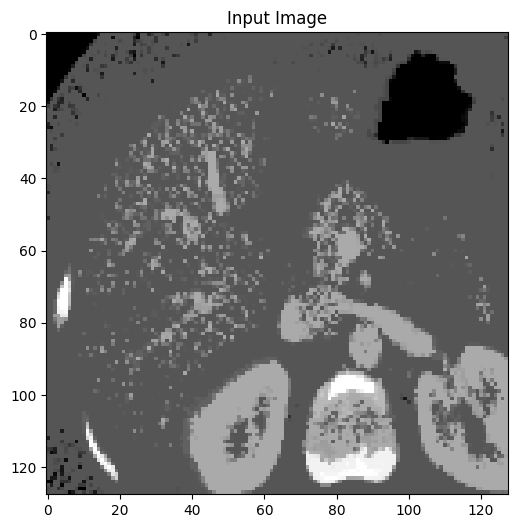

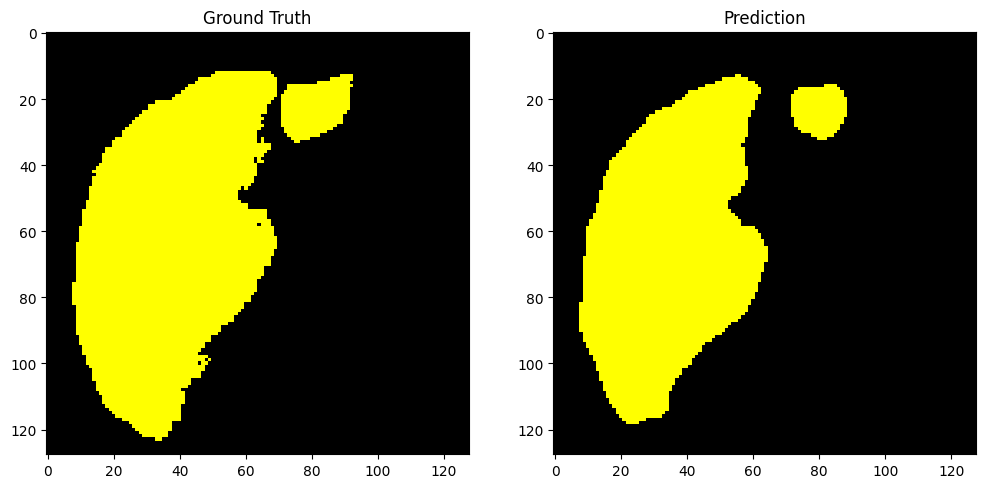

In [18]:
num_images = 1
weight_path = "/content/drive/MyDrive/KLTN/code/weight/best_metric_model_UNet3DWCoTDA.pth"
visualize_results(model, val_loader, weight_path, num_images, device)